In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import time
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
#import tensorflow as tf
import tensorflow_hub as hub
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import warnings

from scipy.sparse import issparse, csr_matrix
from sklearn import manifold, cluster, metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from scipy.optimize import linear_sum_assignment as linear_assignment
import multiprocessing


from yellowbrick.cluster import SilhouetteVisualizer
import itertools

import os
import missingno as msno
 
import seaborn as sns
import matplotlib.pyplot as plt

# Set OMP_NUM_THREADS environment variable
os.environ['OMP_NUM_THREADS'] = '5'

# Filter out DeprecationWarning
warnings.filterwarnings("ignore")

# 1 - Data Exploration

In [2]:
# Load CSV into Pandas DataFrame
text_data_path = r'./Flipkart/flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(text_data_path)
df.sample(5)

uniq_id            crawl_timestamp  \
1009  9bd8526e99697998cdf7dcbdfa044847  2016-05-17 15:52:35 +0000   
369   53c4f1e5cb1767f1a6ba05d32dfaf107  2015-12-01 06:13:00 +0000   
293   c2efa8aa11898bdb5fc4e46201973a42  2016-03-02 16:58:31 +0000   
410   e39177ad1acf95e44ddd430bf969a86b  2015-12-01 06:13:00 +0000   
561   49658948b5f4eb06a3ddc2fa75eb41d0  2016-01-07 05:50:25 +0000   

                                            product_url  \
1009  http://www.flipkart.com/wall-decal-small-self-...   
369   http://www.flipkart.com/tenda-3g300m/p/itmdngv...   
293   http://www.flipkart.com/baby-moshai-girl-s-a-l...   
410   http://www.flipkart.com/asus-rp-n53-dual-band-...   
561   http://www.flipkart.com/hourglass-hg-006-analo...   

                                           product_name  \
1009             Wall Decal Small Self Adhesive Sticker   
369                                        Tenda 3G300M   
293                Baby Moshai Baby Girl's A-line Dress   
410   Asus RP-N53 Dual-Band Wireless-N600 Range Exte...   
561            Hourglass HG 006 Analog Watch  - For Men   

                                  product_category_tree               pid  \
1009  ["Home Decor & Festive Needs >> Wall Decor & C...  STIEGPHX5WZESFKZ   
369   ["Computers >> Network Components >> Routers >...  RTRDNGVMRQ63YU54   
293   ["Baby Care >> Infant Wear >> Baby Girls' Clot...  DREEFFG5PA6AVFH9   
410   ["Computers >> Network Components >> Routers >...  RTRDQ4HQC6A4ZC4G   
561   ["Watches >> Wrist Watches >> Hourglass Wrist ...  WATEYP8CTDHWH7N9   

      retail_price  discounted_price                                 image  \
1009        1199.0             349.0  9bd8526e99697998cdf7dcbdfa044847.jpg   
369         3000.0            1718.0  53c4f1e5cb1767f1a6ba05d32dfaf107.jpg   
293         2100.0             900.0  c2efa8aa11898bdb5fc4e46201973a42.jpg   
410         7490.0            7490.0  e39177ad1acf95e44ddd430bf969a86b.jpg   
561          950.0             850.0  49658948b5f4eb06a3ddc2fa75eb41d0.jpg   

      is_FK_Advantage_product  \
1009                    False   
369                     False   
293                     False   
410                     False   
561                     False   

                                            description       product_rating  \
1009  Key Features of Wall Decal Small Self Adhesive...  No rating available   
369   Buy Tenda 3G300M only for Rs. 3000 from Flipka...                    4   
293   Key Features of Baby Moshai Baby Girl's A-line...  No rating available   
410   Buy Asus RP-N53 Dual-Band Wireless-N600 Range ...                  2.5   
561   Hourglass HG 006 Analog Watch  - For Men - Buy...  No rating available   

           overall_rating        brand  \
1009  No rating available   Wall Decal   
369                     4        Tenda   
293   No rating available  Baby Moshai   
410                   2.5         Asus   
561   No rating available          NaN   

                                 product_specifications  
1009  {"product_specification"=>[{"key"=>"Number of ...  
369   {"product_specification"=>[{"key"=>"Wireless S...  
293   {"product_specification"=>[{"value"=>"1 Dress"...  
410   {"product_specification"=>[{"key"=>"In The Box...  
561   {"product_specification"=>[{"key"=>"Chronograp...

## Completion rate

* 100% completion rate on the most important columns: Name / categories / Description / Specification + images

In [3]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

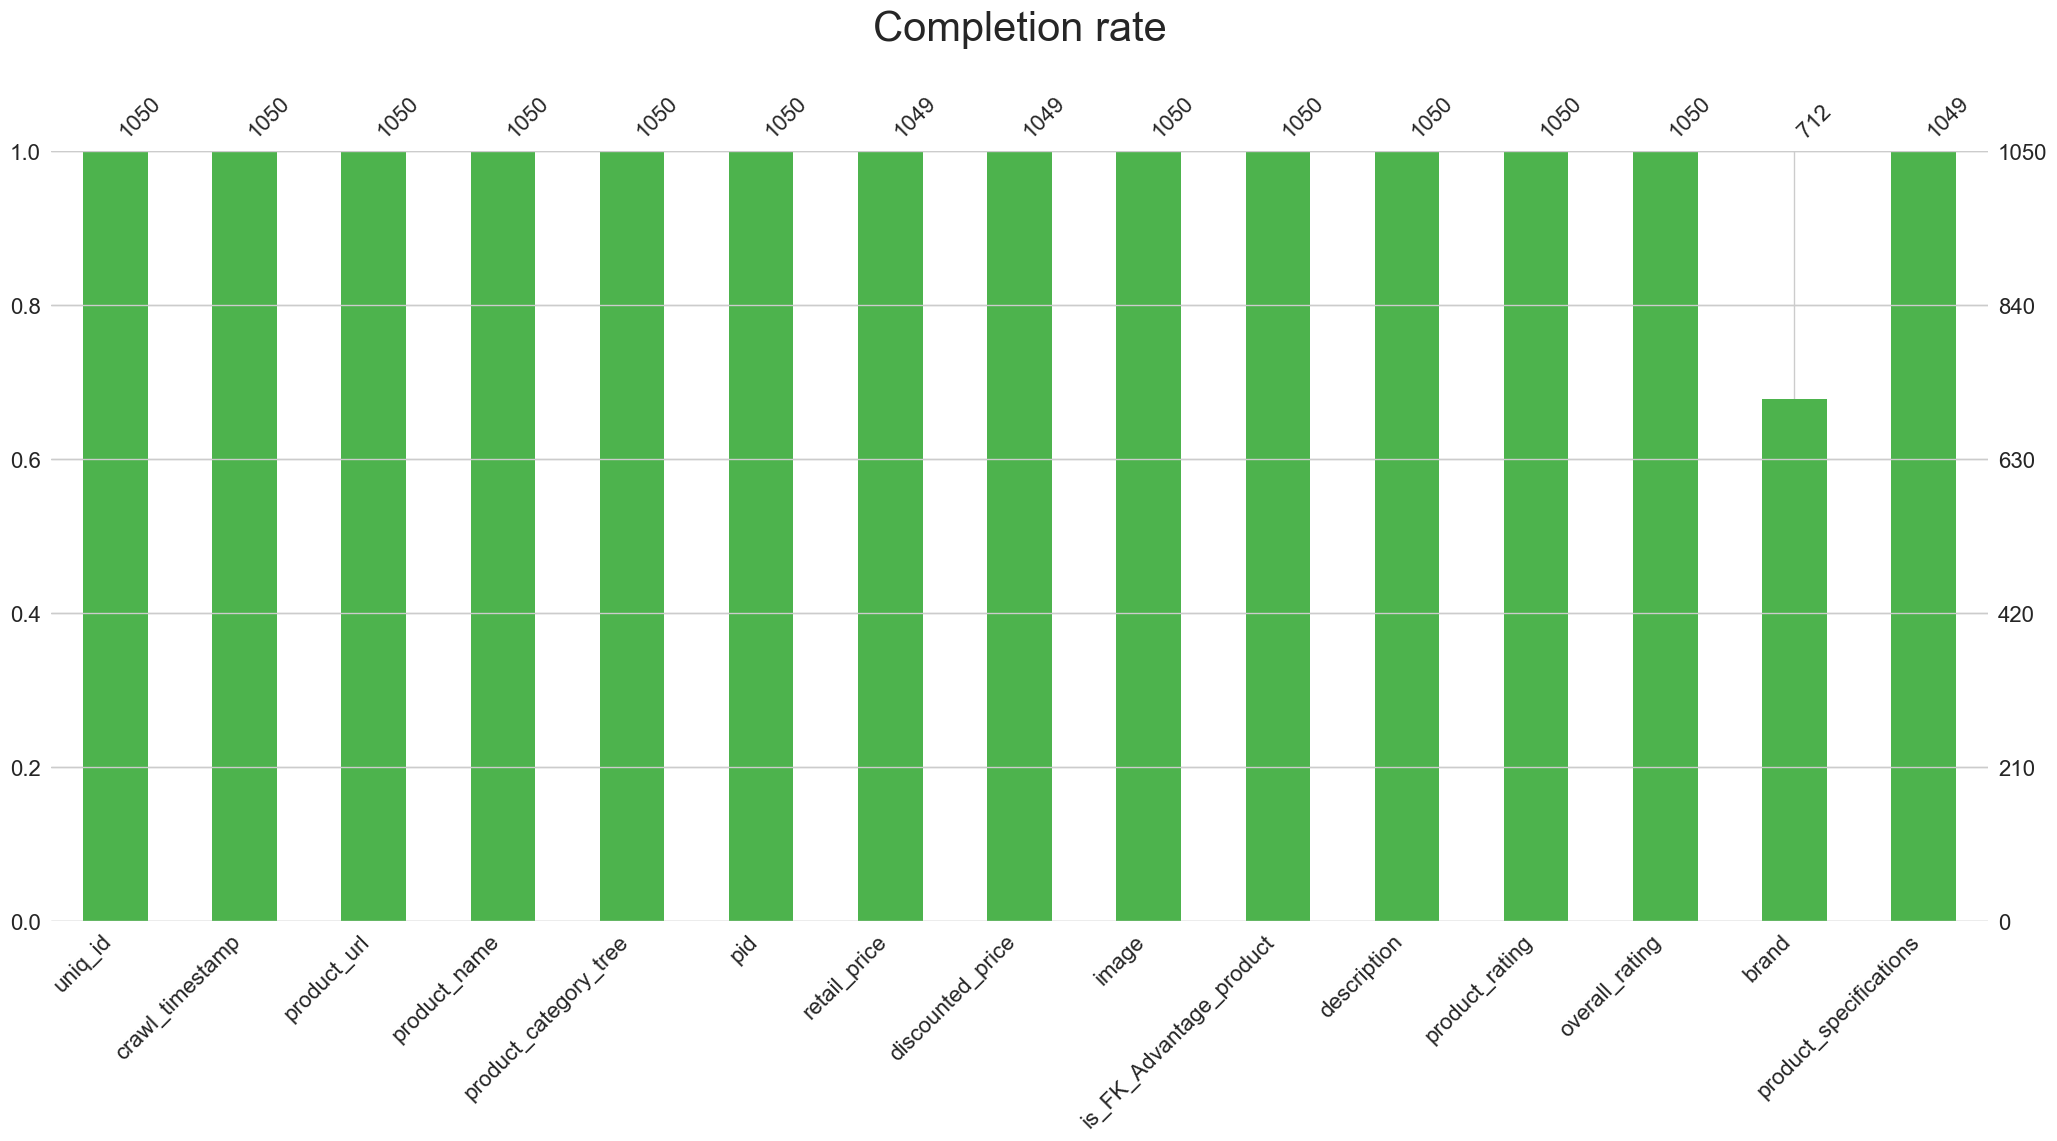

In [4]:
msno.bar(df, color=(0.3, 0.7, 0.3))
plt.title('Completion rate\n', fontsize=30)
plt.show()

## Explore text data

In [5]:
df.product_specifications[16]

'{"product_specification"=>[{"key"=>"Chronograph", "value"=>"No"}, {"key"=>"Date Display", "value"=>"No"}, {"key"=>"Altimeter", "value"=>"No"}, {"key"=>"Barometer", "value"=>"No"}, {"key"=>"Alarm Clock", "value"=>"No"}, {"key"=>"Compass", "value"=>"No"}, {"key"=>"Calendar", "value"=>"No"}, {"key"=>"Luminous", "value"=>"No"}, {"key"=>"Type", "value"=>"Digital"}, {"key"=>"Style Code", "value"=>"BlackLed"}, {"key"=>"Ideal For", "value"=>"Boys"}, {"key"=>"Occasion", "value"=>"Casual, Party-Wedding, Sports"}, {"key"=>"Novelty Feature", "value"=>"Smart Time Indicates"}, {"value"=>"1 Month"}, {"key"=>"Dial Shape", "value"=>"Oval"}, {"key"=>"Strap Color", "value"=>"Black"}, {"key"=>"Scratch Resistant", "value"=>"No"}, {"key"=>"Water Resistant", "value"=>"No"}, {"key"=>"Dial Color", "value"=>"Black"}]}'

In [6]:
df.description[16]

'Jack klein BlackLed Digital Watch  - For Boys - Buy Jack klein BlackLed Digital Watch  - For Boys  BlackLed Online at Rs.150 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

In [7]:
df.product_category_tree[16]

'["Watches >> Wrist Watches >> Jack klein Wrist Watches"]'

In [8]:
df.product_name[16]

'Jack klein BlackLed Digital Watch  - For Boys'

In [9]:
df.image[16]

'5479bb7028827d60000720a2c135976a.jpg'

* Most Frequent words by category

# 2- Feature engineering:
     - Keep only relevant textual data
     - Concatenate Name / Description / Specification

In [10]:
# Split the product_category_tree column into subcategory columns and keep only the 2 first catagory levels
subcategories = df['product_category_tree'].str.split(' >> ', expand=True).iloc[:, :2]

# Rename the columns
subcategories.columns = [f'subcategory_{i+1}' for i in range(subcategories.shape[1])]

# Remove square brackets and double quotes from all strings in the DataFrame
subcategories = subcategories.applymap(lambda x: str(x).replace('[', '').replace('"', '').replace(']', ''))

#Product_Name + Description
df['Name_Description'] = df.product_name + ' ' + df.description
#Product_Name + Product_Specification
df['Name_Specification'] = df.product_name + ' ' + df.product_specifications
#Product_Name + Description + Product_Specification
df['Name_Description_Specification'] = df.product_name + ' ' + df.description + ' ' + df.product_specifications


# Concatenate the original dataframe with the new subcategories columns
df_cleaned = pd.concat([df.uniq_id, df.Name_Specification,  df.Name_Description, #df.product_name, df.description, df.product_specifications
                        df.Name_Description_Specification, subcategories], axis=1)

# Replace NaN with None
df_cleaned = df_cleaned.fillna('None')

# Replace multiple whitespace with one: "   " => " "
df_cleaned = df_cleaned.replace(r'\s+', ' ')

# Display the resulting dataframe
df_cleaned.sample(5)

uniq_id  \
836  9a9402ad55d079c86c302521816b7b0e   
1    7b72c92c2f6c40268628ec5f14c6d590   
12   1e8741b5ae27a513546c94b3f3312aee   
829  d86f260ff28af531443f822c11746521   
37   e9420e9483f16db81c64dddf99f34841   

                                    Name_Specification  \
836  RRP Alpha X002 USB Led Light {"product_specifi...   
1    Sathiyas Cotton Bath Towel {"product_specifica...   
12   Lois Caron LCS-4032 Analog Watch  - For Boys, ...   
829  Fonokase SU100 SU100 USB USB Charger {"product...   
37   Dungri India Craft Ducjug010-ducgl012-2 Jug Gl...   

                                      Name_Description  \
836  RRP Alpha X002 USB Led Light RRP Alpha X002 US...   
1    Sathiyas Cotton Bath Towel Specifications of S...   
12   Lois Caron LCS-4032 Analog Watch  - For Boys, ...   
829  Fonokase SU100 SU100 USB USB Charger Buy Fonok...   
37   Dungri India Craft Ducjug010-ducgl012-2 Jug Gl...   

                        Name_Description_Specification     subcategory_1  \
836  RRP Alpha X002 USB Led Light RRP Alpha X002 US...         Computers   
1    Sathiyas Cotton Bath Towel Specifications of S...         Baby Care   
12   Lois Caron LCS-4032 Analog Watch  - For Boys, ...           Watches   
829  Fonokase SU100 SU100 USB USB Charger Buy Fonok...         Computers   
37   Dungri India Craft Ducjug010-ducgl012-2 Jug Gl...  Kitchen & Dining   

           subcategory_2  
836   Laptop Accessories  
1       Baby Bath & Skin  
12         Wrist Watches  
829   Laptop Accessories  
37   Tableware & Cutlery

In [11]:
# Columns to process
columns_to_process = df_cleaned.drop(columns=['uniq_id'] + list(subcategories.columns)).columns
columns_to_process

Index(['Name_Specification', 'Name_Description',
       'Name_Description_Specification'],
      dtype='object')

Corpus will be based on:
 * Name + Description + Specification
 * Name + Specification
 * Name + Description

In [12]:
# Target categories
Categories = subcategories.columns
Categories

Index(['subcategory_1', 'subcategory_2'], dtype='object')

* Plot number of products by Level 1 and Level 2 categories

<function matplotlib.pyplot.show(close=None, block=None)>

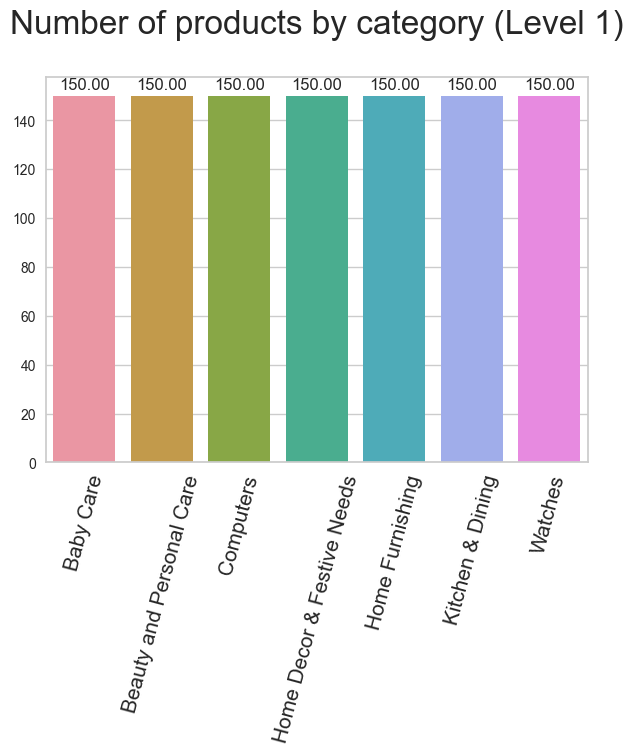

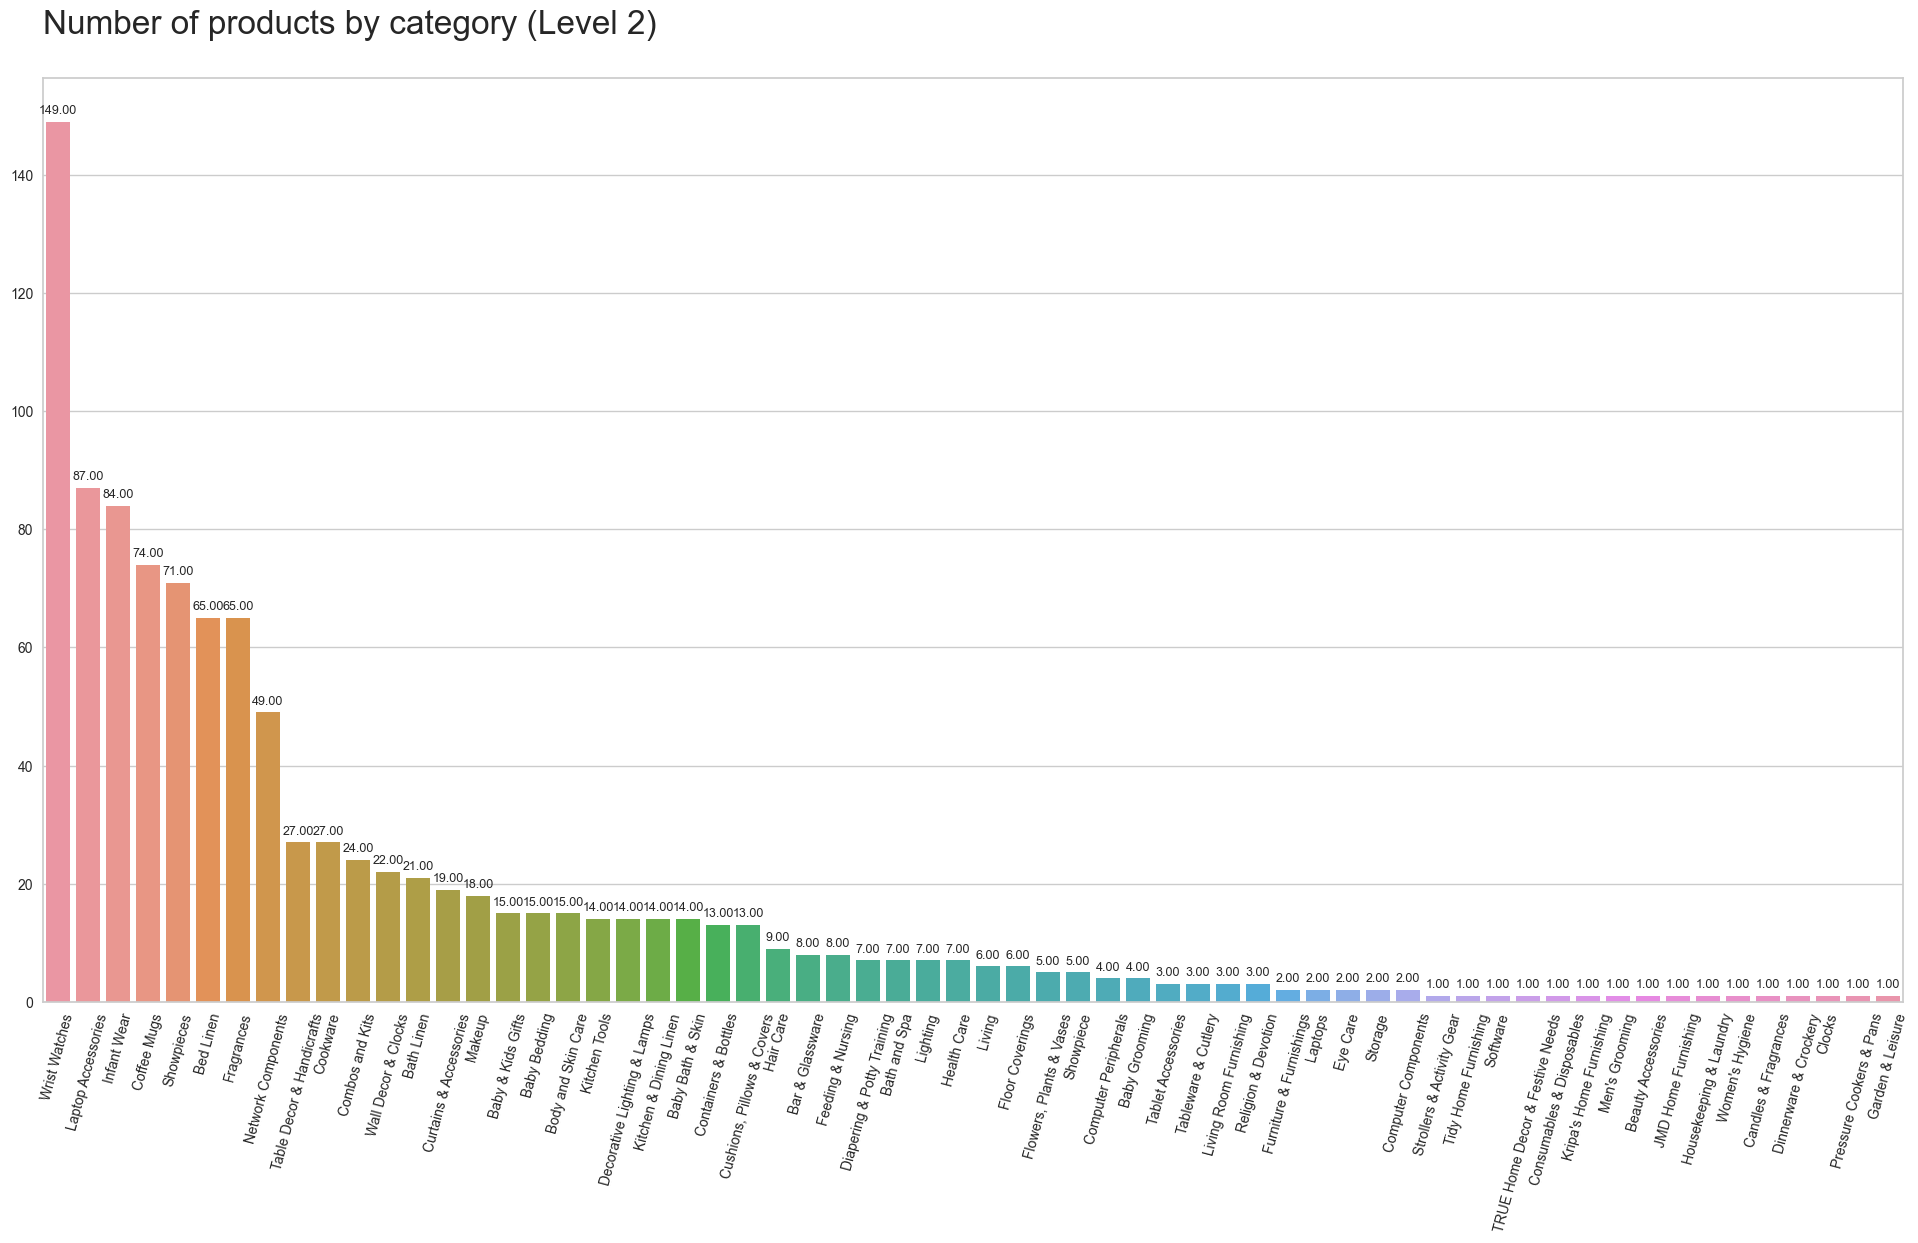

In [13]:
plt.figure(figsize=(7, 5))
plt.title("Number of products by category (Level 1)\n", fontsize = 24)
plots = sns.barplot(x=np.unique(df_cleaned.subcategory_1, return_counts=True)[0], y=np.unique(df_cleaned.subcategory_1, return_counts=True)[1])
plt.xticks(fontsize=15, rotation=75)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center', size=12, xytext=(0, 8),
                   textcoords='offset points')

plt.show

u, count = np.unique(df_cleaned.subcategory_2, return_counts=True)
count_sort_ind = np.argsort(-count)
u[count_sort_ind], count[count_sort_ind]

plt.figure(figsize=(24, 12))
plt.title("Number of products by category (Level 2)\n", fontsize = 24, loc='left')

plots = sns.barplot(x=u[count_sort_ind], y=count[count_sort_ind])
plt.xticks(fontsize=10, rotation=75)

for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 8),
                   textcoords='offset points')

plt.show

* Level 1 ctagories: 7
* Level 2 categories: 63
* Level1 categories are perfect for a classification analysis as each category holds 150 products (7 x 150 = 1050)

In [14]:
df_cleaned = df_cleaned.drop(columns='subcategory_2')

In [15]:
real_categories = list(set(df_cleaned['subcategory_1']))
real_categories

['Computers',
 'Baby Care',
 'Beauty and Personal Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Home Furnishing',
 'Kitchen & Dining']

In [16]:
le = LabelEncoder()
le.fit(df_cleaned['subcategory_1'])
df_cleaned['category_encoded'] = le.transform(df_cleaned['subcategory_1'])
category_dict = dict(zip(df_cleaned['subcategory_1'], df_cleaned['category_encoded']))
category_dict

{'Home Furnishing': 4,
 'Baby Care': 0,
 'Watches': 6,
 'Home Decor & Festive Needs': 3,
 'Kitchen & Dining': 5,
 'Beauty and Personal Care': 1,
 'Computers': 2}

In [17]:
df_cleaned.groupby("category_encoded").count()

uniq_id  Name_Specification  Name_Description  \
category_encoded                                                  
0                     150                 150               150   
1                     150                 150               150   
2                     150                 150               150   
3                     150                 150               150   
4                     150                 150               150   
5                     150                 150               150   
6                     150                 150               150   

                  Name_Description_Specification  subcategory_1  
category_encoded                                                 
0                                            150            150  
1                                            150            150  
2                                            150            150  
3                                            150            150  
4                                            150            150  
5                                            150            150  
6                                            150            150

* Text processing for Countvectorizer, Tf_idf and Word2Vec

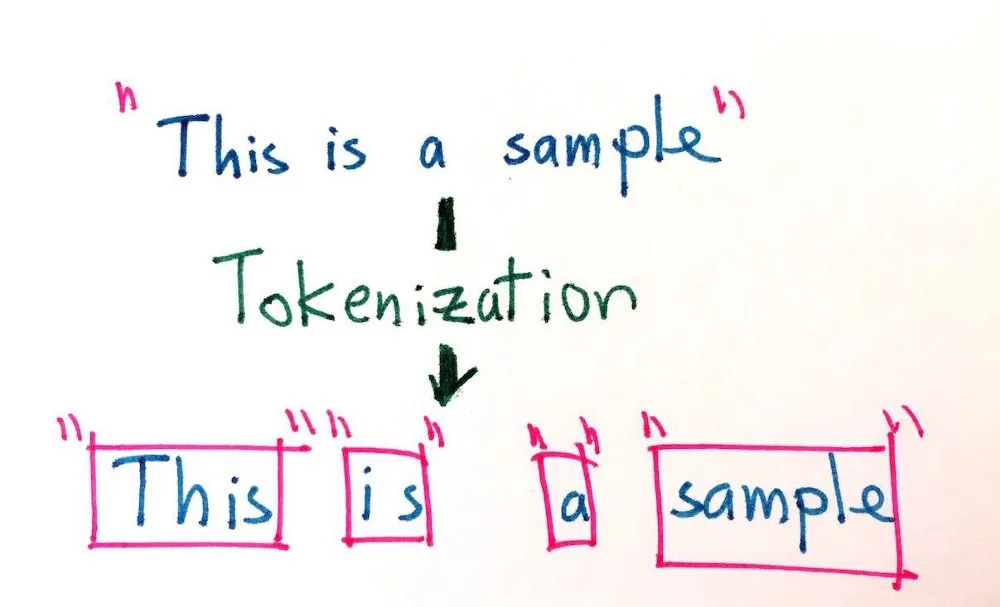 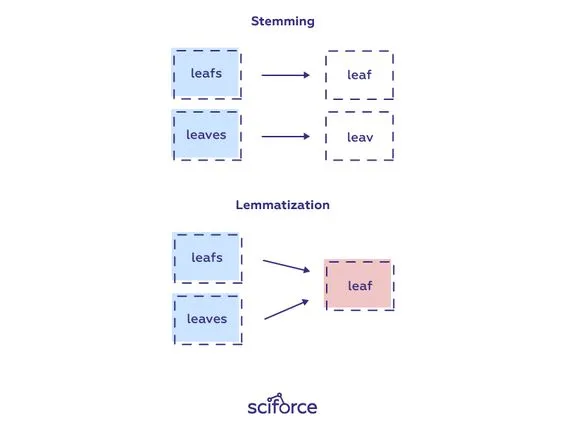
* Tokenization is the process of breaking down a text into individual units, known as tokens. These tokens can be words, phrases, sentences, or other meaningful elements depending on the level of granularity needed for analysis.
* Lemmatization is the process of finding the form of the related word in the dictionary. It is different from Stemming. It involves longer processes to calculate than Stemming. Let’s examine a definition made about this.
* Stemming: The process of converting the words to their stem word. Stem word means base word. Stem word has no meaning in that language.

SESSION1 vérifier si les mots "bateaux" ne sont pas spécifiques à UNE SEULE catégories: 

In [18]:
# Load spaCy English language model
nlp = spacy.load("en_core_web_sm")

def process_text(text):
    # Text Cleaning + lower case
    cleaned_text  = re.sub(r'[^a-zA-Z\s]', ' ', str(text)).lower()
    
    # Tokenization
    doc = nlp(cleaned_text )
    
    # Lemmatization and stopword removal
    processed_tokens = [token.lemma_.lower() for token in doc if (token.lemma_.lower() not in my_stopwords) and (len(token.lemma_.lower()) > 2)]

    # join the processed token into a string + ensure having onlY one space gap
    joined_tokens = re.sub(r'\s{2,}', ' ', ' '.join(processed_tokens))
    
    return joined_tokens


def process_text_bert_use(text):
    # Text Cleaning + lower case
    cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', str(text)).lower()
    
    # Tokenization
    doc = nlp(cleaned_text)
    
    # Convert tokens to strings
    token_strings = [str(token) for token in doc]

    # join the processed tokens into a string + ensure having only one space gap
    joined_tokens = re.sub(r'\s{2,}', ' ', ' '.join(token_strings))
    
    return joined_tokens

Text processing: Loop 1

In [19]:
# Download stopwords from NLTK
#nltk.download('stopwords')
#nltk.download('omw-1.4')
#lemmatizer = WordNetLemmatizer()


my_stopwords = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

In [20]:
# Iterate through columns and apply text cleaning
for text_Column in columns_to_process:
    df_cleaned.loc[:, text_Column] = df_cleaned[text_Column].apply(process_text)

df_cleaned.Name_Description_Specification[10]

'calibro analog digital watch man boys calibro analog digital watch man boy price calibro present mtg black dial round watch fashionable watch mtg add style statement brand know usage quality material make appeal watch understand need youth well able present wide range watch customer variety design style youthful approach well execute brand get one see brilliantly lead brand style finish everything else matter calibro present mtg black dial round watch fashionable watch mtg add style statement brand know usage quality material make appeal watch understand need youth well able present wide range watch customer variety design style youthful approach well execute brand get one see brilliantly lead brand style finish everything else matter product specification key chronograph value yes key date display value yes day date display key altimeter value key barometer value key alarm clock value yes key compass value key light value yes key calendar value key luminous value yes key type value a

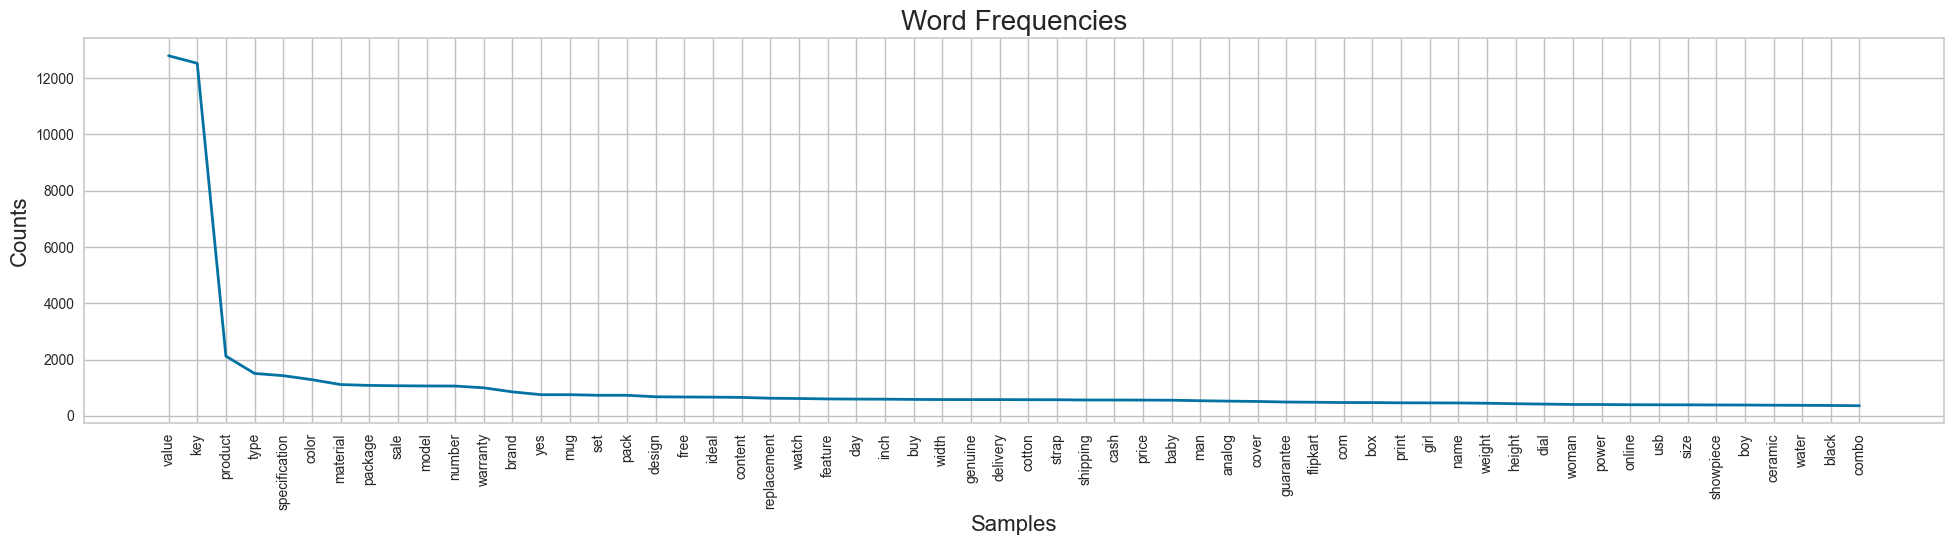

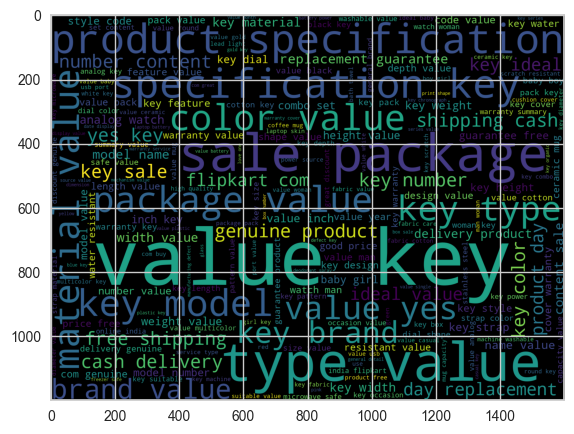

In [21]:
word_string = ' '.join(df_cleaned['Name_Description_Specification'].astype(str))

plt.figure(figsize = (24,5))
plt.title("Word Frequencies", fontsize=20)
plt.xlabel('Words', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
nltk.FreqDist(word_string.split()).plot(60)
plt.show()

plt.figure(figsize = (24,5))
wordcloud = WordCloud(background_color="black",
                          width=1600, height=1200,
                          stopwords=my_stopwords
                         ).generate(word_string)
plt.imshow(wordcloud)

Text processing: Loop 2 by Updating stopwords list

In [22]:
my_stopwords += ['flipkart', 'product', 'specification', 'genuine', 'warranty', 'guarantee', 'exclusive', 'delivery', 'shipping', 'cash','key', 'value', 'feature', 'brand', 'yes', 'india', 'set',
                        'type', 'sales', 'style', 'id', 'cm', 'mm', 'inch', 'g', 'model', 'free', 'replacement', 'com', 'price', 'best', 'content', 'online', 'sale', 'buy', 'discount', 'box', 'detail',
                      'shape', 'dimension', 'diameter', 'height', 'length', 'width', 'thickness', 'weight', 'number', 'content','material', 'package', 'pack', 'name', 'ideal', 'size', 'color', 'quality',
                      'manufacturing', 'defect', 'made', 'design', 'general', 'typemodel', 'salepackage', 'flipkartcom', 'great', 'discountgenuine', 'cashdelivery', 'pattern',
                       'high', 'small', 'depth', 'summary', 'also', 'abstract', 'add', 'additional', 'need', 'make', 'use', 'please', 'perfect', 'fit', 'like', 'bring', 'else', 'well', 'one']


In [23]:
# Iterate through columns and apply text cleaning
for text_Column in columns_to_process:
    df_cleaned.loc[:, text_Column] = df_cleaned[text_Column].apply(process_text)

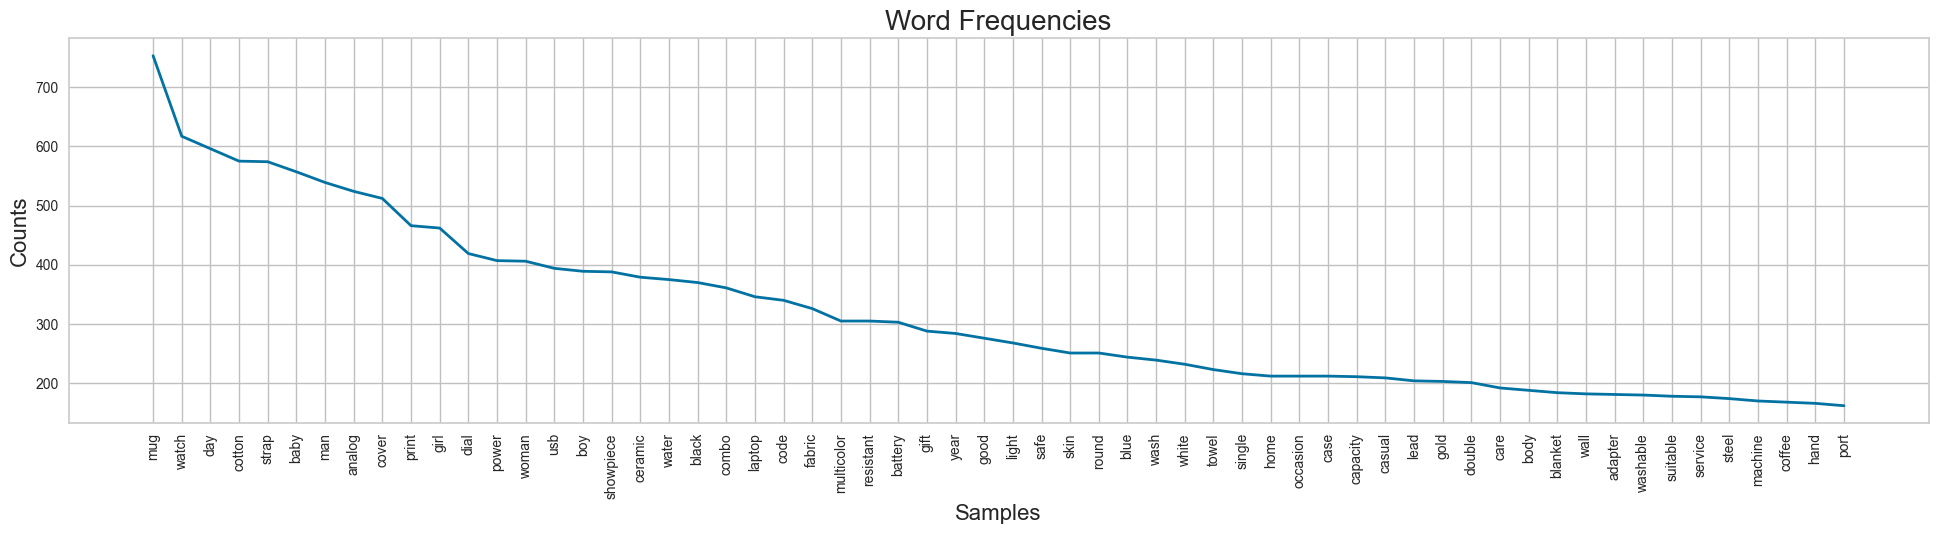

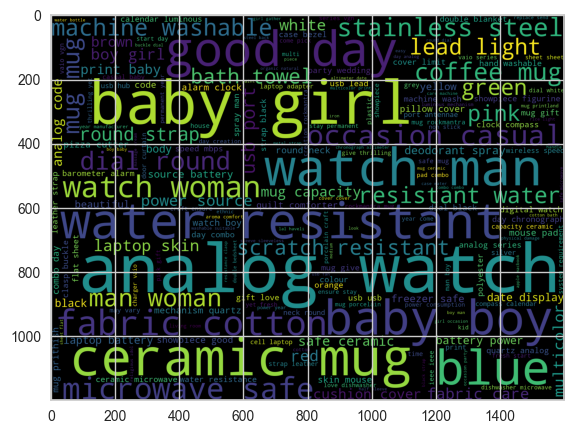

In [24]:
word_string = ' '.join(df_cleaned['Name_Description_Specification'].astype(str))

plt.figure(figsize = (24,5))
plt.title("Word Frequencies", fontsize=20)
plt.xlabel('Words', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
nltk.FreqDist(word_string.split()).plot(60)
plt.show()

plt.figure(figsize = (24,5))
wordcloud = WordCloud(background_color="black",
                          width=1600, height=1200,
                          stopwords=my_stopwords
                         ).generate(word_string)
plt.imshow(wordcloud)

# 3 - Feasbility analysis

## Bag of words - CountVectorizer / Tf-idf / SDV / KMEANS / TSNE

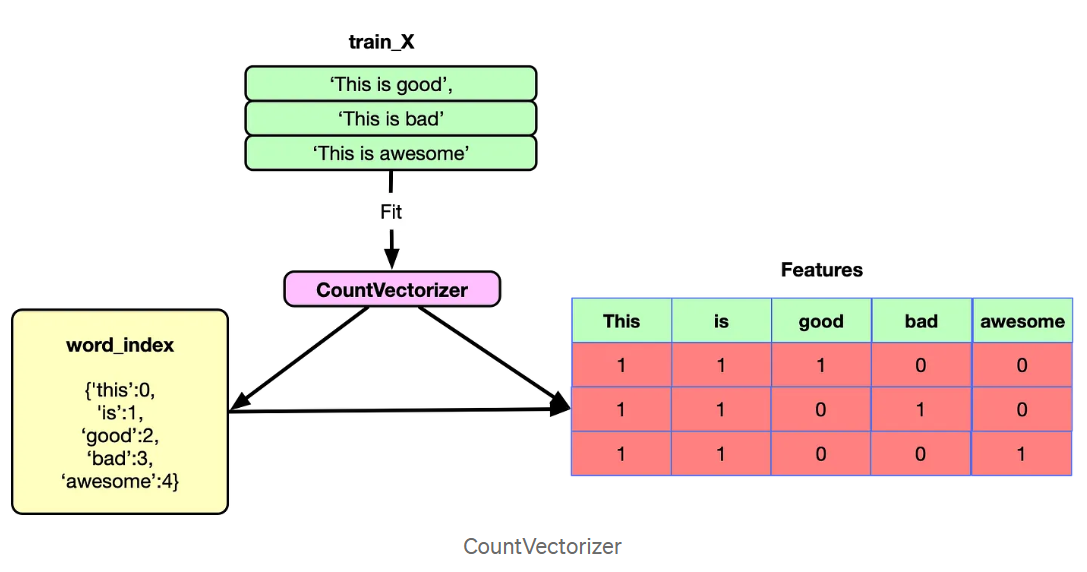 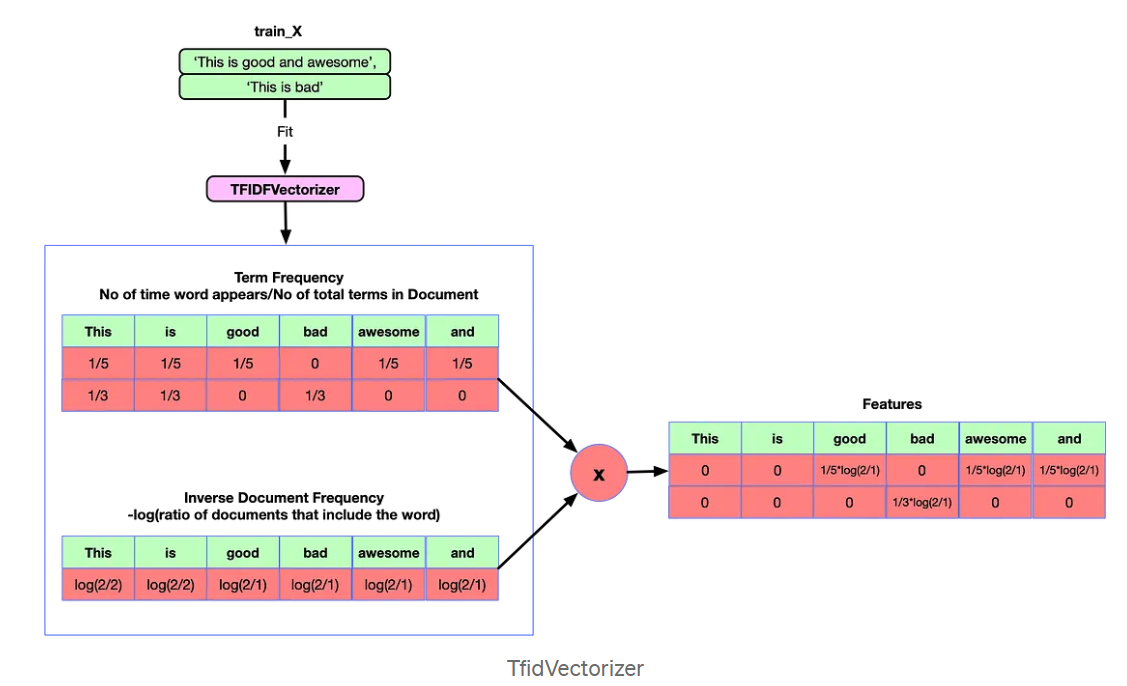

* max_df = 0.80 : to ignore words that are too popular. (present in 80% of the documents)
* min_df = 0.05 : to ignore words that are too rare. (present in only 5% document)

In [25]:
corpus_example = columns_to_process[1]

#CountVectorizer and TfidfVectorizer
def vectorize_text(df, text_column, vectorizer_type):
    if vectorizer_type == 'CountVectorizer':
        vectorizer = CountVectorizer(max_df=0.95, min_df=0.01)
    elif vectorizer_type == 'TfidfVectorizer':
        vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.01)
    else:
        raise ValueError("Invalid vectorizer_type. Use 'count' or 'tfidf'.")

    features = vectorizer.fit_transform(df[text_column])
    tokens = vectorizer.get_feature_names_out()
    df_features = pd.DataFrame(features.toarray(), columns=tokens)
    df_features[text_column] = df[text_column].tolist()
    df_features = df_features[[text_column] + [col for col in df_features if col != text_column]]

    return features, df_features

features, df_features = vectorize_text(df_cleaned, corpus_example, 'TfidfVectorizer')
print('column to process: ' + corpus_example)
print(f"shape of the features: {features.shape}")
df_features.sample(10)

column to process: Name_Description
shape of the features: (1050, 414)


Name_Description  accessory    actual  \
485   lapguard lenovo ideapad cell laptop battery la...        0.0  0.095678   
540   time sport analog watch boy times sport analog...        0.0  0.000000   
722   sapato plain single duvet red sapatos plain si...        0.0  0.000000   
122   shopizone bmw wheel pen drive shopizone bmw wh...        0.0  0.000000   
178   prithish mom superpower multicoloure bubble bl...        0.0  0.000000   
191   prithish blue gold heart love ceramic mug prit...        0.0  0.000000   
1032  print mary max cartoon laptop skin mouse pad c...        0.0  0.000000   
184   prithish pschedelic collection ceramic mug pri...        0.0  0.000000   
677   simoco lead bulb simoco lead bulb simoco lead ...        0.0  0.000000   
181   printland cmw ceramic mug printland cmw cerami...        0.0  0.000000   

      adapter  adorable  affordable       age  aluminium    analog  antique  \
485       0.0  0.000000         0.0  0.000000        0.0  0.000000      0.0   
540       0.0  0.000000         0.0  0.000000        0.0  0.491909      0.0   
722       0.0  0.000000         0.0  0.000000        0.0  0.000000      0.0   
122       0.0  0.232450         0.0  0.229732        0.0  0.000000      0.0   
178       0.0  0.000000         0.0  0.000000        0.0  0.000000      0.0   
191       0.0  0.000000         0.0  0.000000        0.0  0.000000      0.0   
1032      0.0  0.000000         0.0  0.000000        0.0  0.000000      0.0   
184       0.0  0.000000         0.0  0.000000        0.0  0.000000      0.0   
677       0.0  0.000000         0.0  0.000000        0.0  0.000000      0.0   
181       0.0  0.144754         0.0  0.000000        0.0  0.000000      0.0   

      ...  woman  wood  wooden      work  world     would  wrap  year  yellow  \
485   ...    0.0   0.0     0.0  0.000000    0.0  0.000000   0.0   0.0     0.0   
540   ...    0.0   0.0     0.0  0.000000    0.0  0.000000   0.0   0.0     0.0   
722   ...    0.0   0.0     0.0  0.000000    0.0  0.000000   0.0   0.0     0.0   
122   ...    0.0   0.0     0.0  0.210684    0.0  0.000000   0.0   0.0     0.0   
178   ...    0.0   0.0     0.0  0.000000    0.0  0.000000   0.0   0.0     0.0   
191   ...    0.0   0.0     0.0  0.000000    0.0  0.000000   0.0   0.0     0.0   
1032  ...    0.0   0.0     0.0  0.000000    0.0  0.065768   0.0   0.0     0.0   
184   ...    0.0   0.0     0.0  0.000000    0.0  0.000000   0.0   0.0     0.0   
677   ...    0.0   0.0     0.0  0.000000    0.0  0.000000   0.0   0.0     0.0   
181   ...    0.0   0.0     0.0  0.000000    0.0  0.000000   0.0   0.0     0.0   

      yet  
485   0.0  
540   0.0  
722   0.0  
122   0.0  
178   0.0  
191   0.0  
1032  0.0  
184   0.0  
677   0.0  
181   0.0  

[10 rows x 415 columns]

In [26]:
df_features[df_features.iloc[:, 1:].apply(lambda row: (row != 0).sum(), axis=1) >= 5].sample(5)


Name_Description  accessory    actual  \
536   time tms party wedding analog watch woman time...        0.0  0.000000   
572   time tms party wedding analog watch woman time...        0.0  0.000000   
1001  mom baby girl bodysuit mom baby girl bodysuit ...        0.0  0.000000   
266   pigeon kadhai pigeon kadhai aluminium glass no...        0.0  0.000000   
62    aroma care intense nail polish combo aroma car...        0.0  0.203223   

      adapter  adorable  affordable       age  aluminium    analog  antique  \
536       0.0  0.000000         0.0  0.000000   0.000000  0.328119      0.0   
572       0.0  0.000000         0.0  0.000000   0.000000  0.328119      0.0   
1001      0.0  0.139235         0.0  0.137607   0.000000  0.000000      0.0   
266       0.0  0.000000         0.0  0.000000   0.147299  0.000000      0.0   
62        0.0  0.000000         0.0  0.000000   0.000000  0.000000      0.0   

      ...    woman  wood  wooden  work  world  would  wrap  year  yellow  yet  
536   ...  0.38156   0.0     0.0   0.0    0.0    0.0   0.0   0.0     0.0  0.0  
572   ...  0.38156   0.0     0.0   0.0    0.0    0.0   0.0   0.0     0.0  0.0  
1001  ...  0.00000   0.0     0.0   0.0    0.0    0.0   0.0   0.0     0.0  0.0  
266   ...  0.00000   0.0     0.0   0.0    0.0    0.0   0.0   0.0     0.0  0.0  
62    ...  0.00000   0.0     0.0   0.0    0.0    0.0   0.0   0.0     0.0  0.0  

[5 rows x 415 columns]

* Dimensiality reduction: SVD prefered to PCA as features are coming as a sparce matrix

This function calculates the number of components needed for TruncatedSVD (Singular Value Decomposition with dimensionality reduction) to achieve a specified target explained variance ratio. The goal is to find the minimum number of components that collectively capture at least the given ratio of the total variance in the input data.

In [27]:
def ncomponents_with_target_explained_ratio(X, target_ratio):
    # Initialize TruncatedSVD
    svd = TruncatedSVD(n_components=X.shape[1] - 1)  # Use the maximum possible components
    
    # Fit on the data
    svd.fit(X)
    
    # Determine the number of components to achieve the target ratio
    n_components = np.argmax(np.cumsum(svd.explained_variance_ratio_) >= target_ratio) + 1
    
    return n_components

In [28]:
normalizer = Normalizer(copy=False)

# Dimensionality reduction, determine clusters, and calculate ARI between true categories and cluster numbers
def SVD_Runner(features):
    # Check if the data is sparse
    if issparse(csr_matrix(features)):
        print("The features matrix is sparse. Going to run Truncated SVD!")
    else:
        print("The features matrix is not sparse.")

    n_components = ncomponents_with_target_explained_ratio(features, target_ratio=0.99)
    print(str(features.shape))
    print(n_components)
    reduction = TruncatedSVD(n_components=n_components, n_iter=100,)
    SVD_features = reduction.fit_transform(features)
    print(f"Explained variance ratio: {np.sum(reduction.explained_variance_ratio_):.2f}")
    SVD_features = normalizer.fit_transform(SVD_features)

    return SVD_features

SVD_features = SVD_Runner(features)
SVD_features.shape

The features matrix is sparse. Going to run Truncated SVD!
(1050, 414)
273
Explained variance ratio: 0.99


(1050, 273)

In [29]:
normalizer = Normalizer(copy=False)

# Dimensionality reduction, determine clusters, and calculate ARI between true categories and cluster numbers
def Reduction_Runner(features):
    # Check if the data is sparse
    if issparse(csr_matrix(features)):
        print("The features matrix is sparse. Going to run Truncated SVD!")
        n_components = ncomponents_with_target_explained_ratio(features, target_ratio=0.99)
        print(n_components)
        reduction = TruncatedSVD(n_components=n_components, n_iter=100,)
    else:
        print("The features matrix is not sparse. Going to run Truncated PCA!")
        reduction = PCA(n_components=0.99, n_iter=100,)

    
    print(str(features.shape))
    Reduced_features = reduction.fit_transform(features)
    print(f"Explained variance ratio: {np.sum(reduction.explained_variance_ratio_):.2f}")
    Reduced_features = normalizer.fit_transform(Reduced_features)

    return SVD_features

SVD_features = SVD_Runner(features)
SVD_features.shape

The features matrix is sparse. Going to run Truncated SVD!
(1050, 414)
273
Explained variance ratio: 0.99


(1050, 273)

* t-SNE dimensionality reduction

In [30]:
def apply_tsne(SVD_features, tsne_params=None):
    # Create a t-SNE object with specified parameters
    tsne = manifold.TSNE(**(tsne_params or {}))

    # Fit and transform the data using t-SNE on the reduced features
    X_tsne = tsne.fit_transform(SVD_features)

    # Create a DataFrame to store the t-SNE results
    df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])

    return X_tsne, df_tsne

X_tsne, df_tsne = apply_tsne(SVD_features, tsne_params=None)

df_tsne["category"] = df_cleaned["subcategory_1"]
df_tsne["category_encoded"] = df_cleaned["category_encoded"]
# Print the shape of the t-SNE DataFrame
print("X-tSNE shape:", X_tsne.shape)

X-tSNE shape: (1050, 2)


* Kmeans clusterisation and metrics

In [31]:
def calculate_ari(labels_true, labels_pred):
    ari = np.round(metrics.adjusted_rand_score(labels_true, labels_pred), 2)
    return ari

def calculate_silhouette_score(data, labels):
    silhouette = np.round(metrics.silhouette_score(data, labels), 2)
    return silhouette

In [32]:
def Kmeans_Metrics(X_tsne, num_clusters):
    # Determine clusters from the data after dimensiality reduction (SVD)
    kmeans = cluster.KMeans(n_clusters=num_clusters, n_init=100, random_state=42)
    kmeans.fit(X_tsne)

    # Metrics
    ARI = calculate_ari(df_cleaned.category_encoded, kmeans.labels_)
    SILOUHETTE = calculate_silhouette_score(X_tsne, kmeans.labels_)

    return ARI, SILOUHETTE, kmeans.labels_

ARI, SILOUHETTE, kmeans_labels = Kmeans_Metrics(X_tsne, num_clusters=len(real_categories))

df_tsne["Kmeans_cluster"] = kmeans_labels
print('ARI score :' + str(ARI), '/ Silouhette score: ' + str(SILOUHETTE), '/ kmeans.labels_: ' + str(kmeans_labels.shape))

ARI score :0.54 / Silouhette score: 0.48 / kmeans.labels_: (1050,)


* Visualize the transformed confusion matrix and K-means cluster results on t-SNE reduced data.

[[  3   4   0 101   3   0  39]
 [118   5   1   1   0   0  25]
 [ 26   0   0   0   0 116   8]
 [  2 118   0   1   3  11  15]
 [  0   4   0 115   0   0  31]
 [  5  25   0   1  75   7  37]
 [  0   0 148   0   0   0   2]]
corresp: [1 3 6 4 5 2 0]


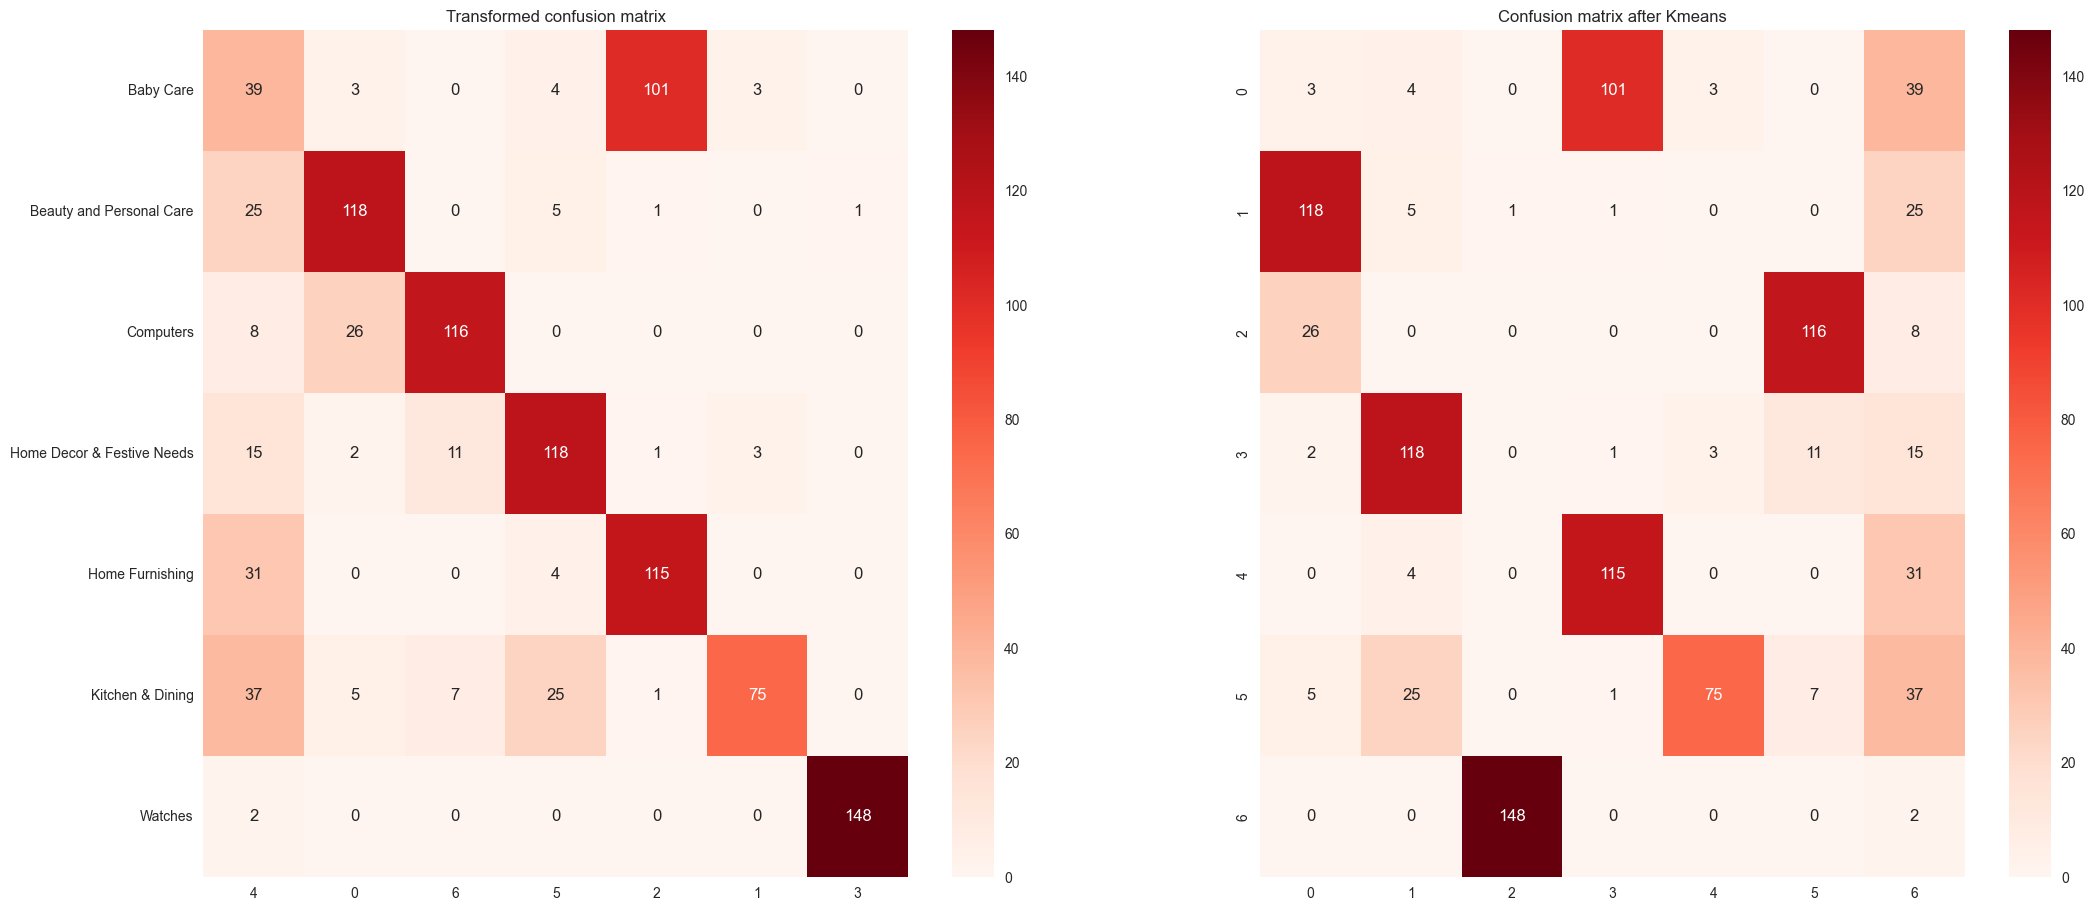

              precision    recall  f1-score   support

           0       0.25      0.26      0.25       150
           1       0.77      0.79      0.78       150
           2       0.87      0.77      0.82       150
           3       0.76      0.79      0.77       150
           4       0.53      0.77      0.62       150
           5       0.93      0.50      0.65       150
           6       0.99      0.99      0.99       150

    accuracy                           0.69      1050
   macro avg       0.73      0.69      0.70      1050
weighted avg       0.73      0.69      0.70      1050



In [33]:
def remove_duplicate(arr):
    count_dict = {}
    
    for num in arr:
        count_dict[num] = count_dict.get(num, 0) + 1

    missing_number = next(x for x in range(len(arr) + 1) if x not in count_dict)

    replaced_second_occurrence = False
    result_array = []

    for num in np.flip(arr):
        if count_dict[num] > 1 and not replaced_second_occurrence:
            result_array.append(missing_number)
            replaced_second_occurrence = True
        else:
            result_array.append(num)

    return np.flip(result_array)

def conf_mat_transform(df_tsne):
    y_true = df_tsne.category_encoded
    y_pred = df_tsne.Kmeans_cluster

    # Step 1: Compute the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    print(conf_mat)
    
    # Step 2: Find the correspondence between clusters
    corresp = np.argmax(conf_mat, axis=0)
    print('corresp: ' + str(corresp))

    # If corresp has repeating numbers, use linear_sum_assignment
    if len(np.unique(corresp)) != len(corresp):
        corresp = remove_duplicate(corresp)
    
    # Step 3: Transform predicted labels based on correspondence
    y_pred_transform = y_pred.apply(lambda x : corresp[x]) 
    #y_pred_transform = corresp[y_pred]

    # Add the 'Transformed_Cluster' column to df_tsne
    df_tsne['Transformed_Cluster'] = y_pred_transform

    # Rearrange the confusion matrix to have maximum values on the diagonal
    #conf_mat_transf = rearrange_confusion_matrix(confusion_matrix(y_true, y_pred_transform))
    conf_mat_transf = confusion_matrix(y_true, y_pred_transform)
    
    unique_values, unique_indices = np.unique(y_pred_transform, return_index=True)
    # Sort by the order of appearance
    sorted_indices = np.argsort(unique_indices)

    
    # Convert sorted_indices to a list
    #sorted_indices_list = list(sorted_indices)
    sorted_indices_list = [0, 1, 2, 3, 4, 5, 6]
    # Use sorted with a custom key function
    category_name = [key for key, value in sorted(category_dict.items(), key=lambda x: sorted_indices_list.index(x[1]))]

    df_cm_transf = pd.DataFrame(conf_mat_transf, index=category_name, columns=sorted_indices)

    fig = plt.figure(figsize=(25, 11))
    ax = fig.add_subplot(121)
    cm1 = sns.heatmap(df_cm_transf, annot=True, fmt="d", cmap="Reds")
    plt.title('Transformed confusion matrix')

    ax = fig.add_subplot(122)
    cm2 = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds")
    plt.title('Confusion matrix after Kmeans')

    plt.show()

    # Classification report:
    print(classification_report(df_tsne.category_encoded, df_tsne.Transformed_Cluster))

    return df_cm_transf, df_tsne, category_name, sorted_indices

df_cm_transf, df_tsne, category_name, sorted_indices = conf_mat_transform(df_tsne)


[[  3   4   0 101   3   0  39]
 [118   5   1   1   0   0  25]
 [ 26   0   0   0   0 116   8]
 [  2 118   0   1   3  11  15]
 [  0   4   0 115   0   0  31]
 [  5  25   0   1  75   7  37]
 [  0   0 148   0   0   0   2]]
corresp: [1 3 6 4 5 2 0]


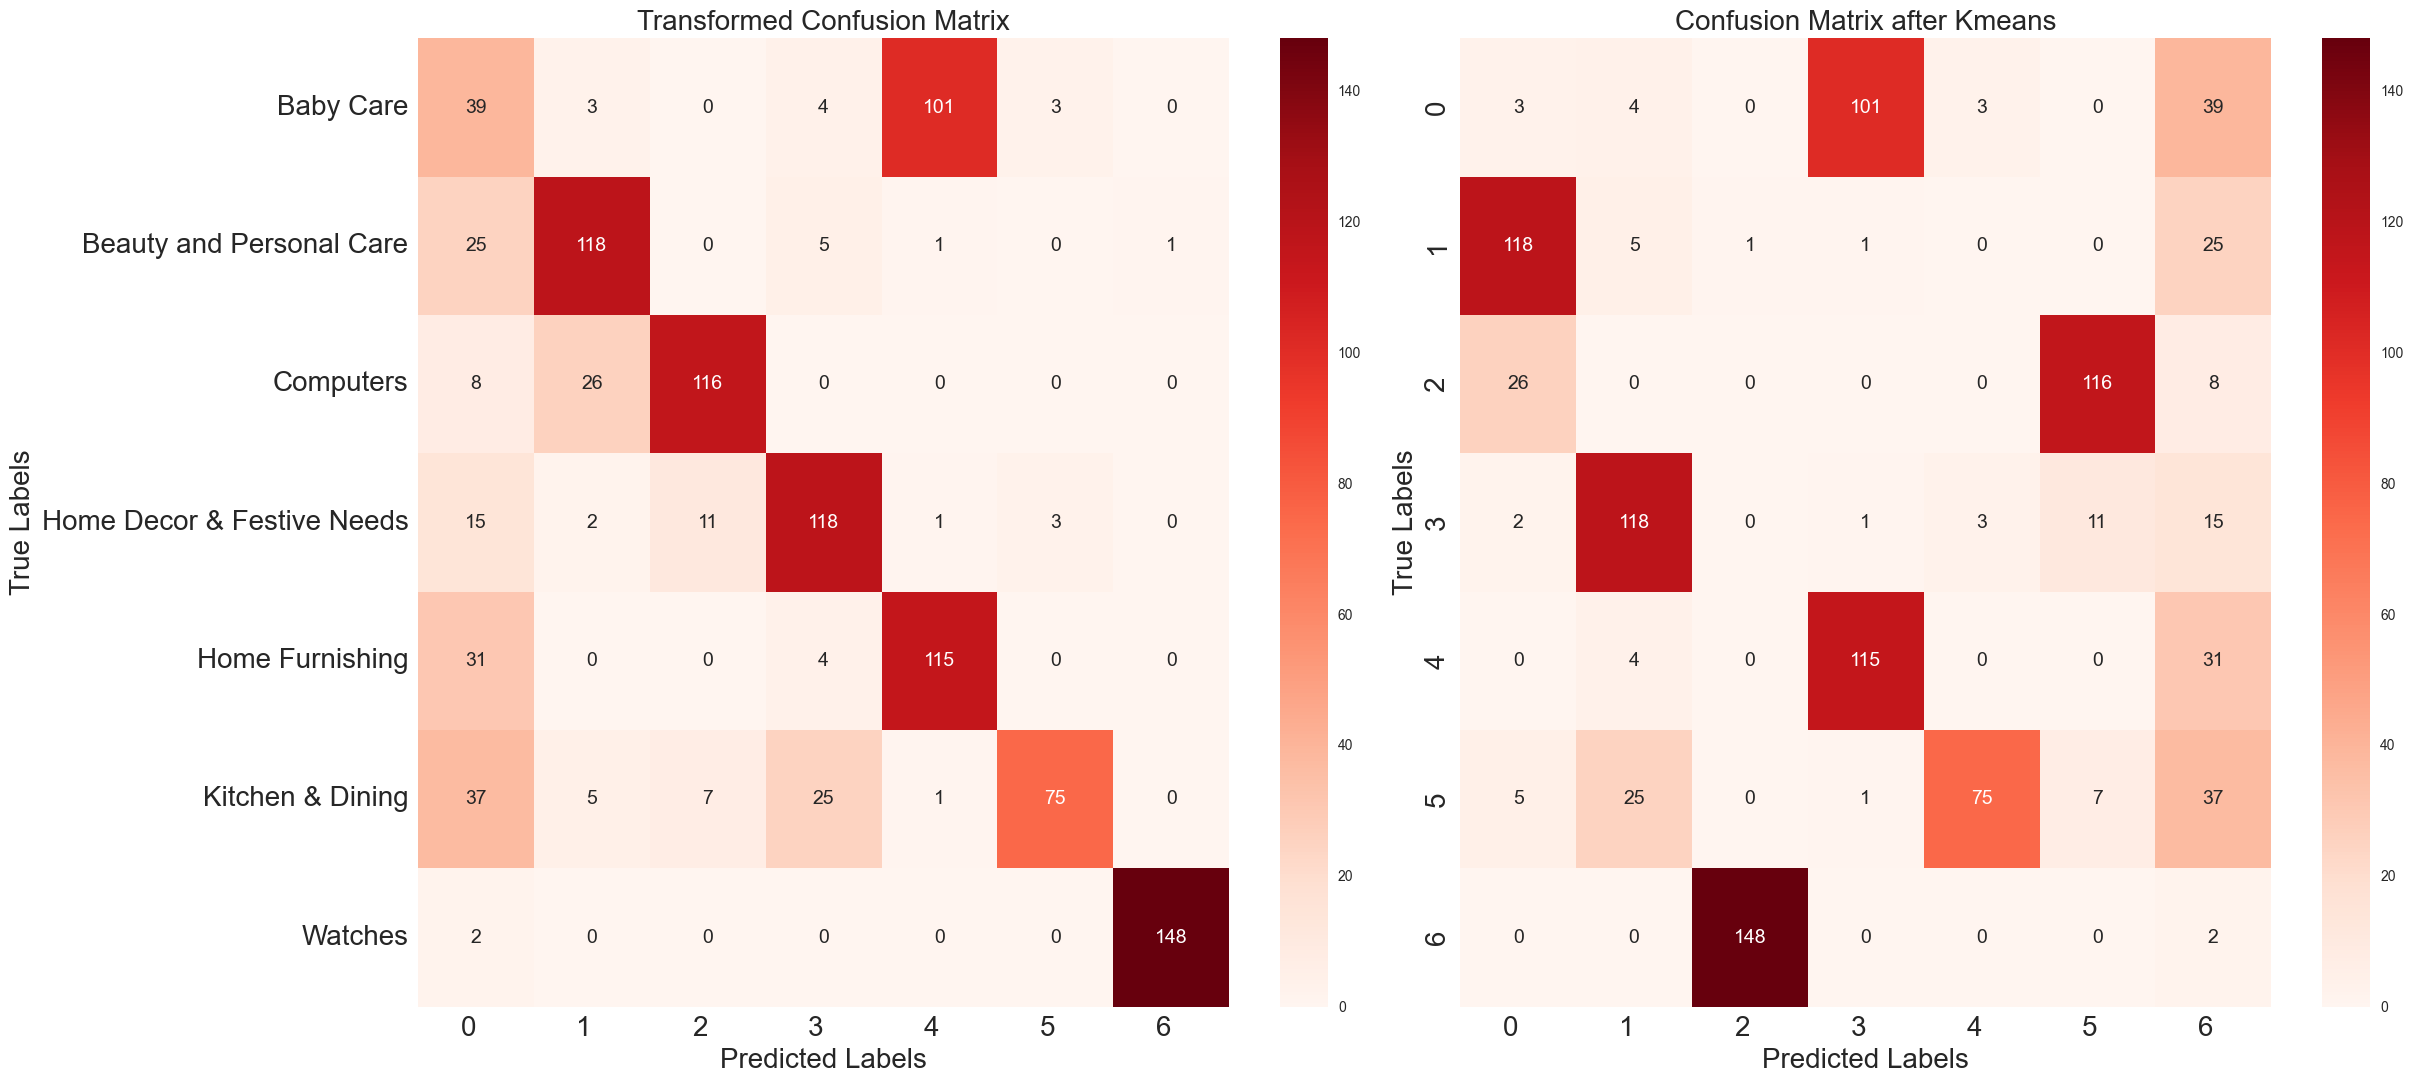

              precision    recall  f1-score   support

           0       0.25      0.26      0.25       150
           1       0.77      0.79      0.78       150
           2       0.87      0.77      0.82       150
           3       0.76      0.79      0.77       150
           4       0.53      0.77      0.62       150
           5       0.93      0.50      0.65       150
           6       0.99      0.99      0.99       150

    accuracy                           0.69      1050
   macro avg       0.73      0.69      0.70      1050
weighted avg       0.73      0.69      0.70      1050



In [34]:
def remove_duplicate(arr):
    count_dict = {}
    
    for num in arr:
        count_dict[num] = count_dict.get(num, 0) + 1

    missing_number = next(x for x in range(len(arr) + 1) if x not in count_dict)

    replaced_second_occurrence = False
    result_array = []

    for num in np.flip(arr):
        if count_dict[num] > 1 and not replaced_second_occurrence:
            result_array.append(missing_number)
            replaced_second_occurrence = True
        else:
            result_array.append(num)

    return np.flip(result_array)

def conf_mat_transform(df_tsne):
    y_true = df_tsne.category_encoded
    y_pred = df_tsne.Kmeans_cluster

    # Step 1: Compute the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    print(conf_mat)
    
    # Step 2: Find the correspondence between clusters
    corresp = np.argmax(conf_mat, axis=0)
    print('corresp: ' + str(corresp))

    # If corresp has repeating numbers, use linear_sum_assignment
    if len(np.unique(corresp)) != len(corresp):
        corresp = remove_duplicate(corresp)
    
    # Step 3: Transform predicted labels based on correspondence
    y_pred_transform = y_pred.apply(lambda x : corresp[x]) 
    #y_pred_transform = corresp[y_pred]

    # Add the 'Transformed_Cluster' column to df_tsne
    df_tsne['Transformed_Cluster'] = y_pred_transform

    # Rearrange the confusion matrix to have maximum values on the diagonal
    #conf_mat_transf = rearrange_confusion_matrix(confusion_matrix(y_true, y_pred_transform))
    conf_mat_transf = confusion_matrix(y_true, y_pred_transform)
    
    unique_values, unique_indices = np.unique(y_pred_transform, return_index=True)
    # Sort by the order of appearance
    sorted_indices = np.argsort(unique_indices)

    
    # Convert sorted_indices to a list
    #sorted_indices_list = list(sorted_indices)
    sorted_indices_list = [0, 1, 2, 3, 4, 5, 6]
    # Use sorted with a custom key function
    category_name = [key for key, value in sorted(category_dict.items(), key=lambda x: sorted_indices_list.index(x[1]))]

    df_cm_transf = pd.DataFrame(conf_mat_transf, index=category_name, columns=sorted_indices_list)

    fig, axes = plt.subplots(1, 2, figsize=(25, 11))

    # Heatmap for the transformed confusion matrix
    cm1 = sns.heatmap(df_cm_transf, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 14}, ax=axes[0])
    axes[0].set_title('Transformed Confusion Matrix', fontsize=20)
    axes[0].set_xlabel('Predicted Labels', fontsize=20)
    axes[0].set_ylabel('True Labels', fontsize=20)

    # Adjusting category names on the x-axis and y-axis
    axes[0].set_xticklabels(axes[0].get_xticklabels(), ha="right", fontsize=20)
    axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=20)

    # Heatmap for the confusion matrix after Kmeans
    cm2 = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 14}, ax=axes[1])
    axes[1].set_title('Confusion Matrix after Kmeans', fontsize=20)
    axes[1].set_xlabel('Predicted Labels', fontsize=20)
    axes[1].set_ylabel('True Labels', fontsize=20)
    # Adjusting category names on the x-axis and y-axis
    axes[1].set_xticklabels(axes[1].get_xticklabels(), ha="right", fontsize=20)
    axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=20)

    plt.tight_layout()
    plt.show()

    # Classification report:
    print(classification_report(df_tsne.category_encoded, df_tsne.Transformed_Cluster))

    return df_cm_transf, df_tsne, category_name, sorted_indices

df_cm_transf, df_tsne, category_name, sorted_indices = conf_mat_transform(df_tsne)


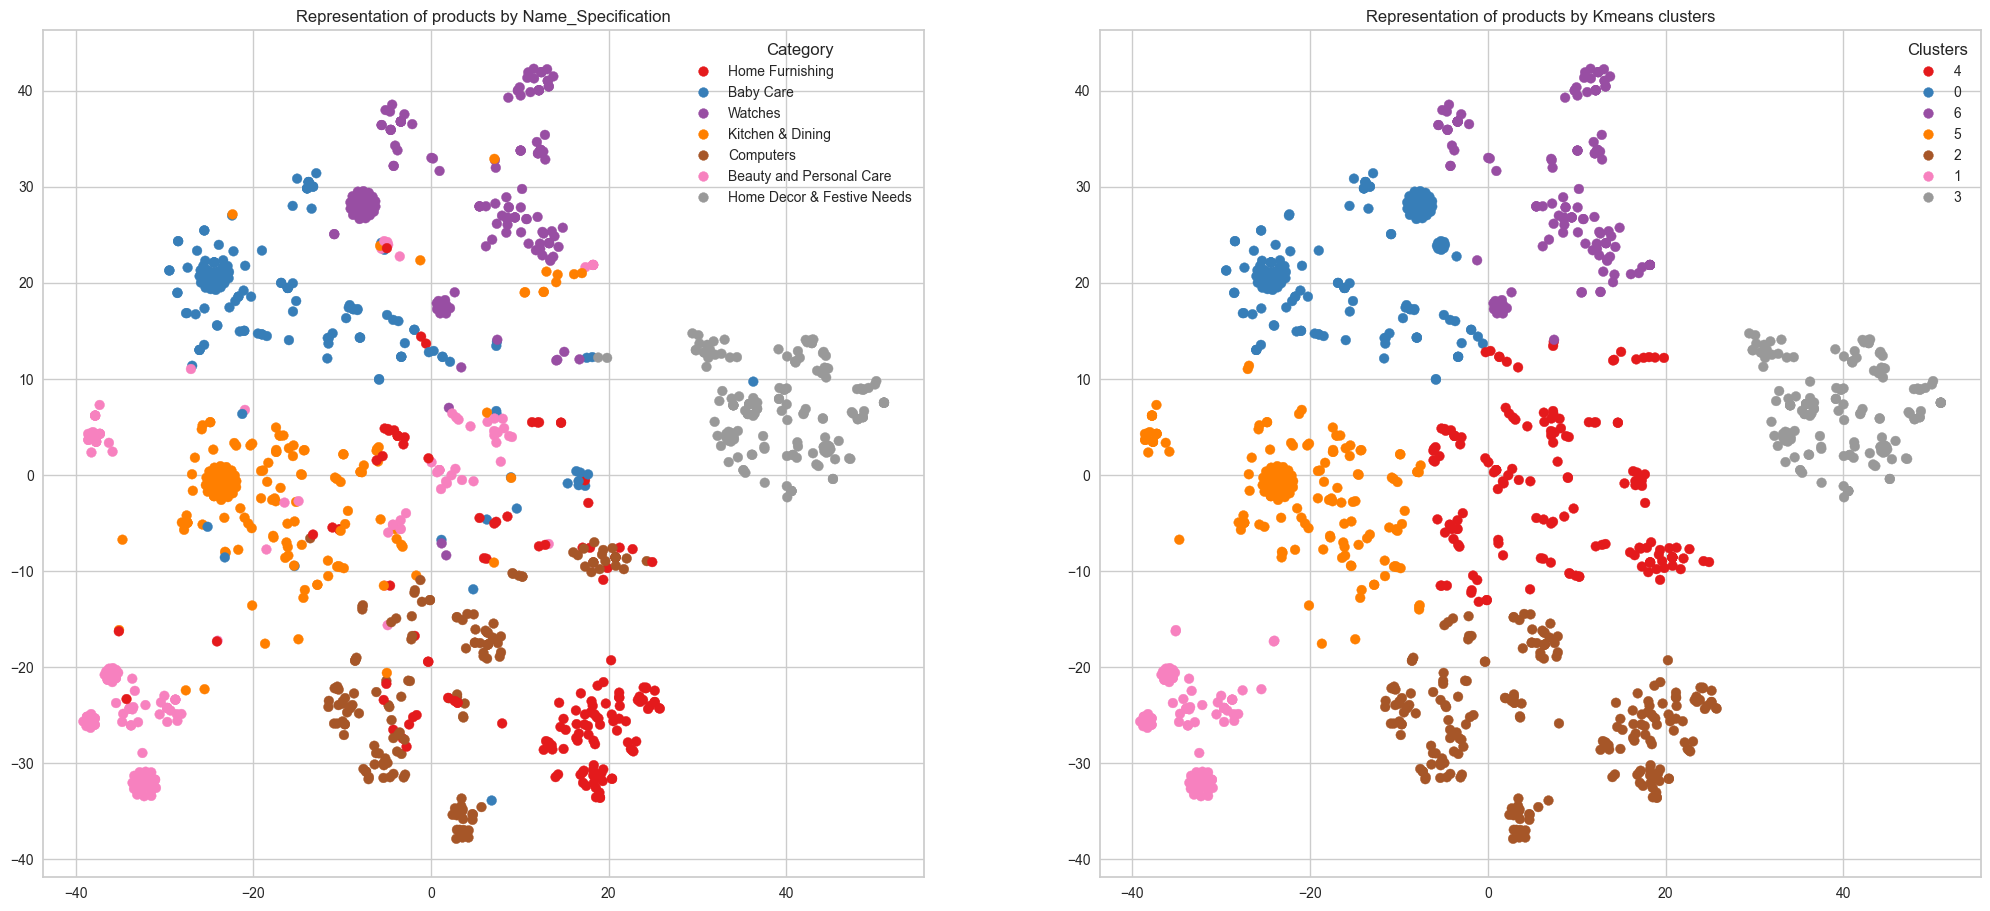

ARI:  0.54  /  SILOUHETTE:  0.48


In [35]:
# Visualize TSNE visualization based on true categories and cluster numbers
def TSNE_visualization(X_tsne, category_reindexed, df_tsne, ARI, SILOUHETTE, text_Column):
    fig = plt.figure(figsize=(25, 11))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_tsne.category_encoded, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=category_reindexed, loc="best", title="Category")
    plt.title('Representation of products by ' + text_Column)

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_tsne['Transformed_Cluster'], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=list(df_tsne.Transformed_Cluster.unique()), loc="best", title="Clusters")
    plt.title('Representation of products by Kmeans clusters')

    plt.show()
    print("ARI: ", ARI, " / ", "SILOUHETTE: ", SILOUHETTE)

category_reindexed = [key for key, value in sorted(category_dict.items(), key=lambda x: list(df_tsne.Transformed_Cluster.unique()).index(x[1]))]

# Now, use the modified df_tsne for the t-SNE visualization
TSNE_visualization(X_tsne, category_reindexed, df_tsne, ARI, SILOUHETTE, columns_to_process[0])


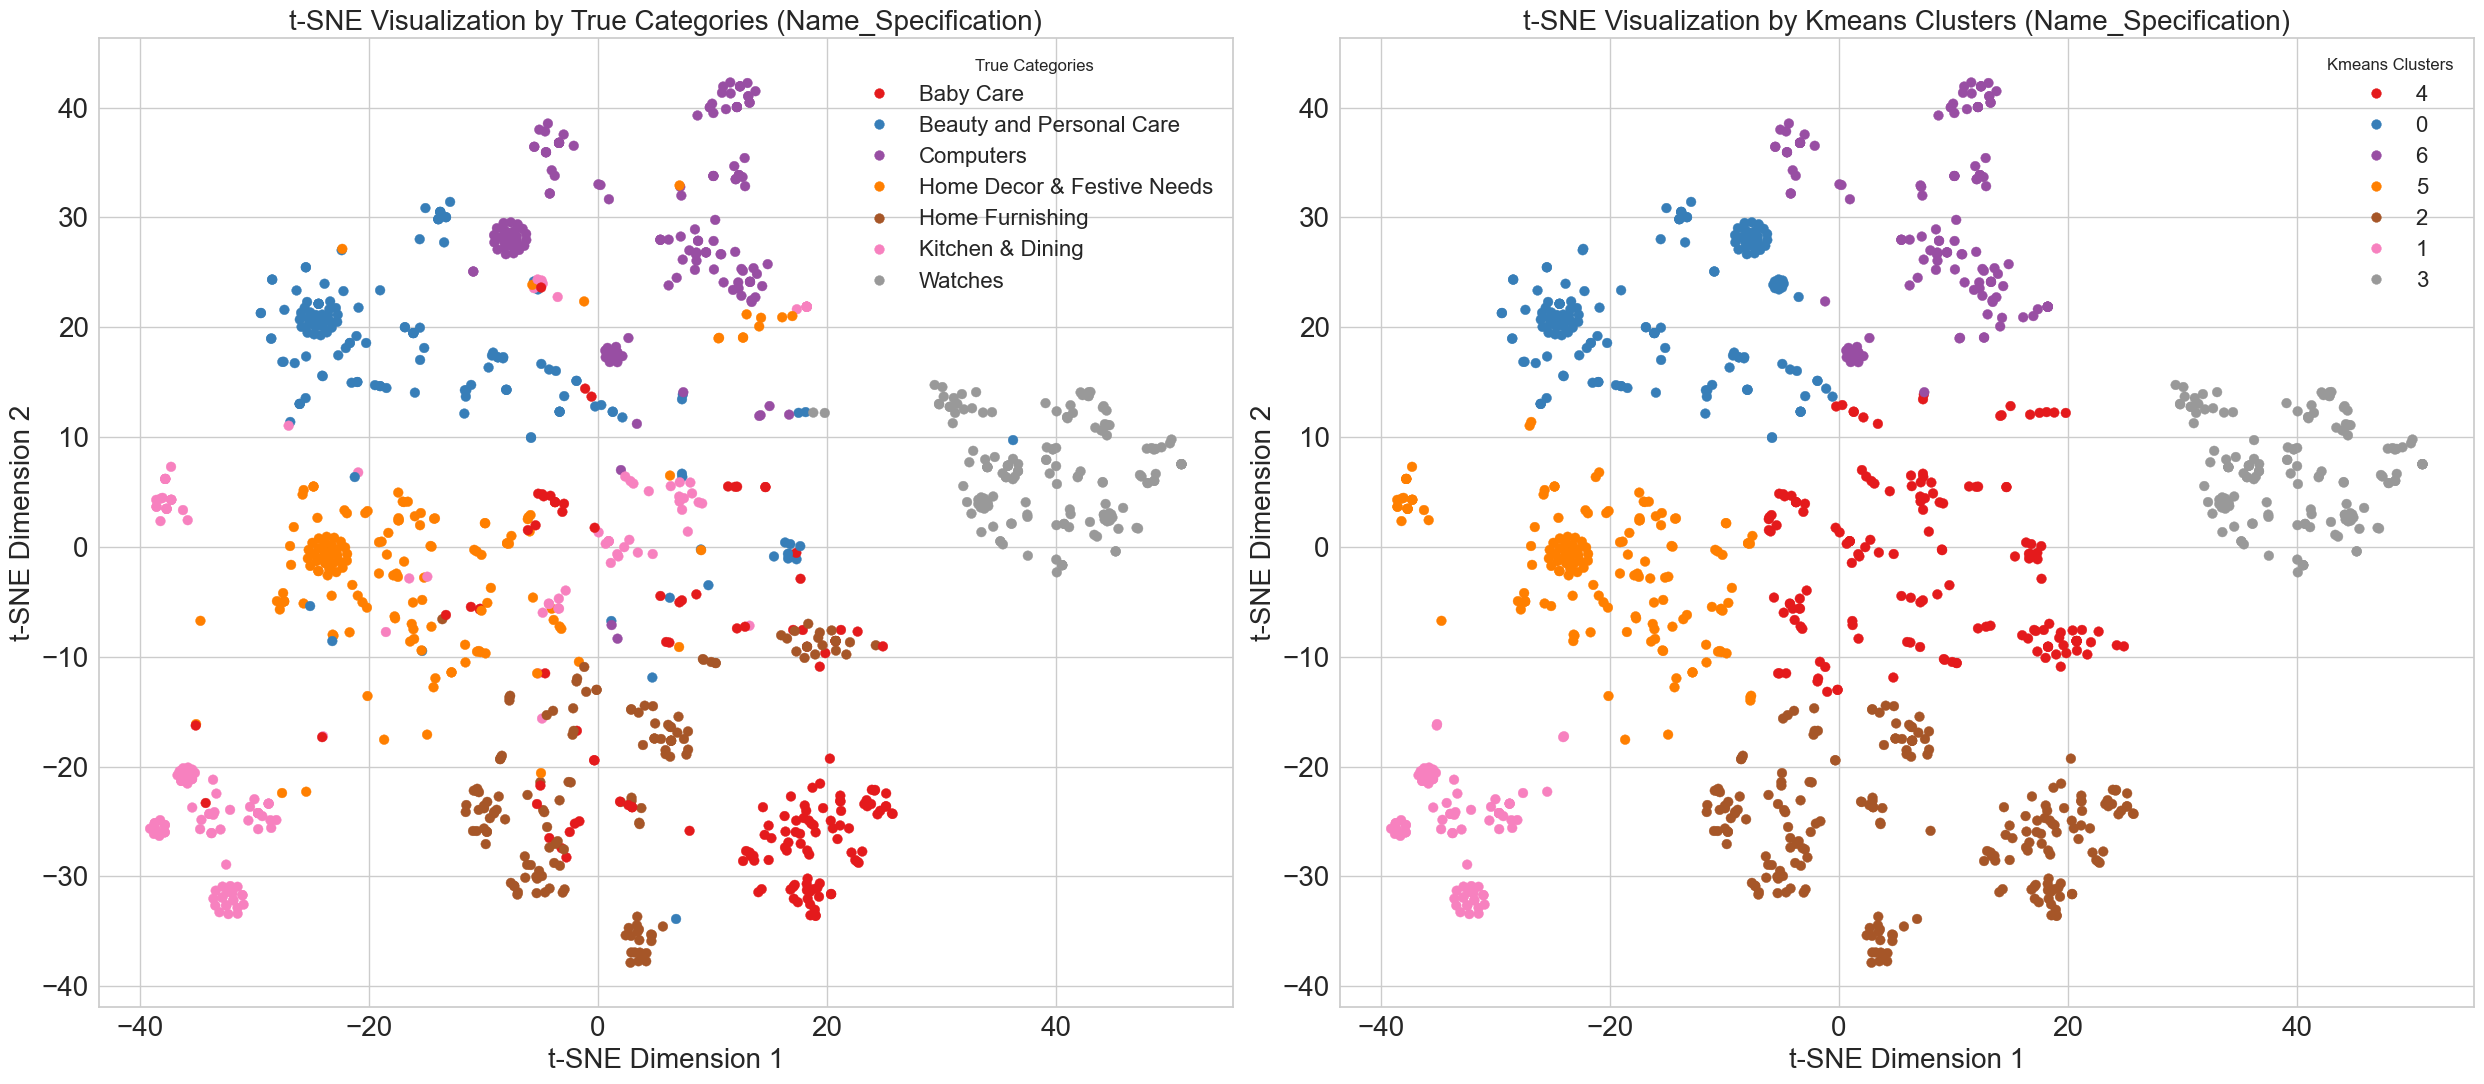

ARI: 0.54  /  SILOUETTE: 0.48


In [36]:
# Visualize TSNE visualization based on true categories and cluster numbers
def TSNE_visualization(X_tsne, category_reindexed, df_tsne, ARI, SILOUETTE, text_Column):
    fig, axes = plt.subplots(1, 2, figsize=(25, 11))

    # Plot for Category
    scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_tsne.category_encoded, cmap='Set1')
    axes[0].legend(handles=scatter1.legend_elements()[0], labels=category_reindexed, loc="best", title="True Categories",fontsize=16)
    axes[0].set_xlabel('t-SNE Dimension 1', fontsize=20)
    axes[0].set_title('t-SNE Visualization by True Categories (' + text_Column + ')', fontsize=20)
    axes[0].set_xlabel('t-SNE Dimension 1', fontsize=20)
    axes[0].set_xlabel('t-SNE Dimension 1', fontsize=20)
    axes[0].set_ylabel('t-SNE Dimension 2', fontsize=20)
    axes[0].tick_params(axis='both', labelsize=20)

    # Plot for Clusters
    scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_tsne['Transformed_Cluster'], cmap='Set1')
    axes[1].legend(handles=scatter2.legend_elements()[0], labels=list(df_tsne.Transformed_Cluster.unique()), loc="best", title="Kmeans Clusters", fontsize=16)
    axes[0].set_xlabel('t-SNE Dimension 1', fontsize=20)
    axes[1].set_title('t-SNE Visualization by Kmeans Clusters (' + text_Column + ')', fontsize=20)
    axes[0].set_xlabel('t-SNE Dimension 1', fontsize=20)
    axes[1].set_xlabel('t-SNE Dimension 1', fontsize=20)
    axes[1].set_ylabel('t-SNE Dimension 2', fontsize=20)
    axes[1].tick_params(axis='both', labelsize=20)

    plt.tight_layout()
    plt.show()
    
    print("ARI:", ARI, " / ", "SILOUETTE:", SILOUETTE)


# Utilisation de la fonction modifiée
#category_reindexed = [key for key, value in sorted(category_dict.items(), key=lambda x: list(df_tsne.Transformed_Cluster.unique()).index(x[1]))]
TSNE_visualization(X_tsne, category_name, df_tsne, ARI, SILOUHETTE, columns_to_process[0])


In [37]:
category_dict

{'Home Furnishing': 4,
 'Baby Care': 0,
 'Watches': 6,
 'Home Decor & Festive Needs': 3,
 'Kitchen & Dining': 5,
 'Beauty and Personal Care': 1,
 'Computers': 2}

In [38]:
df_scores = pd.DataFrame(columns=['Analysis', 'Corpus', 'ARI', 'SILOUHETTE', 'Time (s)'])

The features matrix is sparse. Going to run Truncated SVD!
(1050, 369)
248
Explained variance ratio: 0.99
ARI:  0.65 SILOUHETTE:  0.54 time:  688.0
The features matrix is sparse. Going to run Truncated SVD!
(1050, 369)
269
Explained variance ratio: 0.99
ARI:  0.58 SILOUHETTE:  0.51 time:  748.0
The features matrix is sparse. Going to run Truncated SVD!
(1050, 414)
242
Explained variance ratio: 0.99
ARI:  0.5 SILOUHETTE:  0.52 time:  690.0
The features matrix is sparse. Going to run Truncated SVD!
(1050, 414)
273
Explained variance ratio: 0.99
ARI:  0.51 SILOUHETTE:  0.49 time:  700.0
The features matrix is sparse. Going to run Truncated SVD!
(1050, 586)
326
Explained variance ratio: 0.99
ARI:  0.62 SILOUHETTE:  0.53 time:  818.0
The features matrix is sparse. Going to run Truncated SVD!
(1050, 586)
378
Explained variance ratio: 0.99
ARI:  0.58 SILOUHETTE:  0.52 time:  873.0
ARI score optimal for: Name_Specification CountVectorizer
[[  1 108   4  17  12   0   8]
 [  0   0   4   8   1   

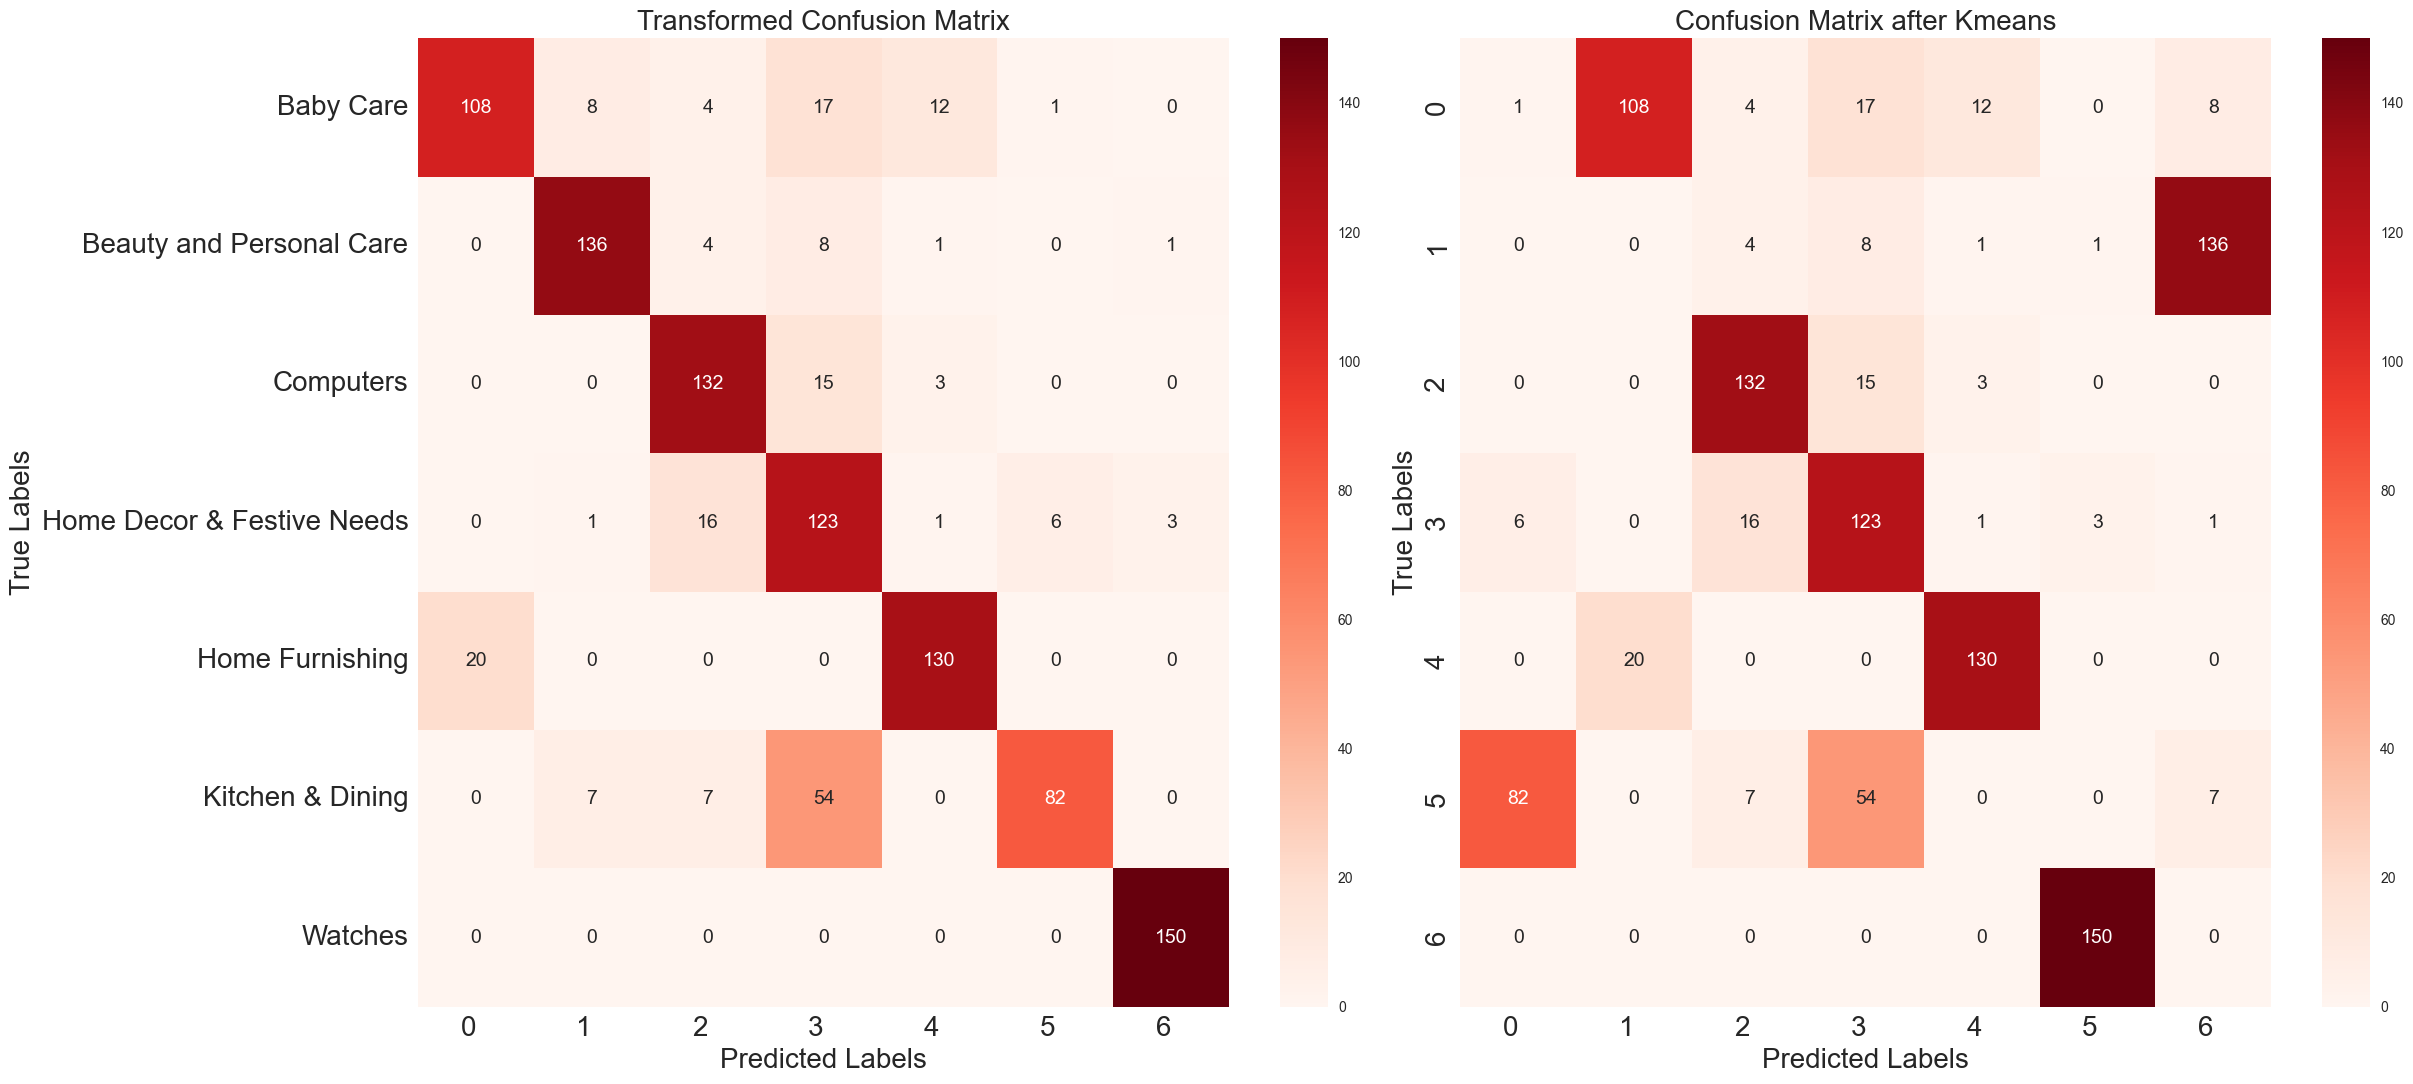

              precision    recall  f1-score   support

           0       0.84      0.72      0.78       150
           1       0.89      0.91      0.90       150
           2       0.81      0.88      0.84       150
           3       0.57      0.82      0.67       150
           4       0.88      0.87      0.88       150
           5       0.92      0.55      0.69       150
           6       0.97      1.00      0.99       150

    accuracy                           0.82      1050
   macro avg       0.84      0.82      0.82      1050
weighted avg       0.84      0.82      0.82      1050



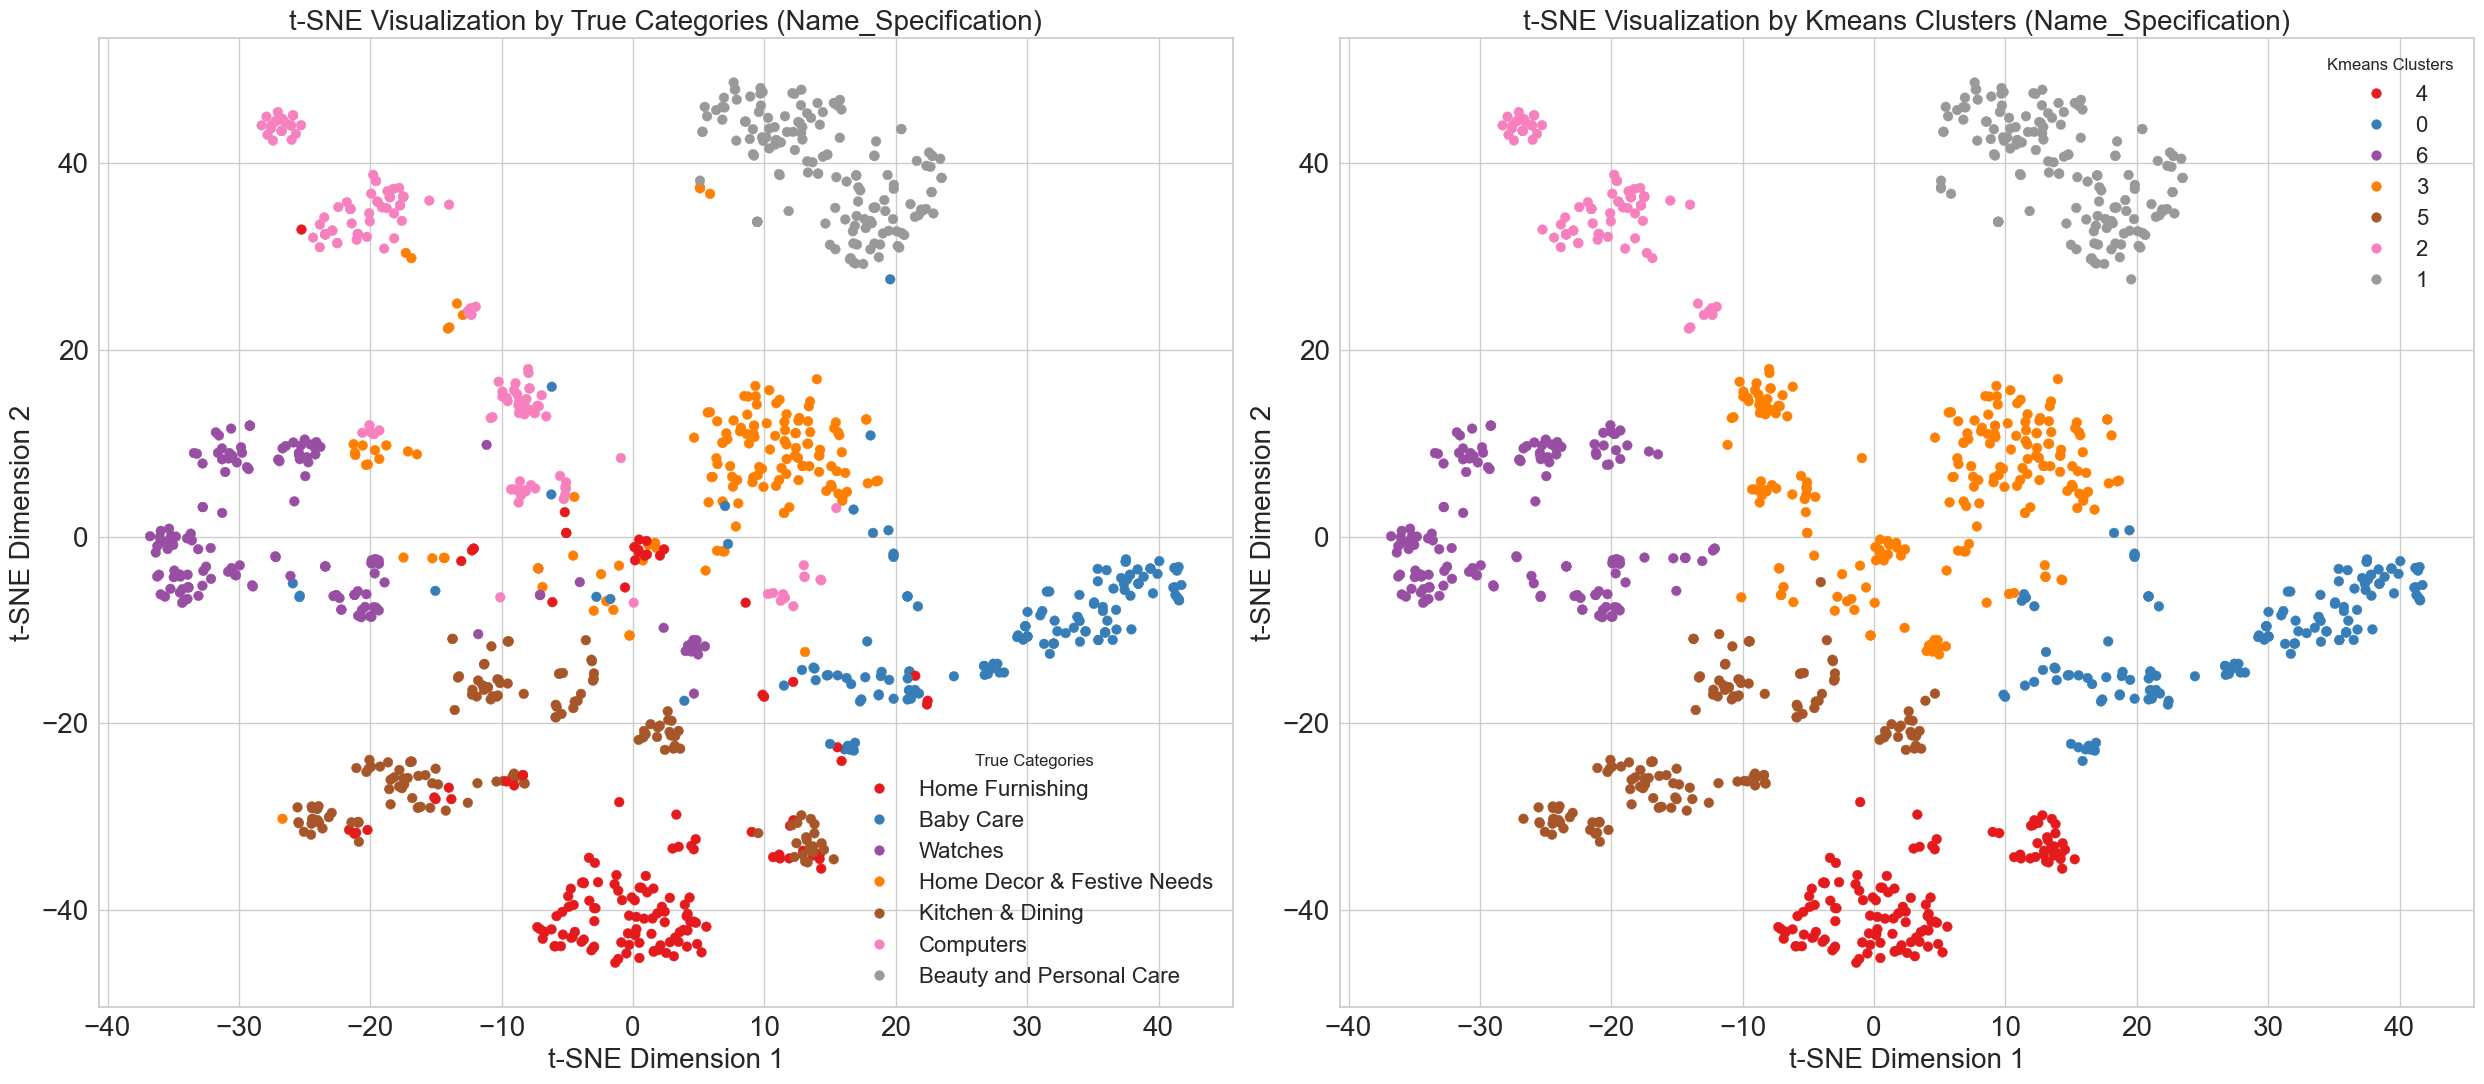

ARI: 0.58  /  SILOUETTE: 0.52


In [39]:
Vectorization = ['CountVectorizer', 'TfidfVectorizer']

best_ari = -1  # Initialize with a low value
best_params = None

for text_Column, Vect_Method in itertools.product(columns_to_process, Vectorization):
    time1 = time.time()
    features, _ = vectorize_text(df_cleaned, text_Column, Vect_Method)
    X_reduction = SVD_Runner(features)
    X_tsne, df_tsne = apply_tsne(X_reduction, tsne_params=None)
    ARI, SILOUHETTE, kmeans_labels = Kmeans_Metrics(X_tsne, num_clusters=len(real_categories))
    time2 = np.round(time.time() - time1, 0)

    print("ARI: ", str(ARI), "SILOUHETTE: ", str(SILOUHETTE), "time: ", str(time2))

    # Update df_scores
    df_scores = df_scores.append({'Analysis': Vect_Method,
                                  'Corpus': text_Column,
                                  'ARI': ARI,
                                  'SILOUHETTE': SILOUHETTE,
                                  'Time (s)': time2},
                                 ignore_index=True)

    # Check if the current ARI is the best
    if ARI > best_ari:
        best_ari = ARI
        best_params = {'text_Column': text_Column, 'Vect_Method': Vect_Method, 'X_reduction': X_reduction, 'kmeans_labels': kmeans_labels}

# Plot only for the best ARI
if best_params is not None:
    text_Column = best_params['text_Column']
    Vect_Method = best_params['Vect_Method']
    X_reduction = best_params['X_reduction']
    print('ARI score optimal for: {} {}'.format(text_Column, Vect_Method))
    kmeans_labels = best_params['kmeans_labels']

    # Plot t-SNE visualization
    X_tsne, df_tsne = apply_tsne(X_reduction, tsne_params=None)

    df_tsne["category"] = df_cleaned["subcategory_1"]
    df_tsne["category_encoded"] = df_cleaned["category_encoded"]
    df_tsne["Kmeans_cluster"] = kmeans_labels

    # Plot confusion matrix
    df_cm_transf, df_tsne, category_name, sorted_indices= conf_mat_transform(df_tsne)
    category_reindexed = [key for key, value in sorted(category_dict.items(), key=lambda x: list(df_tsne.Transformed_Cluster.unique()).index(x[1]))]

    # Now, use the modified df_tsne for the t-SNE visualization
    TSNE_visualization(X_tsne, category_reindexed, df_tsne, ARI, SILOUHETTE, columns_to_process[0])

In [40]:
df_scores

Analysis                          Corpus   ARI  SILOUHETTE  Time (s)
0  CountVectorizer              Name_Specification  0.65        0.54     688.0
1  TfidfVectorizer              Name_Specification  0.58        0.51     748.0
2  CountVectorizer                Name_Description  0.50        0.52     690.0
3  TfidfVectorizer                Name_Description  0.51        0.49     700.0
4  CountVectorizer  Name_Description_Specification  0.62        0.53     818.0
5  TfidfVectorizer  Name_Description_Specification  0.58        0.52     873.0

## Word/sentence embedding classique: Word2Vec

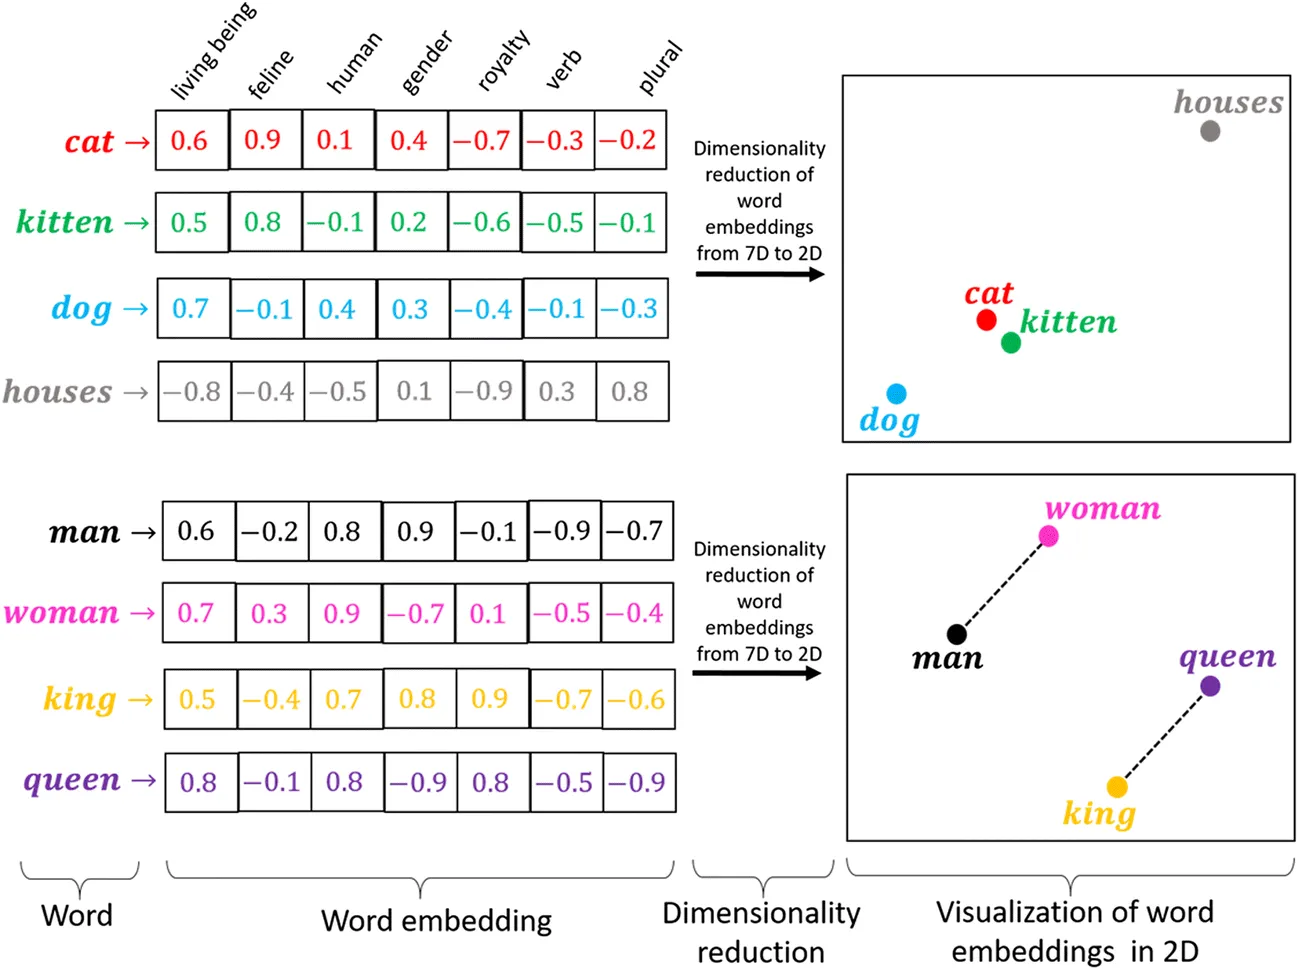

In [41]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from transformers import TFAutoModel, AutoTokenizer
import gensim

tokenizer = Tokenizer()


Model Word2Vec

* calculate the length of each tokenized sentence in the sentences list.
* determine the optimal maximum length (optimal_maxlen) by taking the 99th percentile of the sentence lengths. This is done to ensure that very long sentences don't dominate the model training.

In [42]:
print('column to process: ' + columns_to_process[2])

def calculate_optimal_maxlen(df, column):

    # Extract and preprocess text data
    sentences = df[column].tolist()
    sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
    print('Number of sentences:' + str(len(sentences)))

    # Calculate sentence lengths
    sentence_lengths = [len(sentence) for sentence in sentences]

    # Calculate max sentence length and add a buffer
    max_sentence_length = max(len(sentence) for sentence in sentences)
    buffer_size = 0
    optimal_maxlen = max_sentence_length + buffer_size
    
    print('optimal_maxlen: ' + str(optimal_maxlen))

    return optimal_maxlen, sentence_lengths, sentences

optimal_maxlen, sentence_lengths, sentences = calculate_optimal_maxlen(df_cleaned, columns_to_process[1])


column to process: Name_Description_Specification
Number of sentences:1050
optimal_maxlen: 295


In [43]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epoch = 100
max_len = optimal_maxlen

workers=multiprocessing.cpu_count(): workers is set to the number of CPU cores available, and it determines how many parallel processes the Word2Vec model should use during training. This can lead to faster training times, especially on machines with multiple 

In [44]:
cpu_count = multiprocessing.cpu_count()

def train_w2v_model(sentences, w2v_min_count, w2v_window, w2v_size, w2v_epoch, cpu_count):

    # Initialize Word2Vec model
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window, vector_size=w2v_size, workers=cpu_count)

    # Build vocabulary
    w2v_model.build_vocab(sentences)

    # Train Word2Vec model
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epoch)

    # Get model vectors and vocabulary words
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key

    # Print Vocabulary Size
    print("Vocabulary size: %i" % len(w2v_words))

    # Print Word2Vec Training Completion
    print("Word2Vec trained")

    return w2v_model, model_vectors, w2v_words

w2v_model, model_vectors, w2v_words = train_w2v_model(sentences, w2v_min_count, w2v_window, w2v_size, w2v_epoch, cpu_count)

Vocabulary size: 4135
Word2Vec trained


In [45]:
def process_sentences(sentences, max_len, tokenizer):
    # Initialize and fit the Tokenizer on the sentences
    print("Fit Tokenizer ...")
    tokenizer.fit_on_texts(sentences)

    # Convert sentences to sequences and pad them
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=max_len, padding='post')

    # Get the number of unique words in the tokenizer's vocabulary
    num_words = len(tokenizer.word_index) + 1
    print("Number of unique words: %i" % num_words)

    return x_sentences, max_len

x_sentences, max_len = process_sentences(sentences, max_len, tokenizer)


Fit Tokenizer ...
Number of unique words: 4136


Create embedding matrix

In [46]:
def create_embedding_matrix(tokenizer, model_vectors, w2v_words):
    # Create the embedding matrix
    print("Create Embedding matrix ...")

    # Get the vocabulary size from the tokenizer's word index
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1

    # Initialize the embedding matrix with zeros
    embedding_matrix = np.zeros((vocab_size, w2v_size))

    # Loop through words in the tokenizer's vocabulary
    for word, idx in word_index.items():

        # Check if the word is present in the Word2Vec model
        if word in w2v_words:
            embedding_vector = model_vectors[word]

            # Check if the embedding vector is not None
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector

    # Calculate the word embedding rate
    word_rate = np.round(np.sum(embedding_matrix.sum(axis=1) > 0) / vocab_size, 4)

    # Print the word embedding rate and the shape of the embedding matrix
    print("Word embedding rate: ", word_rate)
    print("Embedding matrix shape: %s" % str(embedding_matrix.shape))

    return embedding_matrix, word_rate, vocab_size

# Création de la matrice d'embedding
embedding_matrix, word_rate, vocab_size = create_embedding_matrix(tokenizer, model_vectors, w2v_words)


Create Embedding matrix ...


Word embedding rate:  0.4809
Embedding matrix shape: (4136, 300)


Create embedding model

In [47]:
def embedding_model_maker(max_len, vocab_size, w2v_size, embedding_matrix):
    # Define the input layer for the model
    input_sentences = Input(shape=(max_len,), dtype='float64')

    # Define the embedding layer with pre-trained Word2Vec weights
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=w2v_size,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False  # Set to True if you want to fine-tune the embeddings
    )(input_sentences)

    # Apply Global Average Pooling 1D to reduce dimensionality
    pooled_output = GlobalAveragePooling1D()(embedding_layer)

    # Create the embedding model
    embedding_model = Model(inputs=[input_sentences], outputs=[pooled_output])

    # Print the summary of the embedding model
    embedding_model.summary()

    return embedding_model

# Create the embedding model
embedding_model = embedding_model_maker(optimal_maxlen, vocab_size, w2v_size, embedding_matrix)

# Predict embeddings for the filtered sentences
embeddings = embedding_model.predict(x_sentences)
#embeddings = embedding_model.predict(x_filtered)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 295)]             0         
                                                                 
 embedding (Embedding)       (None, 295, 300)          1240800   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,240,800
Trainable params: 0
Non-trainable params: 1,240,800
_________________________________________________________________
33/33 [==============================] - 2s 16ms/step


Run the model

In [48]:
embeddings.shape

(1050, 300)

In [49]:
print(embeddings)

[[ 0.00639353 -0.03423188 -0.07045675 ... -0.1121164  -0.04947935
   0.09740711]
 [ 0.03914322  0.00418593  0.02393176 ... -0.10252013  0.03081981
  -0.04142951]
 [-0.00405694  0.05689823  0.07257681 ... -0.12980431  0.08966237
  -0.01980686]
 ...
 [ 0.02743938 -0.03182187  0.02881314 ... -0.02287911 -0.01945654
  -0.03736269]
 [ 0.0233874  -0.05592757  0.02665771 ... -0.0151452  -0.02319986
  -0.03253449]
 [ 0.02135796 -0.02668078  0.01682562 ... -0.01314118 -0.00607436
  -0.02547118]]


In [50]:
#X_reduction = SVD_Runner(features)
X_tsne, df_tsne = apply_tsne(embeddings, tsne_params=None)


In [51]:
ARI, SILOUHETTE, kmeans_labels = Kmeans_Metrics(X_tsne, num_clusters=len(real_categories))


In [52]:
print('ARI: ' + str(ARI), 'SILOUHETTE: ' + str(SILOUHETTE))

ARI: 0.61 SILOUHETTE: 0.54


[[  9  87   7   0   6  39   2]
 [ 11   0 127   0   9   3   0]
 [137   1  12   0   0   0   0]
 [  9   0   0   3 122  12   4]
 [  0   0   0   0   1 149   0]
 [ 49   0   3   1   8  12  77]
 [  6   0   0 144   0   0   0]]
corresp: [2 0 1 6 3 4 5]


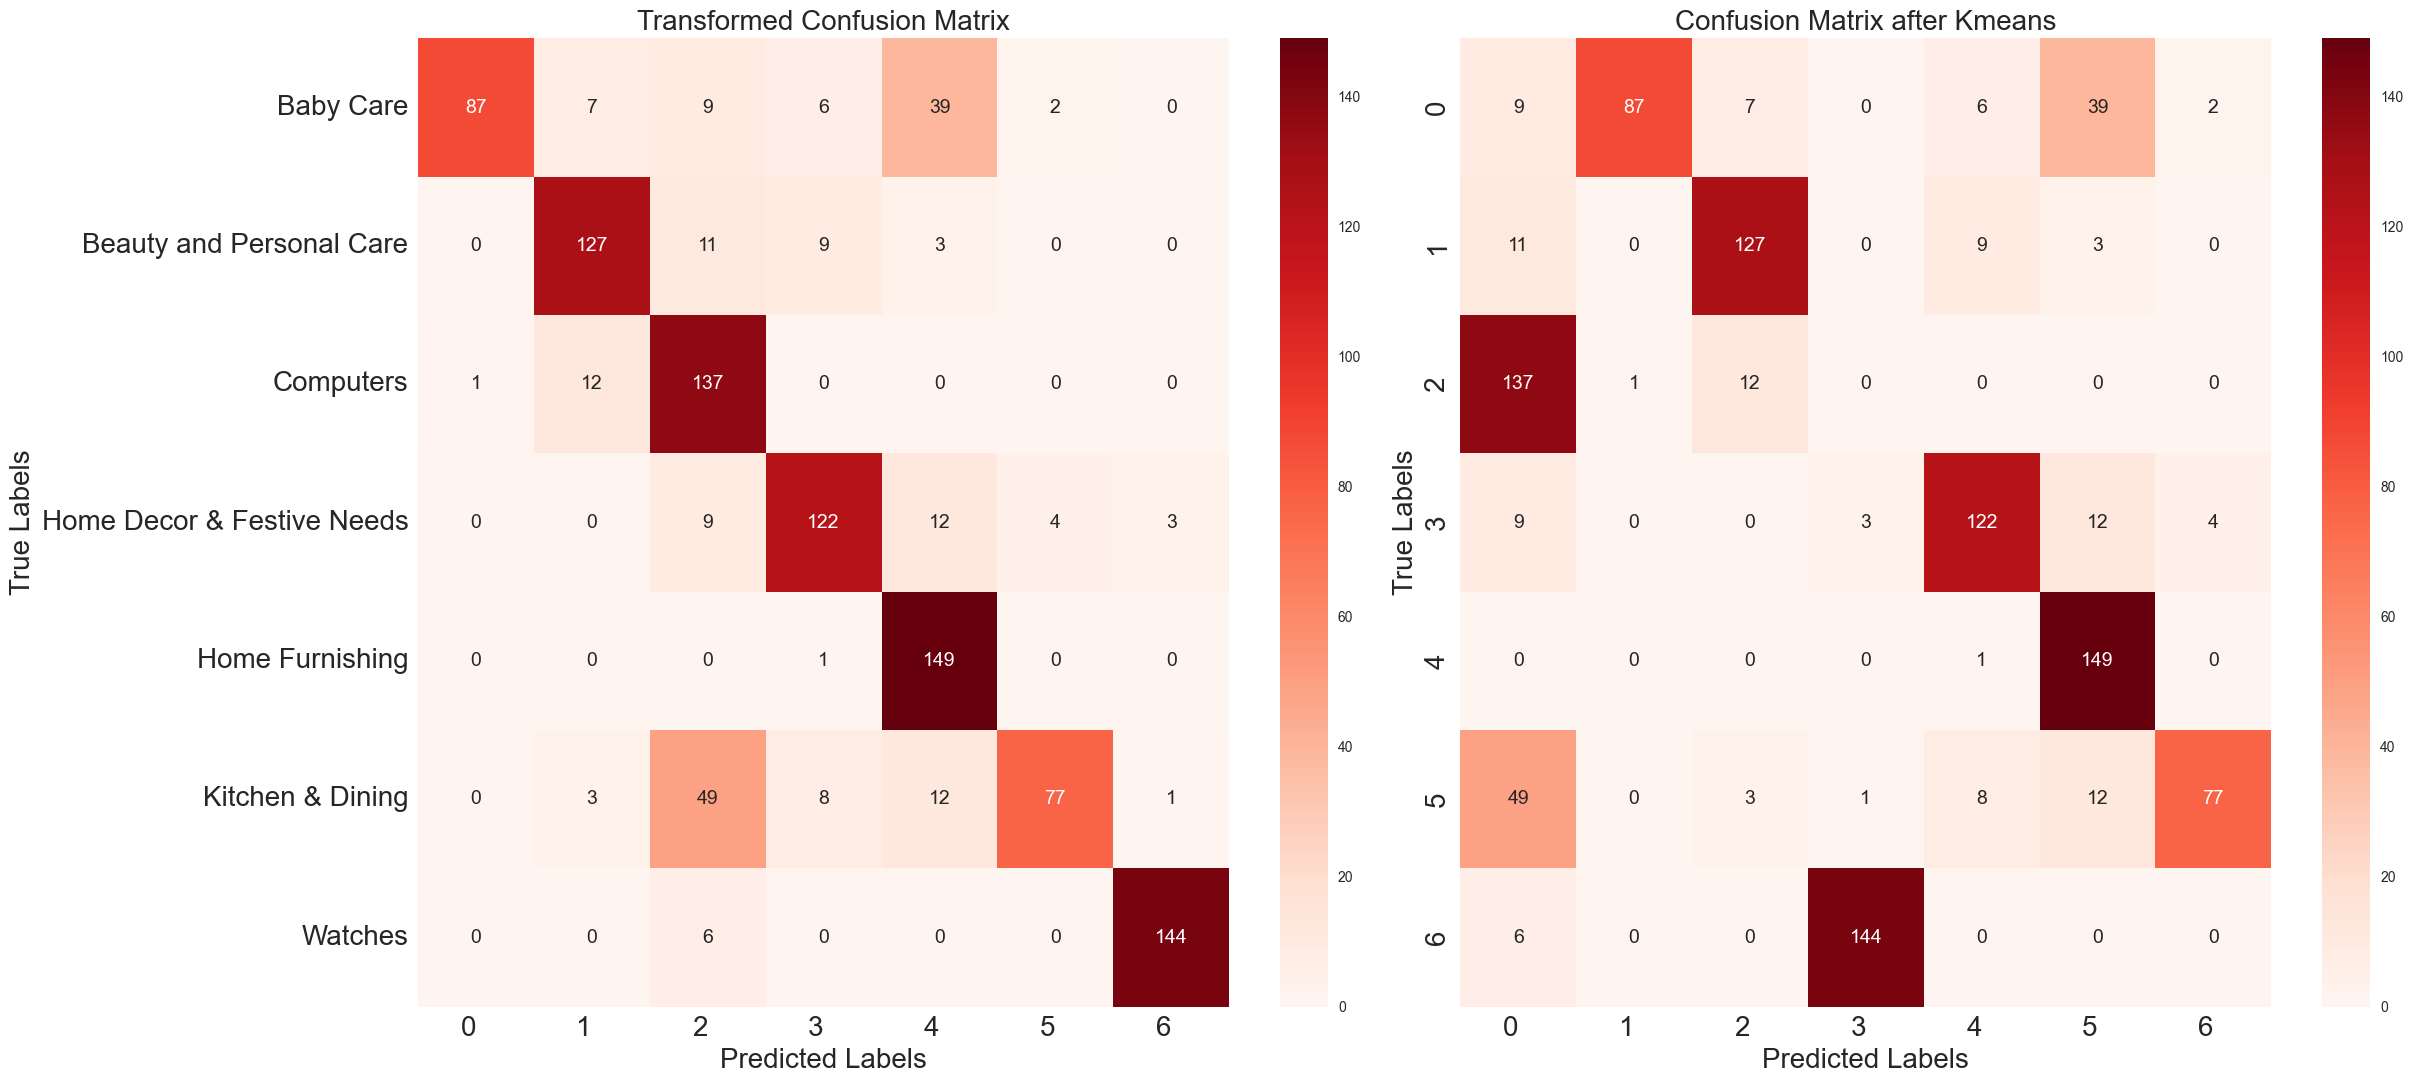

              precision    recall  f1-score   support

           0       0.99      0.58      0.73       150
           1       0.85      0.85      0.85       150
           2       0.62      0.91      0.74       150
           3       0.84      0.81      0.82       150
           4       0.69      0.99      0.82       150
           5       0.93      0.51      0.66       150
           6       0.97      0.96      0.97       150

    accuracy                           0.80      1050
   macro avg       0.84      0.80      0.80      1050
weighted avg       0.84      0.80      0.80      1050



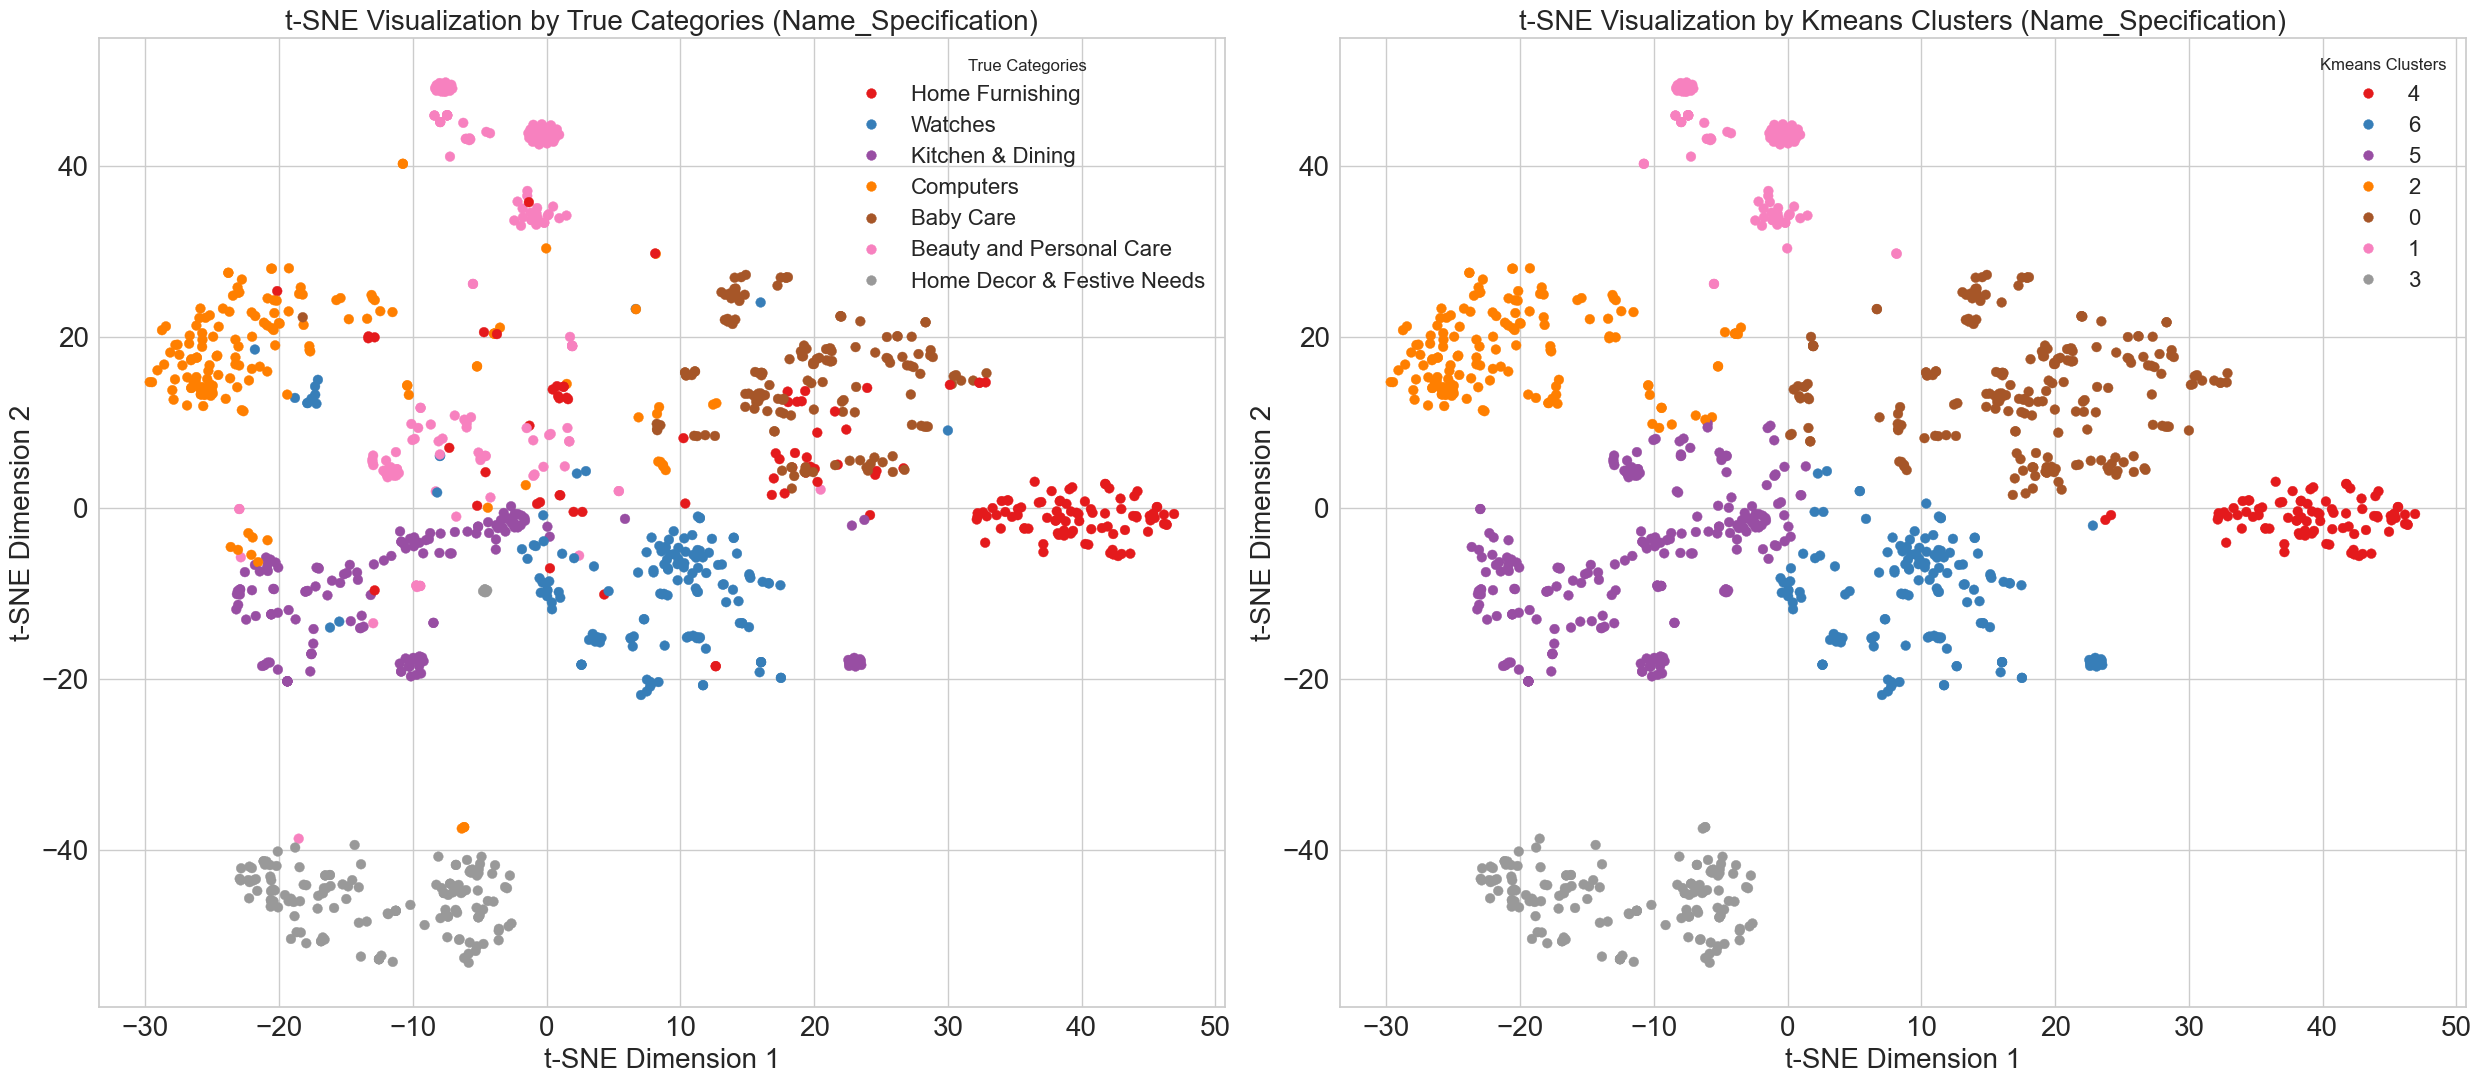

ARI: 0.61  /  SILOUETTE: 0.54


In [53]:
df_tsne["category"] = df_cleaned["subcategory_1"]
df_tsne["category_encoded"] = df_cleaned["category_encoded"]
df_tsne["Kmeans_cluster"] = kmeans_labels
# Plot confusion matrix
df_cm_transf, df_tsne, category_name, sorted_indices= conf_mat_transform(df_tsne)
category_reindexed = [key for key, value in sorted(category_dict.items(), key=lambda x: list(df_tsne.Transformed_Cluster.unique()).index(x[1]))]
# Now, use the modified df_tsne for the t-SNE visualization
TSNE_visualization(X_tsne, category_reindexed, df_tsne, ARI, SILOUHETTE, columns_to_process[0])

w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epoch = 100
max_len = optimal_maxlen

In [54]:
# Define the range of hyperparameters to search
w2v_sizes=[200, 300]
w2v_windows=[3, 5, 10]
w2v_min_counts=[10]
w2v_epochs=[100]

best_ari = -1  # Initialize with a low value
best_silhouette = -1  # Initialize with a low value
best_params = None
cpu_count = multiprocessing.cpu_count()


for text_Column, w2v_size, w2v_window, w2v_min_count, w2v_epoch in itertools.product(columns_to_process[::-1], w2v_sizes, w2v_windows, w2v_min_counts, w2v_epochs):
    print(text_Column, w2v_size, w2v_window, w2v_min_count, w2v_epoch)
    time1 = time.time()

    # calculate optimal maxlen
    optimal_maxlen, sentence_lengths, sentences = calculate_optimal_maxlen(df_cleaned, text_Column)

    print(f"Optimal maxlen for {text_Column}: {optimal_maxlen}")

    # Création et entraînement du modèle Word2Vec
    print("Build & train Word2Vec model ...")
    w2v_model, model_vectors, w2v_words = train_w2v_model(sentences, w2v_min_count, w2v_window, w2v_size, w2v_epoch, cpu_count)
    
    # Préparation des sentences (tokenization)
    
    x_sentences, max_len = process_sentences(sentences, optimal_maxlen, tokenizer)
    
    # Création de la matrice d'embedding
    embedding_matrix, word_rate, vocab_size = create_embedding_matrix(tokenizer, model_vectors, w2v_words)
    
    
    # Création du modèle
    embedding_model =  embedding_model_maker(max_len, vocab_size, w2v_size, embedding_matrix)

    embeddings = embedding_model.predict(x_sentences)
    print('embeddings.shape: ' + str(embeddings.shape))

    features = embeddings
    #X_reduction = SVD_Runner(features)
    X_tsne, df_tsne = apply_tsne(features, tsne_params=None)
    ARI, SILOUHETTE, kmeans_labels = Kmeans_Metrics(X_tsne, num_clusters=len(real_categories))
    time2 = np.round(time.time() - time1, 0)

    print("ARI: ", str(ARI), "SILOUHETTE: ", str(SILOUHETTE), "time: ", str(time2))

    # Update df_scores
    df_scores = df_scores.append({'Analysis': 'w2v_size: ' + str(w2v_size) + ' / w2v_window: ' + str(w2v_window) +
                                   ' / w2v_min_count: ' + str(w2v_min_count) + ' / w2v_epoch: ' + str(w2v_epoch) + ' / kmeans_labels: ' + str(kmeans_labels),
                                  'Corpus': text_Column,
                                  'ARI': ARI,
                                  'SILOUHETTE': SILOUHETTE,
                                  'Time (s)': time2},
                                 ignore_index=True)

    # Check if the current ARI is the best
    if ARI > best_ari:
        best_ari = ARI
        best_silhouette = SILOUHETTE
        best_params = {'text_Column': text_Column, 'w2v_size': w2v_size, 'w2v_window': w2v_window,
                       'w2v_min_count': w2v_min_count, 'w2v_epoch': w2v_epoch, 'kmeans_labels': kmeans_labels,
                       'X_tsne': X_tsne, 'df_tsne': df_tsne}


Name_Description_Specification 200 3 10 100


Number of sentences:1050
optimal_maxlen: 423
Optimal maxlen for Name_Description_Specification: 423
Build & train Word2Vec model ...
Vocabulary size: 1127
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 4830
Create Embedding matrix ...
Word embedding rate:  0.1195
Embedding matrix shape: (4830, 200)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 423)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 423, 200)          966000    
                                                                 
 global_average_pooling1d_1   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 966,000
Trainable params: 0
Non-trainable params: 966,000
_____

ARI score optimal for: Name_Description_Specification 200 3 10 100
[[ 15  90   0   1  30  14   0]
 [136   0   0   0   1  10   3]
 [  4  11   0   0   0   0 135]
 [ 10   0   1   0   0 126  13]
 [  0   0   0   0 149   1   0]
 [ 20   0   0  75   0  46   9]
 [  6   0 144   0   0   0   0]]
corresp: [1 0 6 5 4 3 2]


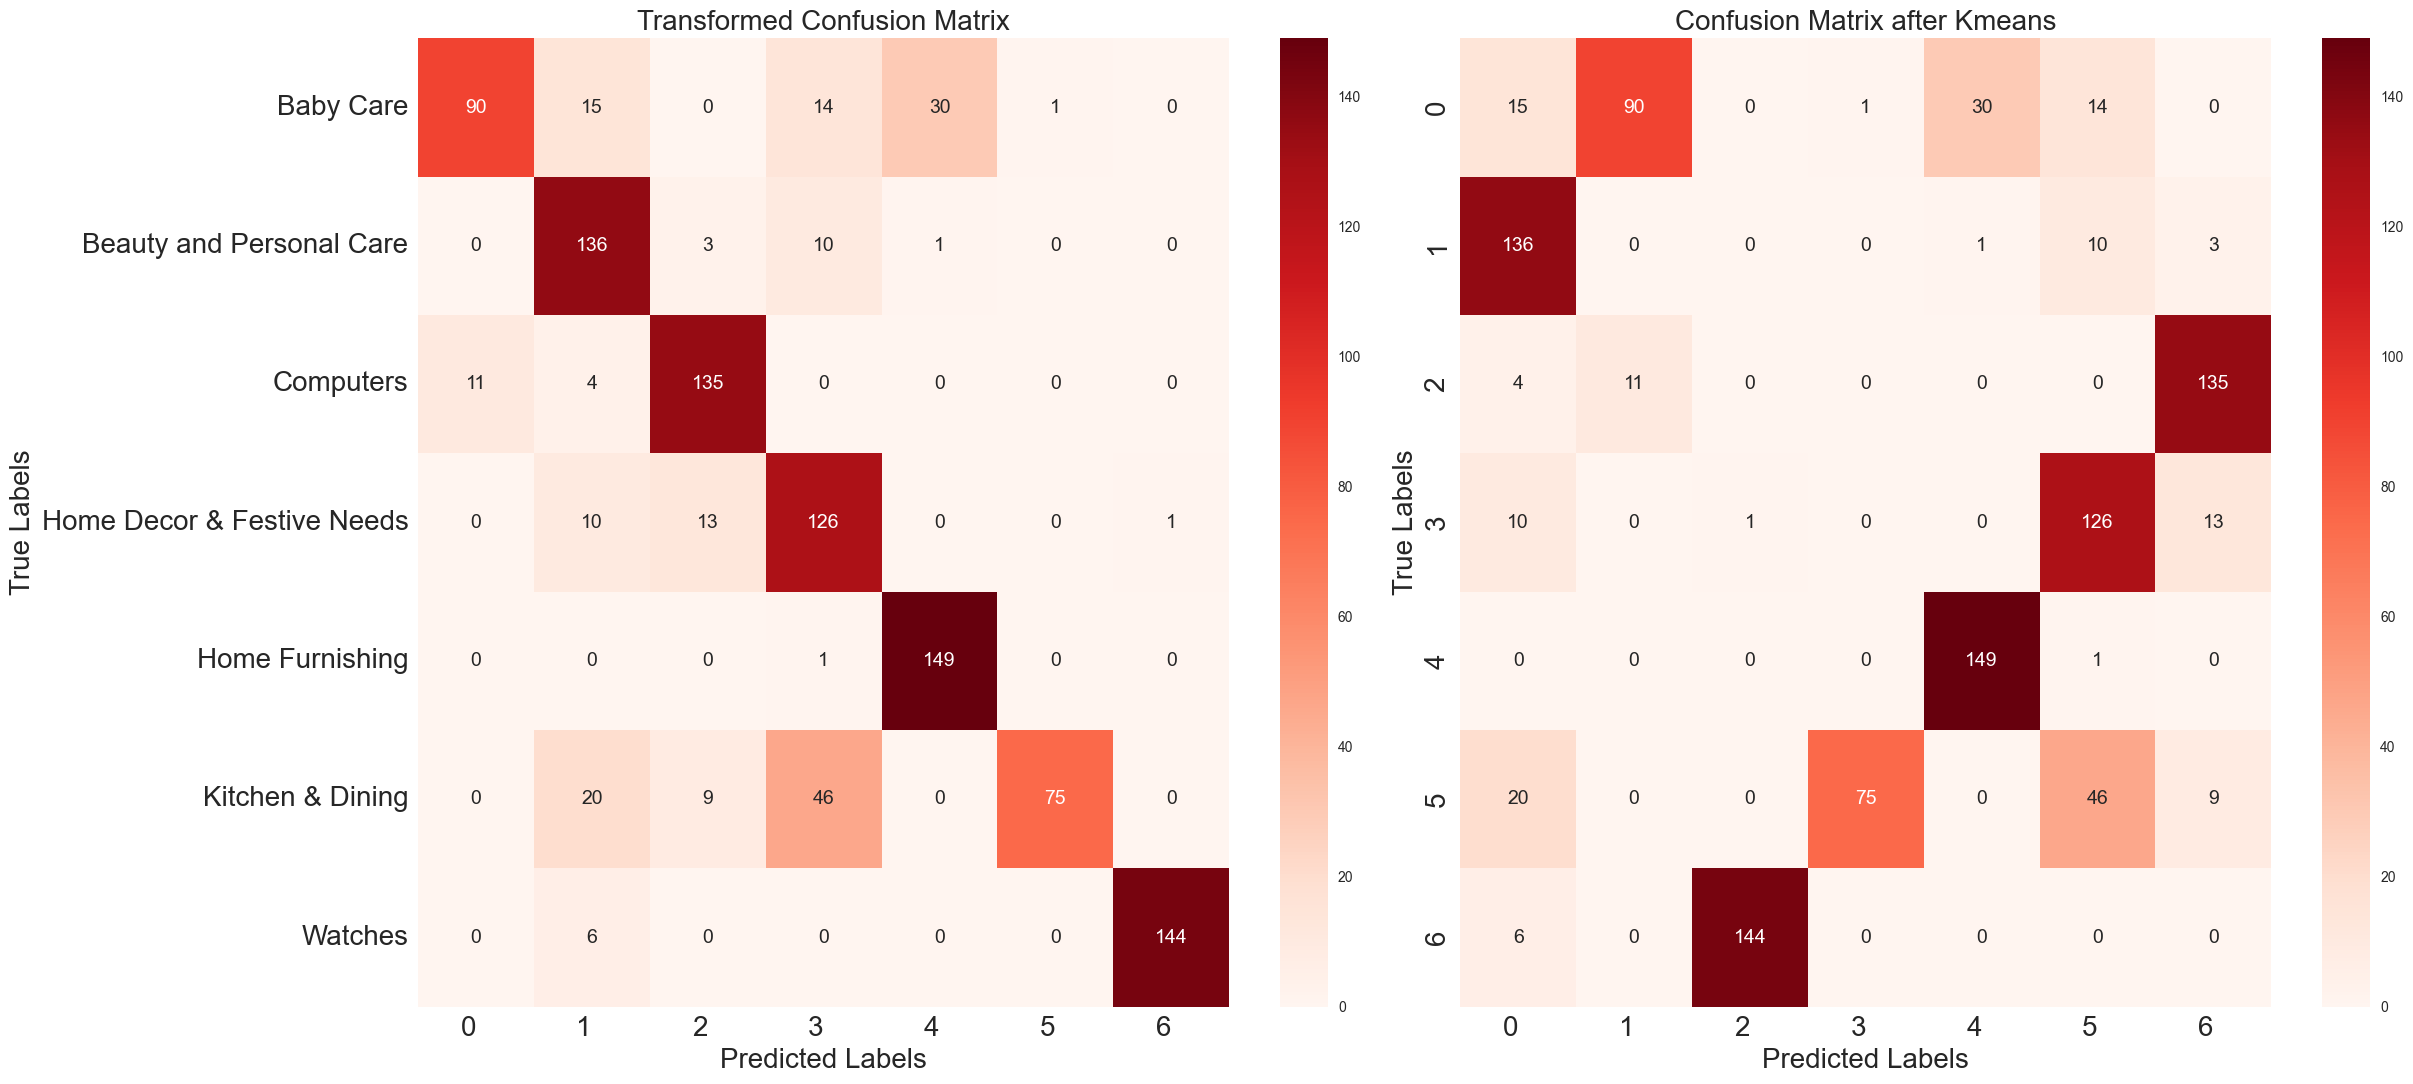

              precision    recall  f1-score   support

           0       0.89      0.60      0.72       150
           1       0.71      0.91      0.80       150
           2       0.84      0.90      0.87       150
           3       0.64      0.84      0.73       150
           4       0.83      0.99      0.90       150
           5       0.99      0.50      0.66       150
           6       0.99      0.96      0.98       150

    accuracy                           0.81      1050
   macro avg       0.84      0.81      0.81      1050
weighted avg       0.84      0.81      0.81      1050



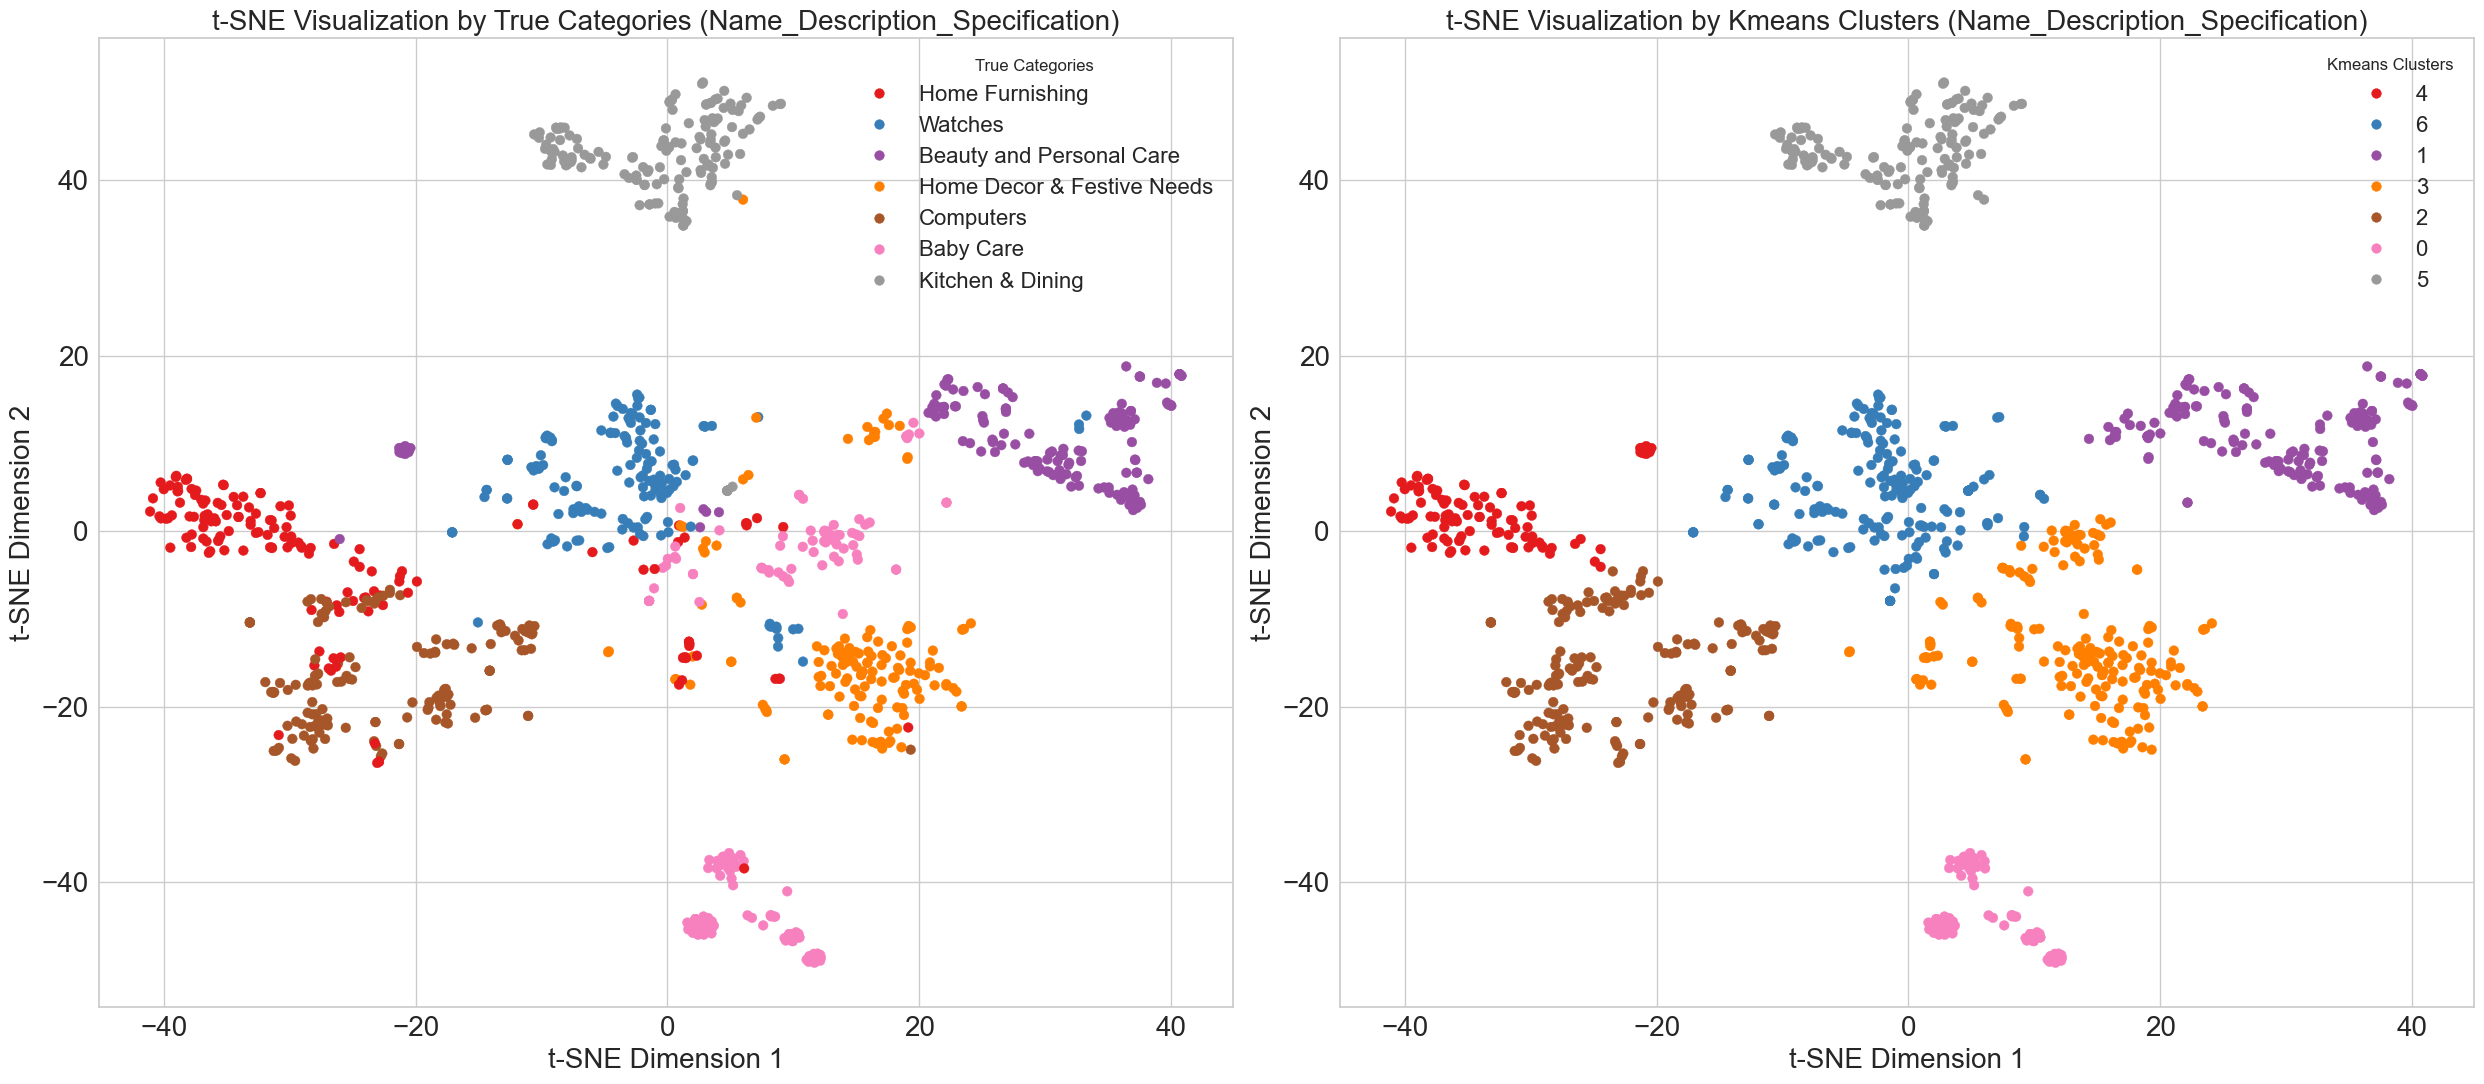

ARI: 0.64  /  SILOUETTE: 0.59


In [55]:

# Plot only for the best ARI
if best_params is not None:
    text_Column = best_params['text_Column']
    w2v_size = best_params['w2v_size']
    w2v_window = best_params['w2v_window']
    w2v_min_count = best_params['w2v_min_count']
    w2v_epoch = best_params['w2v_epoch']
    df_tsne = best_params['df_tsne']
    X_tsne = best_params['X_tsne']

    print('ARI score optimal for: {} {} {} {} {}'.format(text_Column, w2v_size, w2v_window, w2v_min_count, w2v_epoch))
    kmeans_labels = best_params['kmeans_labels']

    df_tsne["category"] = df_cleaned["subcategory_1"]
    df_tsne["category_encoded"] = df_cleaned["category_encoded"]
    df_tsne["Kmeans_cluster"] = kmeans_labels

    # Plot confusion matrix
    df_cm_transf, df_tsne, category_name, sorted_indices= conf_mat_transform(df_tsne)
    category_reindexed = [key for key, value in sorted(category_dict.items(), key=lambda x: list(df_tsne.Transformed_Cluster.unique()).index(x[1]))]

    # Now, use the modified df_tsne for the t-SNE visualization
    TSNE_visualization(X_tsne, category_reindexed, df_tsne, best_ari, best_silhouette, text_Column)


In [56]:
best_params

{'text_Column': 'Name_Description_Specification',
 'w2v_size': 200,
 'w2v_window': 3,
 'w2v_min_count': 10,
 'w2v_epoch': 100,
 'kmeans_labels': array([4, 4, 4, ..., 5, 5, 5]),
 'X_tsne': array([[-10.839284 , -13.377701 ],
        [-27.07205  ,  -8.017186 ],
        [-28.277388 ,  -8.958135 ],
        ...,
        [  1.7080916, -12.583038 ],
        [  1.4675428, -14.441772 ],
        [  1.7105082, -12.563987 ]], dtype=float32),
 'df_tsne':           tsne1      tsne2         category  category_encoded  Kmeans_cluster  \
 0    -10.839284 -13.377701  Home Furnishing                 4               4   
 1    -27.072050  -8.017186        Baby Care                 0               4   
 2    -28.277388  -8.958135        Baby Care                 0               4   
 3    -22.658121 -25.314209  Home Furnishing                 4               4   
 4    -22.769409 -25.617903  Home Furnishing                 4               4   
 ...         ...        ...              ...               ...  

# BERT

No need to apply any heavy cleaning for BERT and USE approaches. Stop words are not removed and lemmatization/stemming methods are NOT applied.
Only some special characters are removed + lower case

In [57]:
df_bert_use = pd.DataFrame()
df_bert_use["category"] = df_cleaned["subcategory_1"]
df_bert_use["category_encoded"] = df_cleaned["category_encoded"]

# Iterate through columns and apply text cleaning
for text_Column in columns_to_process:
    df_bert_use.loc[:, text_Column] = df[text_Column].apply(process_text_bert_use)

In [58]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [59]:
max_length = 512
batch_size = 10
model_types = ['bert-large-uncased-whole-word-masking', 'roberta-base', 'bert-base-uncased'] #'bert-large-uncased-whole-word-masking', 'distilbert-base-uncased'

best_ari = -1  # Initialize with a low value
best_silhouette = -1  # Initialize with a low value
best_params = None

for text_Column, model_type in itertools.product(columns_to_process, model_types):
    print('text_Column: ' + text_Column, 'model_type: ' + model_type)
    time1 = time.time()
    model = TFAutoModel.from_pretrained(model_type)
    sentences = df_bert_use[text_Column]
    features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, max_length, batch_size, mode='HF')

    features = features_bert
    #X_reduction = SVD_Runner(features)
    X_tsne, df_tsne = apply_tsne(features, tsne_params=None)
    ARI, SILOUHETTE, kmeans_labels = Kmeans_Metrics(X_tsne, num_clusters=len(real_categories))
    time2 = np.round(time.time() - time1, 0)

    print("ARI: ", str(ARI), "SILOUHETTE: ", str(SILOUHETTE), "time: ", str(time2))

    # Update df_scores
    df_scores = df_scores.append({'Analysis': 'BERT: ' + str(model_type),
                                  'Corpus': text_Column,
                                  'ARI': ARI,
                                  'SILOUHETTE': SILOUHETTE,
                                  'Time (s)': time2},
                                 ignore_index=True)

    # Check if the current ARI is the best
    if ARI > best_ari:
        best_ari = ARI
        best_silhouette = SILOUHETTE
        best_params = {'text_Column': text_Column, 'model_type': model_type, 'kmeans_labels': kmeans_labels,
                       'X_tsne': X_tsne, 'df_tsne': df_tsne}



text_Column: Name_Specification model_type: bert-large-uncased-whole-word-masking


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1/1 [==============================] - 23s 23s/step
temps traitement :  3685.0
ARI:  0.6 SILOUHETTE:  0.53 time:  3734.0
text_Column: Name_Specification model_type: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

1/1 [==============================] - 8s 8s/step
temps traitement :  853.0
ARI:  0.31 SILOUHETTE:  0.45 time:  884.0
text_Column: Name_Specification model_type: bert-base-uncased


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1/1 [==============================] - 8s 8s/step
temps traitement :  850.0
ARI:  0.62 SILOUHETTE:  0.54 time:  880.0
text_Column: Name_Description model_type: bert-large-uncased-whole-word-masking


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1/1 [==============================] - 23s 23s/step
temps traitement :  2455.0
ARI:  0.35 SILOUHETTE:  0.55 time:  2491.0
text_Column: Name_Description model_type: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

1/1 [==============================] - 8s 8s/step
temps traitement :  846.0
ARI:  0.14 SILOUHETTE:  0.45 time:  877.0
text_Column: Name_Description model_type: bert-base-uncased


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1/1 [==============================] - 8s 8s/step
temps traitement :  861.0
ARI:  0.27 SILOUHETTE:  0.57 time:  891.0
text_Column: Name_Description_Specification model_type: bert-large-uncased-whole-word-masking


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1/1 [==============================] - 23s 23s/step
temps traitement :  2469.0
ARI:  0.39 SILOUHETTE:  0.49 time:  2504.0
text_Column: Name_Description_Specification model_type: roberta-base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

1/1 [==============================] - 8s 8s/step
temps traitement :  885.0
ARI:  0.25 SILOUHETTE:  0.45 time:  915.0
text_Column: Name_Description_Specification model_type: bert-base-uncased


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1/1 [==============================] - 8s 8s/step
temps traitement :  880.0
ARI:  0.39 SILOUHETTE:  0.47 time:  910.0


ARI score optimal for: Name_Specification bert-base-uncased
ARI score optimal for: Name_Specification bert-base-uncased 512 10
[[  5   8   0  43   0   7  87]
 [126   5   1   3   0   6   9]
 [  0   0   1   2   0 147   0]
 [  6 113   0  12   0  19   0]
 [  0   6   0 144   0   0   0]
 [  0  51   0   2  74  11  12]
 [  0   0 146   0   0   4   0]]
corresp: [1 3 6 4 5 2 0]


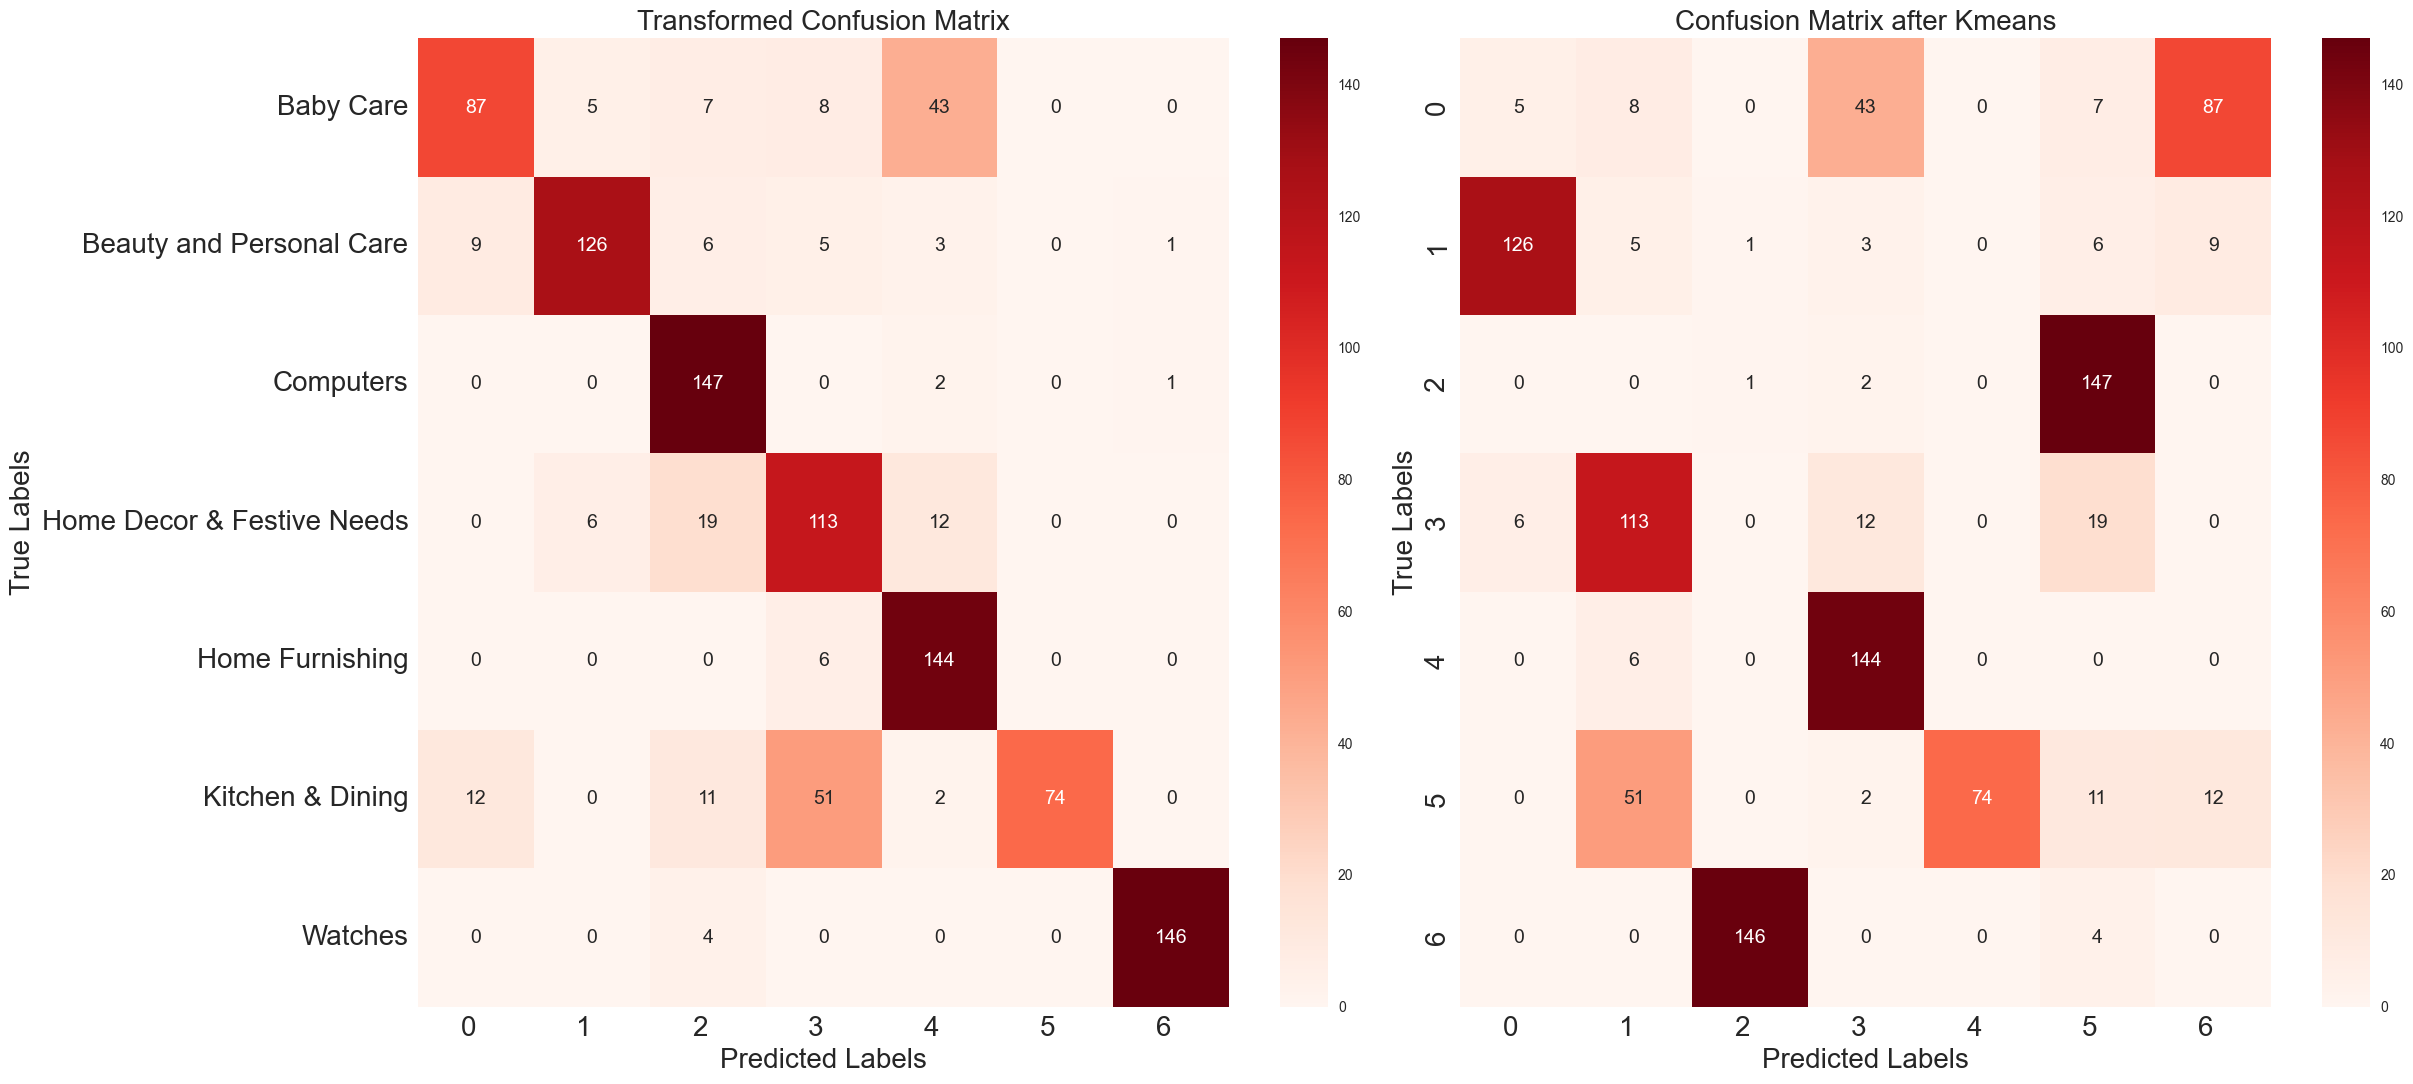

              precision    recall  f1-score   support

           0       0.81      0.58      0.67       150
           1       0.92      0.84      0.88       150
           2       0.76      0.98      0.85       150
           3       0.62      0.75      0.68       150
           4       0.70      0.96      0.81       150
           5       1.00      0.49      0.66       150
           6       0.99      0.97      0.98       150

    accuracy                           0.80      1050
   macro avg       0.83      0.80      0.79      1050
weighted avg       0.83      0.80      0.79      1050



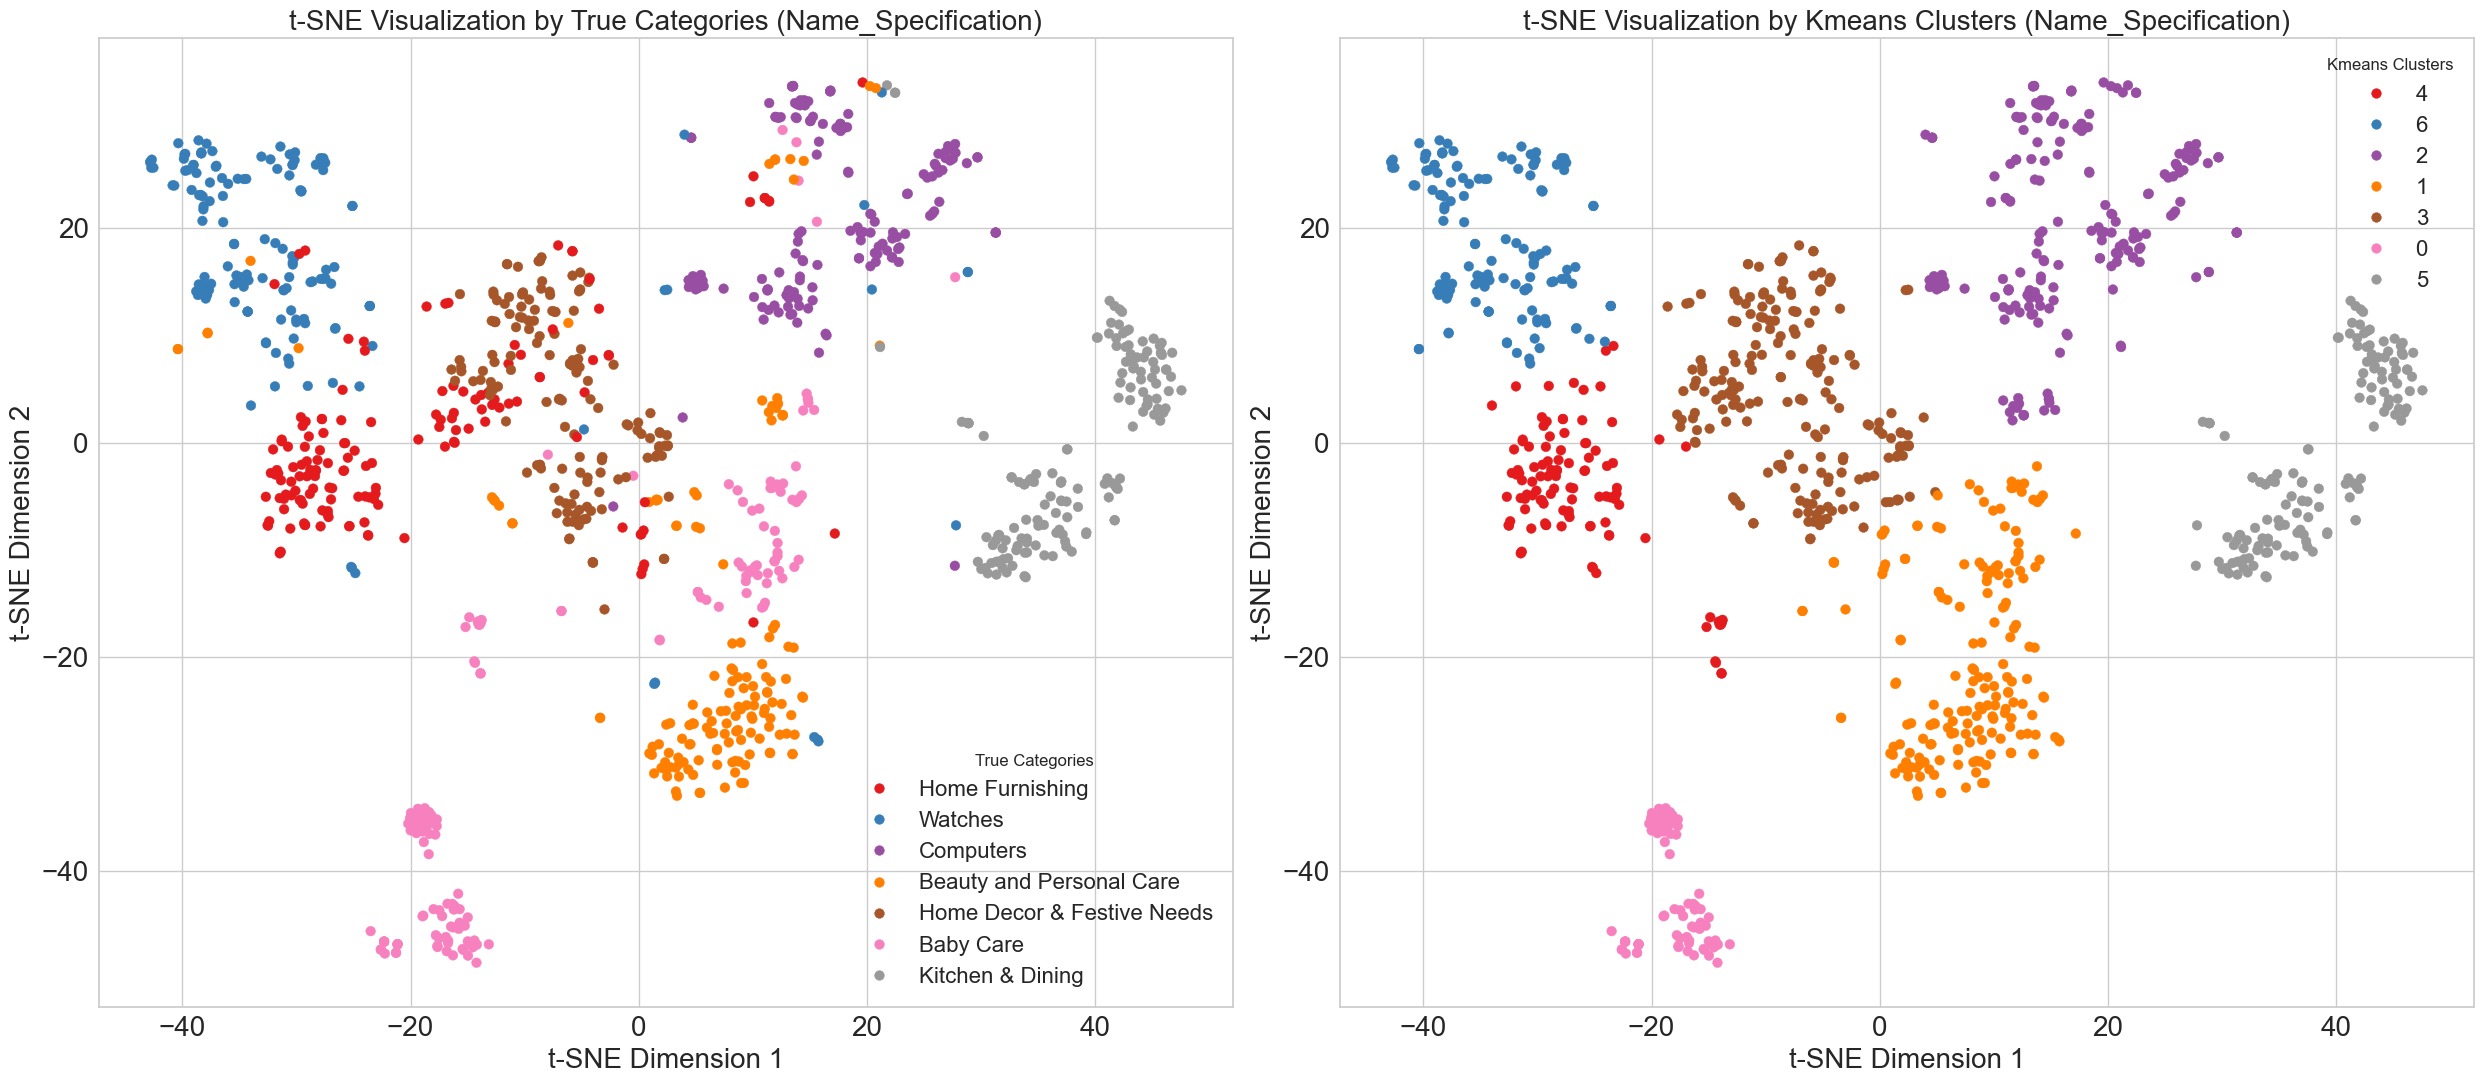

ARI: 0.62  /  SILOUETTE: 0.54


In [60]:

# Plot only for the best ARI
if best_params is not None:
    text_Column = best_params['text_Column']
    model_type = best_params['model_type']

    print('ARI score optimal for: {} {}'.format(text_Column, model_type))
    kmeans_labels = best_params['kmeans_labels']
    df_tsne = best_params['df_tsne']
    X_tsne = best_params['X_tsne']

    print('ARI score optimal for: {} {} {} {}'.format(text_Column, model_type, max_length, batch_size))

    df_tsne["category"] = df_bert_use["category"]
    df_tsne["category_encoded"] = df_bert_use["category_encoded"]
    df_tsne["Kmeans_cluster"] = kmeans_labels

    # Plot confusion matrix
    df_cm_transf, df_tsne, category_name, sorted_indices= conf_mat_transform(df_tsne)
    category_reindexed = [key for key, value in sorted(category_dict.items(), key=lambda x: list(df_tsne.Transformed_Cluster.unique()).index(x[1]))]

    # Now, use the modified df_tsne for the t-SNE visualization
    TSNE_visualization(X_tsne, category_reindexed, df_tsne, best_ari, best_silhouette, text_Column)


# USE - Universal Sentence Encoder

In [61]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
#import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v8.0'


In [62]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    return features

In [63]:
batch_size = 10

best_ari = -1  # Initialize with a low value
best_silhouette = -1  # Initialize with a low value
best_params = None

for text_Column in columns_to_process:
    time1 = time.time()
    sentences = df_bert_use[text_Column].to_list()
    features_USE = feature_USE_fct(sentences, batch_size)

    features = features_USE
    print('features embeddings USE: ' + str(features.shape))
    #X_reduction = SVD_Runner(features)
    X_tsne, df_tsne = apply_tsne(features, tsne_params=None)
    ARI, SILOUHETTE, kmeans_labels = Kmeans_Metrics(X_tsne, num_clusters=len(real_categories))
    time2 = np.round(time.time() - time1, 0)

    print("ARI: ", str(ARI), "SILOUHETTE: ", str(SILOUHETTE), "time: ", str(time2))

    # Update df_scores
    df_scores = df_scores.append({'Analysis': 'USE',
                                  'Corpus': text_Column,
                                  'ARI': ARI,
                                  'SILOUHETTE': SILOUHETTE,
                                  'Time (s)': time2},
                                 ignore_index=True)

    # Check if the current ARI is the best
    if ARI > best_ari:
        best_params = None
        best_ari = ARI
        best_silhouette = SILOUHETTE
        best_params = {'text_Column': text_Column, 'kmeans_labels': kmeans_labels, 'ARI':best_ari, 'SILOUHETTE': best_silhouette, 'Features': features}

features embeddings USE: (1050, 512)
ARI:  0.63 SILOUHETTE:  0.57 time:  31.0
features embeddings USE: (1050, 512)
ARI:  0.47 SILOUHETTE:  0.51 time:  30.0
features embeddings USE: (1050, 512)
ARI:  0.68 SILOUHETTE:  0.54 time:  30.0


ARI score optimal for: Name_Description_Specification
[[  0  42  16   0   3  86   3]
 [  0   6  13   2   0   1 128]
 [  0   0   0 150   0   0   0]
 [  0   9 128   7   6   0   0]
 [  0 149   1   0   0   0   0]
 [  0   0  53   7  90   0   0]
 [149   0   1   0   0   0   0]]
corresp: [6 4 3 2 5 0 1]


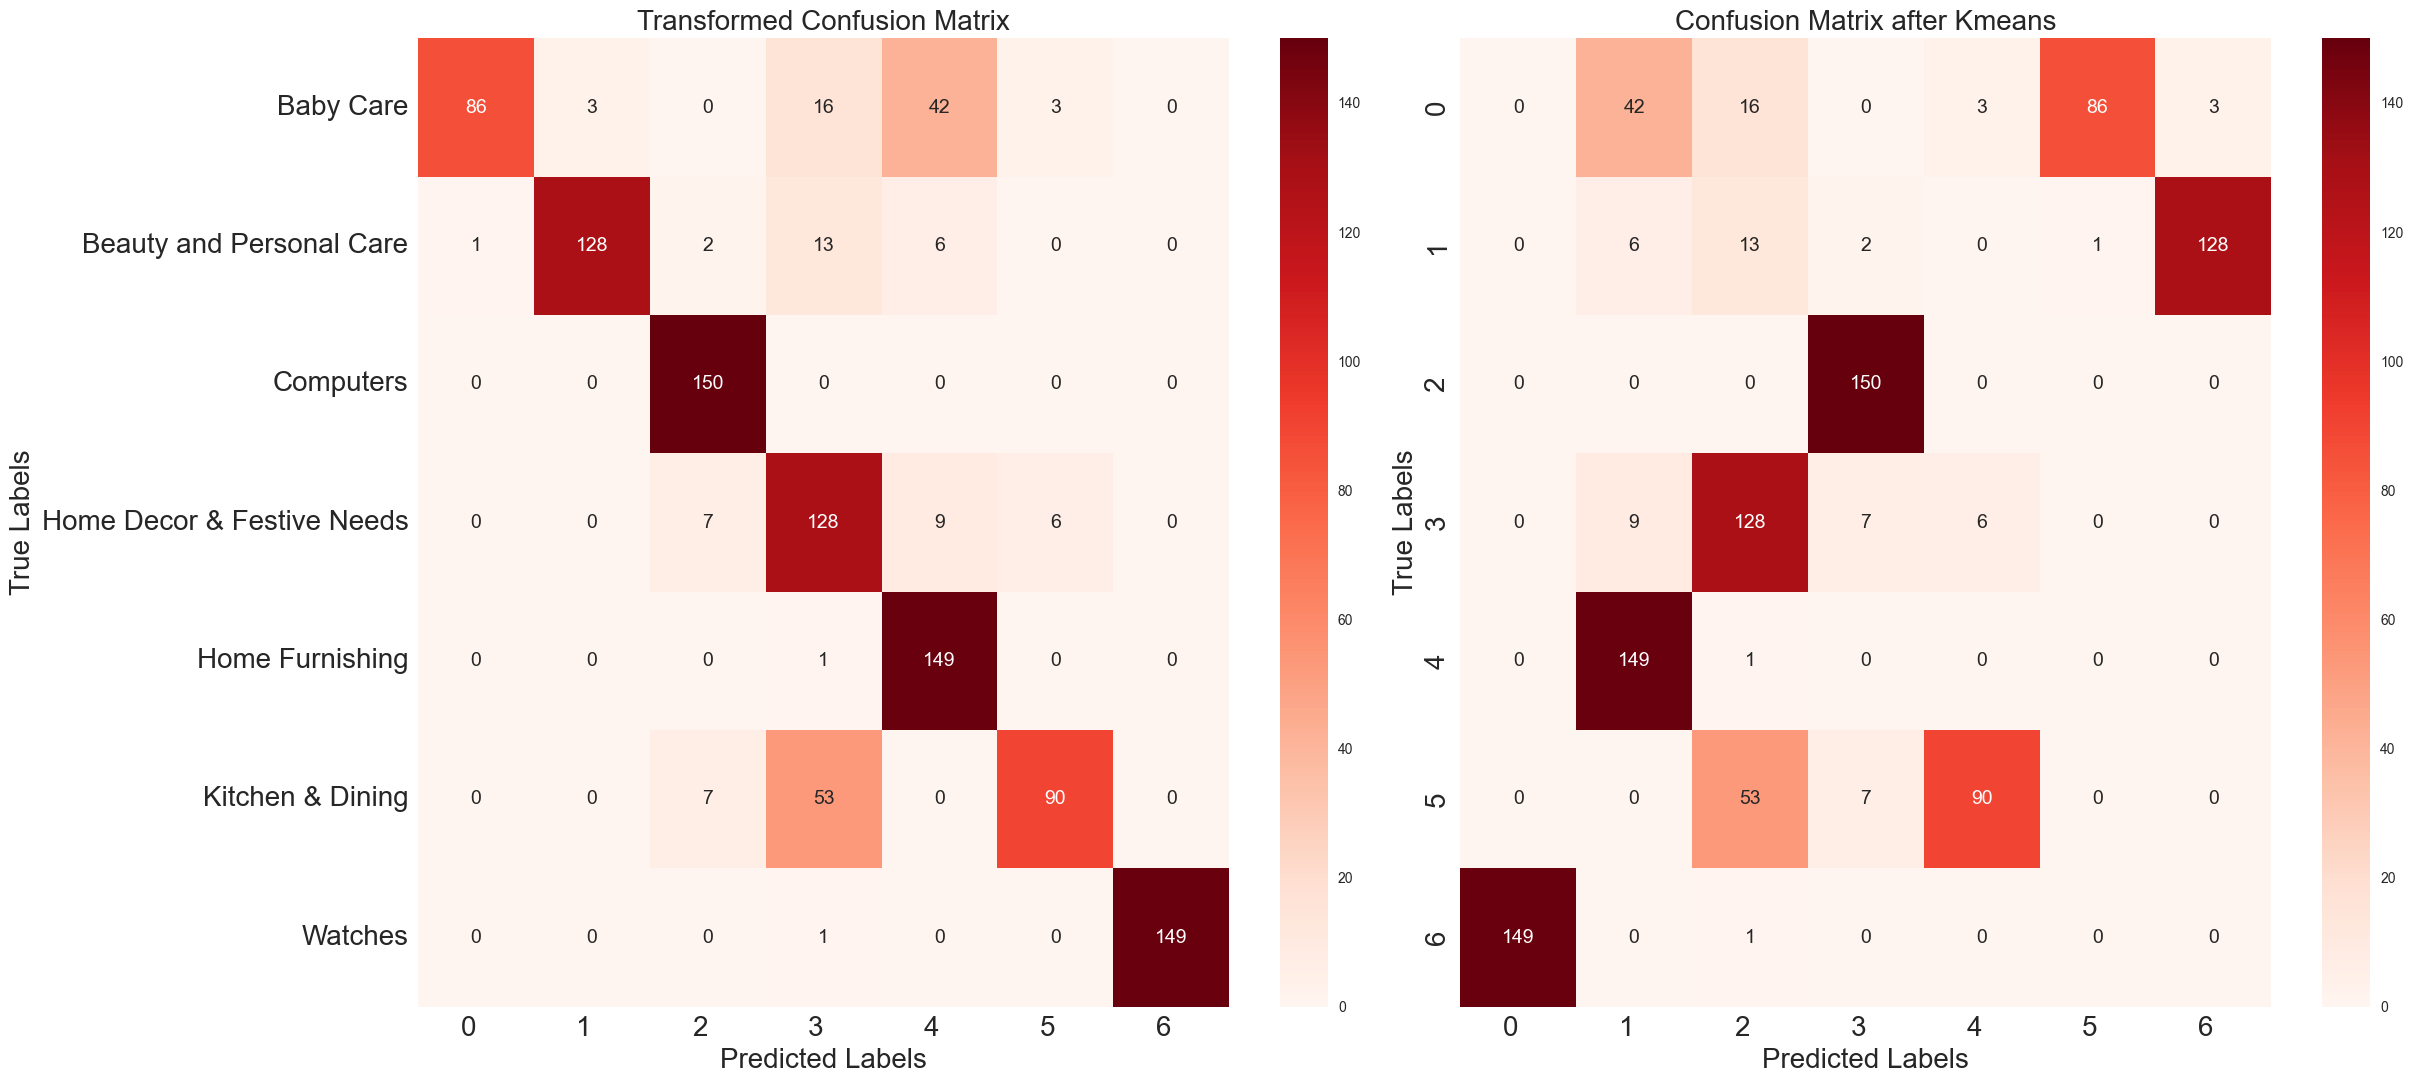

              precision    recall  f1-score   support

           0       0.99      0.57      0.73       150
           1       0.98      0.85      0.91       150
           2       0.90      1.00      0.95       150
           3       0.60      0.85      0.71       150
           4       0.72      0.99      0.84       150
           5       0.91      0.60      0.72       150
           6       1.00      0.99      1.00       150

    accuracy                           0.84      1050
   macro avg       0.87      0.84      0.84      1050
weighted avg       0.87      0.84      0.84      1050



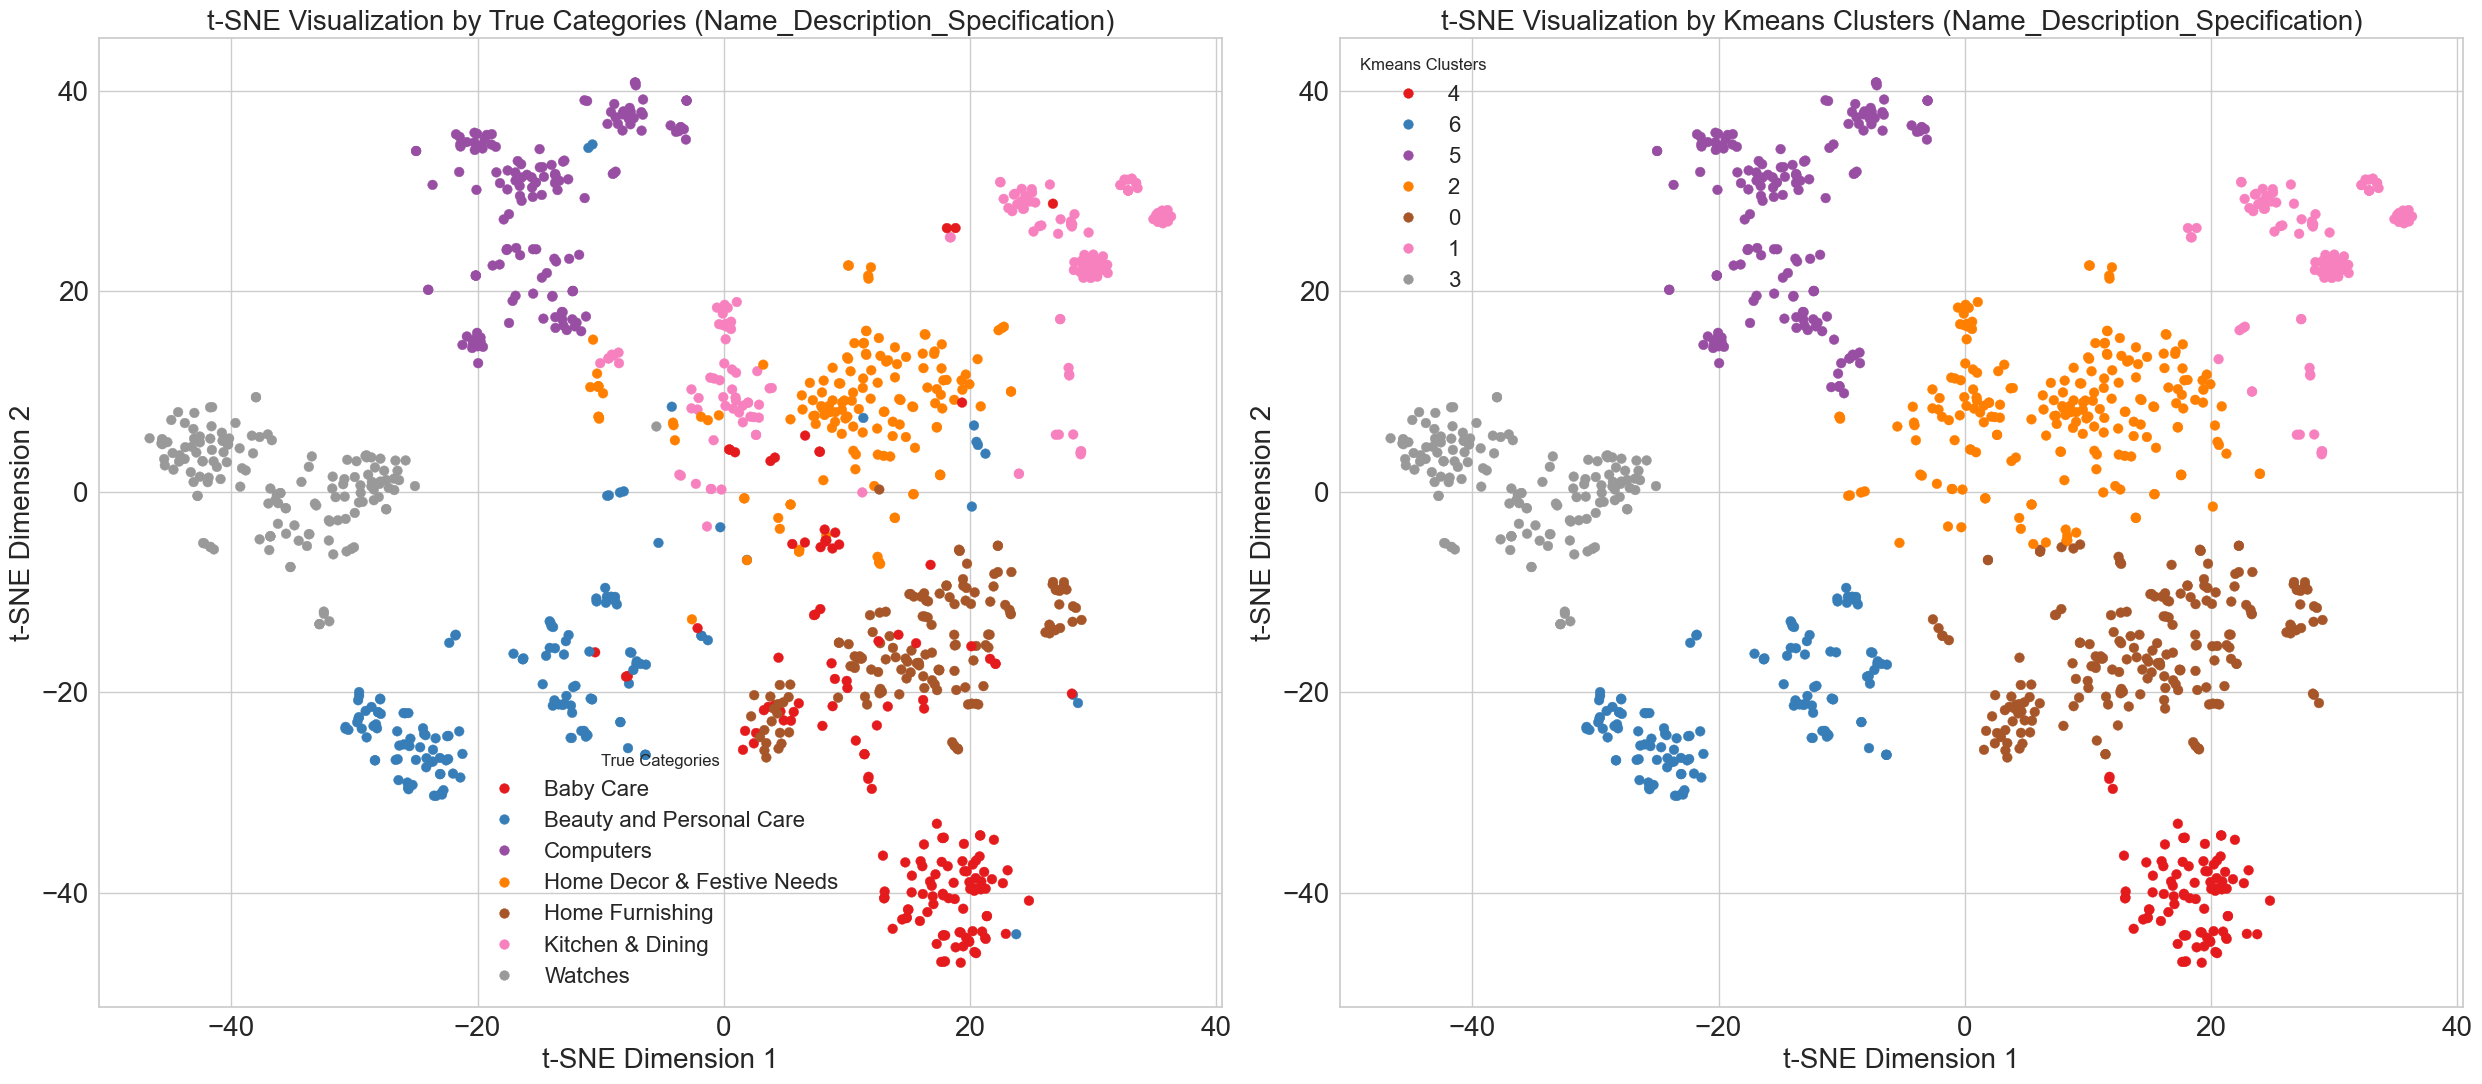

ARI: 0.68  /  SILOUETTE: 0.54


In [64]:

# Plot only for the best ARI
if best_params is not None:
    text_Column = best_params['text_Column']
    print('ARI score optimal for: {}'.format(text_Column))
    kmeans_labels = best_params['kmeans_labels']

    # Plot t-SNE visualization
    X_tsne, df_tsne = apply_tsne(best_params['Features'], tsne_params=None)

    df_tsne["category"] = df_bert_use["category"]
    df_tsne["category_encoded"] = df_bert_use["category_encoded"]
    df_tsne["Kmeans_cluster"] = kmeans_labels

    # Plot confusion matrix
    df_cm_transf, df_tsne, category_name, sorted_indices= conf_mat_transform(df_tsne)
    #category_reindexed = [key for key, value in sorted(category_dict.items(), key=lambda x: list(df_tsne.Transformed_Cluster.unique()).index(x[1]))]

    # Now, use the modified df_tsne for the t-SNE visualization
    TSNE_visualization(X_tsne, category_name, df_tsne, best_ari, best_silhouette, text_Column)

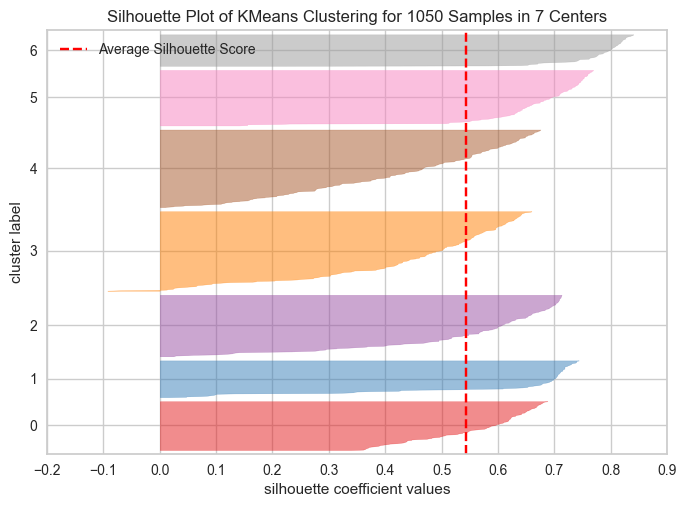

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 1050 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [65]:
kmeans = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
kmeans.fit(X_tsne)


vzr = SilhouetteVisualizer(kmeans)
vzr.fit(X_tsne)
vzr.poof()

In [66]:
df

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [67]:
import random

descrip = df_tsne[(df_tsne['category_encoded'] == 5) & (df_tsne['Transformed_Cluster'] == 3)]
random_values = random.sample(descrip.index.tolist(), 3)
print(random_values)
#random_values = [39, 918, 934]
#print(random_values)
# print("-------")
for i in range(1):
    filename = df.iloc[random_values[i]]['product_name']
    print(filename)
    product_url = df.iloc[random_values[i]]['product_url']
    print(product_url)
    product_category_tree = df.iloc[random_values[i]]['product_category_tree']
    print(product_category_tree)
    description = df.iloc[random_values[i]]['description']
    print(description)

[1000, 247, 235]
Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container
http://www.flipkart.com/lock-lock-kitchen-5-5-l-polypropylene-multi-purpose-storage-container/p/itmejvgg6wgbfvj6?pid=CNTEJVGGPSZRZDFH
["Kitchen & Dining >> Containers & Bottles >> Containers & Jars >> Kitchen Containers >> Lock&Lock Kitchen Containers >> Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-p..."]
Key Features of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5

In [68]:
df_tsne[(df_tsne['category_encoded'] == 1) & (df_tsne['Transformed_Cluster'] == 2)]


tsne1      tsne2                  category  category_encoded  \
124 -10.995966  34.311237  Beauty and Personal Care                 1   
441 -10.665309  34.657642  Beauty and Personal Care                 1   

     Kmeans_cluster  Transformed_Cluster  
124               3                    2  
441               3                    2

In [69]:
df.iloc[124]['product_category_tree']

'["Beauty and Personal Care >> Health Care >> Health Care Devices >> Electrotherapy >> SOS Electrotherapy >> SOS COMPUTRISED LCD INTRFERENTIAL UNIT-125PROG. ..."]'

In [70]:
df.iloc[124]['product_url']

'http://www.flipkart.com/sos-computrised-lcd-intrferential-unit-125prog-muscle-spasm-electrotherapy-device/p/itmejxm5x3xz63te?pid=ELTEJXM48D3HAUFB'

Save otained scores for postProcessing

# Post Processing

In [71]:
import pandas as pd
# Read the CSV file into a DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', -1)
df_scores = pd.read_csv('df_scores.csv')
df_scores

Model                 Analysis                          Corpus  \
0   Count Vectorizer  CountVectorizer          Name_Specification               
1   TF-IDF            TfidfVectorizer          Name_Specification               
2   Count Vectorizer  CountVectorizer          Name_Description                 
3   TF-IDF            TfidfVectorizer          Name_Description                 
4   Count Vectorizer  CountVectorizer          Name_Description_Specification   
..               ...              ...                                     ...   
31  BERT              BERT: roberta-base       Name_Description_Specification   
32  BERT              BERT: bert-base-uncased  Name_Description_Specification   
33  USE               USE                      Name_Specification               
34  USE               USE                      Name_Description                 
35  USE               USE                      Name_Description_Specification   

     ARI  SILOUHETTE  Time (s)  
0   0.55  0.54        26        
1   0.59  0.55        27        
2   0.38  0.47        26        
3   0.34  0.44        27        
4   0.54  0.54        27        
..   ...   ...        ..        
31  0.25  0.44        925       
32  0.40  0.48        936       
33  0.64  0.57        30        
34  0.48  0.51        30        
35  0.69  0.54        30        

[36 rows x 6 columns]

In [72]:
idxmax_ari = df_scores.groupby(['Model', 'Corpus'])['ARI'].idxmax()
df_group = df_scores.groupby(['Model', 'Corpus'])
result_df = df_group.apply(lambda group: group.loc[idxmax_ari.loc[group.name]])

result_df[['ARI', 'SILOUHETTE', 'Time (s)']]

ARI  SILOUHETTE  Time (s)
Model            Corpus                                                    
BERT             Name_Description                0.35  0.51        2568    
                 Name_Description_Specification  0.40  0.48        936     
                 Name_Specification              0.62  0.55        914     
Count Vectorizer Name_Description                0.38  0.47        26      
                 Name_Description_Specification  0.54  0.54        27      
                 Name_Specification              0.55  0.54        26      
TF-IDF           Name_Description                0.34  0.44        27      
                 Name_Description_Specification  0.53  0.54        27      
                 Name_Specification              0.59  0.55        27      
USE              Name_Description                0.48  0.51        30      
                 Name_Description_Specification  0.69  0.54        30      
                 Name_Specification              0.64  0.57        30      
Word2Vec         Name_Description                0.60  0.52        31      
                 Name_Description_Specification  0.64  0.59        32      
                 Name_Specification              0.59  0.54        30

In [73]:

# Split the 'Analysis' column on special characters and keep only the first element
#df_scores['Model'] = df_scores['Analysis'].str.split('[^a-zA-Z0-9-]').str[0]

# Convert 'Analysis' and 'Corpus' columns to a tuple for grouping
df_scores['Model_Corpus'] = list(zip(df_scores['Model'], df_scores['Corpus']))

# Group by 'Analysis_Corpus' and find the row with the highest ARI in each group
max_ari_rows = df_scores.groupby('Model')['ARI'].idxmax()
max_ari_rows

Model
BERT                26
Count Vectorizer    0 
TF-IDF              1 
USE                 35
Word2Vec            7 
Name: ARI, dtype: int64

In [74]:
# Filter the original DataFrame to keep only the rows with the highest ARI
filtered_df = df_scores.loc[max_ari_rows]

# Drop the temporary columns
filtered_df = filtered_df.drop(columns=['Model_Corpus'])

# Sort the DataFrame by 'ARI' in descending order
filtered_df = filtered_df.sort_values(by=['ARI'], ascending=False)

replace_dict = {
    'w2v': 'Word2Vec',
 'BERTbert-base-uncased': 'BERT bert-base-uncased',
 'TfidfVectorizer': 'Tf-idf',
 'CountVectorizer': 'Count Vectorizer',
 'BERTroberta': 'BERT roberta'
}

filtered_df['Model'] = filtered_df['Model'].replace(replace_dict)
filtered_df

Model  \
35  USE                
7   Word2Vec           
26  BERT               
1   TF-IDF             
0   Count Vectorizer   

                                                                                                 Analysis  \
35  USE                                                                                                     
7   w2v_size: 200 / w2v_window: 5 / w2v_min_count: 10 / w2v_epoch: 100 / kmeans_labels: [5 5 5 ... 2 2 2]   
26  BERT: bert-base-uncased                                                                                 
1   TfidfVectorizer                                                                                         
0   CountVectorizer                                                                                         

                            Corpus   ARI  SILOUHETTE  Time (s)  
35  Name_Description_Specification  0.69  0.54        30        
7   Name_Description_Specification  0.64  0.59        32        
26  Name_Specification              0.62  0.55        914       
1   Name_Specification              0.59  0.55        27        
0   Name_Specification              0.55  0.54        26

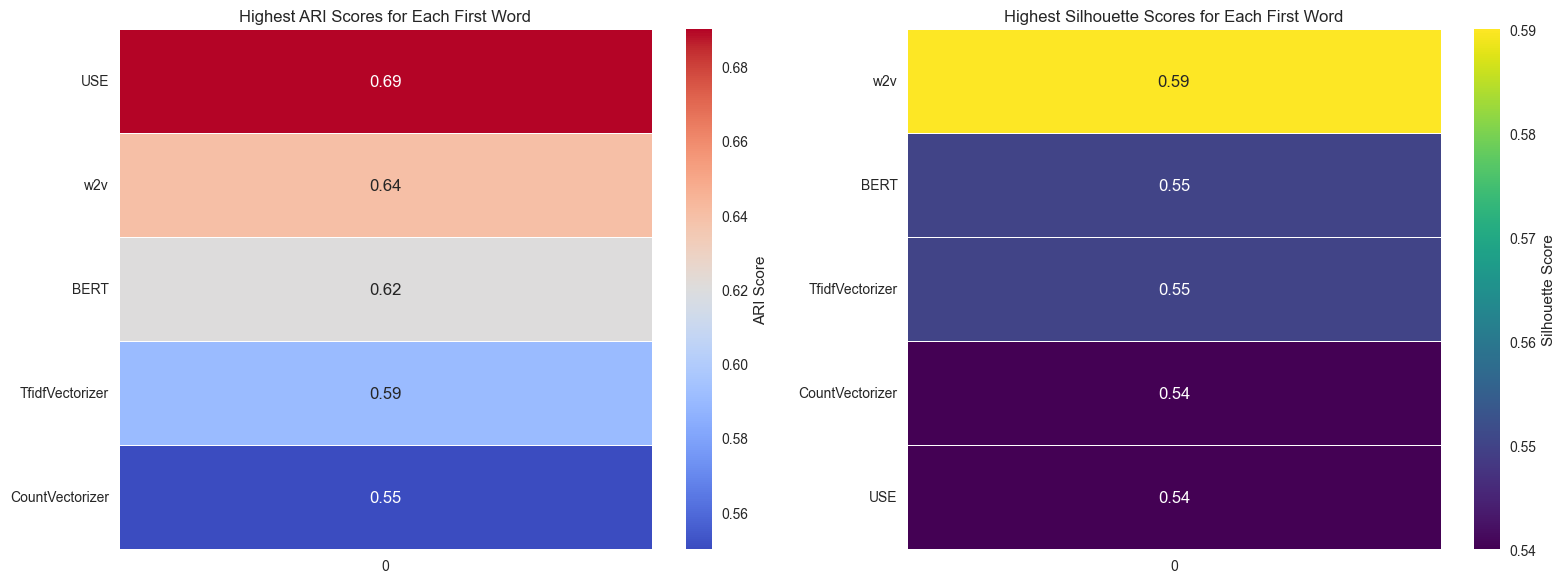

In [75]:
# Extract the first word from the 'Analysis' column, considering hyphens as part of the word
filtered_df['First_Word'] = filtered_df['Analysis'].str.split('[^a-zA-Z0-9-]').str[0]

# Group by 'First_Word' and find the highest ARI and silhouette scores in each group
max_ari_rows = filtered_df.groupby('First_Word')['ARI'].idxmax()
max_silhouette_rows = filtered_df.groupby('First_Word')['SILOUHETTE'].idxmax()

# Filter the original DataFrame to keep only the rows with the highest ARI and silhouette scores for each first word
filtered_df_ari = filtered_df.loc[max_ari_rows]
filtered_df_silhouette = filtered_df.loc[max_silhouette_rows]

filtered_df_ari_pivot = filtered_df_ari.pivot(index='First_Word', columns='Corpus', values='ARI').reset_index()
filtered_df_silhouette_pivot = filtered_df_silhouette.pivot(index='First_Word', columns='Corpus', values='SILOUHETTE').reset_index()

# Get the maximum ARI and silhouette scores for each first word
filtered_df_ari_pivot['Score'] = filtered_df_ari_pivot[filtered_df.Corpus.unique().tolist()].apply(lambda x: next((val for val in x if pd.notna(val)), None), axis=1)
filtered_df_ari_pivot = filtered_df_ari_pivot.sort_values(by=['Score'], ascending=False)

filtered_df_silhouette_pivot['Score'] = filtered_df_silhouette_pivot[filtered_df.Corpus.unique().tolist()].apply(lambda x: next((val for val in x if pd.notna(val)), None), axis=1)
filtered_df_silhouette_pivot = filtered_df_silhouette_pivot.sort_values(by=['Score'], ascending=False)

# Create heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for ARI scores
ax1 = axes[0]
heatmap_ari = sns.heatmap(filtered_df_ari_pivot[['Score']].values,
                          annot=True, cmap='coolwarm', linewidths=.5, cbar_kws={'label': 'ARI Score'}, ax=ax1)
ax1.set_title('Highest ARI Scores for Each First Word')
ax1.set_yticklabels(filtered_df_ari_pivot['First_Word'], rotation=0)  # Label rows by index

# Heatmap for silhouette scores
ax2 = axes[1]
heatmap_silhouette = sns.heatmap(filtered_df_silhouette_pivot[['Score']].values,
                                  annot=True, cmap='viridis', linewidths=.5, cbar_kws={'label': 'Silhouette Score'}, ax=ax2)
ax2.set_title('Highest Silhouette Scores for Each First Word')
ax2.set_yticklabels(filtered_df_silhouette_pivot['First_Word'], rotation=0)  # Label rows by index

plt.tight_layout()
plt.show()


In [76]:
filtered_df_ari.pivot(index='First_Word', columns='Corpus', values='ARI')

Corpus           Name_Description_Specification  Name_Specification
First_Word                                                         
BERT            NaN                              0.62              
CountVectorizer NaN                              0.55              
TfidfVectorizer NaN                              0.59              
USE              0.69                           NaN                
w2v              0.64                           NaN